# Analysis of Themes, Emotions and Tones in the Dataset

## 1. Introduction 

This notebook explores how feminist themes and emotional expressions are distributed across a curated corpus of literary texts written between the late 18th and early 20th centuries. We focus on works by women writers whose narratives contributed to, reflected, or challenged cultural norms around gender, morality, and autonomy.

Our goal is to extract interpretable patterns from this literature by combining modern NLP techniques with literary scholarship. Specifically, we aim to answer questions such as:
- What are the dominant **themes** and **topics** across books and authors?
- How are feminist concepts like **freedom**, **marriage**, or **virtue** emotionally framed?
- Which authors or texts are the most emotionally expressive?

The analysis proceeds in the following steps:
1. **Data Setup and Loading**: Prepare the environment, load preprocessed chunks, and visualize the corpus structure
2. **Preprocessing**: Clean and lemmatize the text; detect collocations and verb patterns to enrich thematic modeling
3. **Thematic Modeling**: Use TF-IDF, LDA, Word2Vec, and BERTopic to identify patterns of meaning across books and authors
4. **Emotion Classification**: Detect sentence-level emotions using transformer models (GoEmotions, zero-shot, ensemble)
5. **Interpretation**: Combine themes and emotions to understand how feminist values evolve, vary by author, and relate to narrative structure

This notebook serves as the foundation for interpreting how feminist discourse was constructed, emotionally shaped, and linguistically framed in canonical and lesser-known texts. All outputs are saved in the `data/processed/` directory and visualizations in `reports/figures/`, supporting further analysis or publication.

## 2. Environment and Data

This section sets up the environment and prepares the processed data for analysis. We begin by importing all necessary Python libraries, setting paths for our repository and dataset folders, and loading our default spaCy model (`en_core_web_sm`), used later for NLP tasks like lemmatization or NER.

Key setup steps:
- Defined repository base path and pointed to the processed dataset folder (`data/processed/`)
- Loaded two CSV files:
  - `processed_book_chunks.csv`: plain text chunks (no overlap)
  - `processed_book_chunks_context.csv`: context-aware chunks with a 50-word overlap
- Loaded spaCy's English pipeline for downstream preprocessing
- Confirmed the environment is correctly set up via print statements

These initial steps ensure consistent path resolution and model loading, regardless of the machine or folder structure used to run the notebook.

In [190]:
# import necessary libraries
import pandas as pd
import numpy as np
import spacy
from pathlib import Path
import matplotlib.pyplot as plt
import os
import re
import string
from collections import Counter
from tqdm import tqdm  
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind, entropy
tqdm.pandas()

In [2]:
# set base repository path
REPO_DIR = Path(".").resolve().parents[1]
PROCESSED_DIR = REPO_DIR / "data" / "processed"

# define data input/output paths
PROCESSED_PATH = REPO_DIR / "data" / "processed" / "processed_book_chunks.csv"
PROCESSED_PATH_CONTEXT = REPO_DIR / "data" / "processed" / "processed_book_chunks_context.csv"  # for context-aware processing
EMOTION_EXPORT_PATH = REPO_DIR / "data" / "processed" / "emotion_sentences.csv"
THEME_EXPORT_PATH = REPO_DIR / "data" / "processed" / "thematic_corpus.csv"

# load spaCy model (can be switched later to transformer-based)
nlp = spacy.load("en_core_web_sm")  # light and fast for prototyping

# confirm setup
print("Repository Path:", REPO_DIR)
print("Processed Data Loaded From:", PROCESSED_PATH)

/Users/emmamora/anaconda3/envs/feminist-nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Repository Path: /Users/emmamora/Documents/GitHub/feminist_nlp
Processed Data Loaded From: /Users/emmamora/Documents/GitHub/feminist_nlp/data/processed/processed_book_chunks.csv


## 3. Load Source Data

In this section, we load the cleaned and preprocessed text chunks that form the basis of our analysis.

We work with two versions of the dataset:
- `processed_book_chunks.csv`: clean chunked text without overlap
- `processed_book_chunks_context.csv`: same as above, but with a 50-word overlap between chunks for better context continuity

Each chunk includes metadata such as `title`, `author`, `year`, and a `chunk_id`. These datasets allow us to analyze text thematically and emotionally at a granular level while preserving authorial and temporal context.

We also validate the data structure and visualize the distribution of chunks per book and per author, which helps us normalize downstream analyses.

In [3]:
# load the processed chunk-level dataframes (simple & context-aware)
df = pd.read_csv(PROCESSED_PATH)
df_context = pd.read_csv(PROCESSED_PATH_CONTEXT)


In [4]:
# basic structure check
print("-- Simple Dataframe --")
print("\nData shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head(5)

-- Simple Dataframe --

Data shape: (4852, 5)

Columns: ['chunk', 'title', 'author', 'year', 'chunk_id']


chunk    title  \
0  CHAPTER 1.\nA Not Unnatural Enterprise This is...  Herland   
1  The expedition was up among the thousand tribu...  Herland   
2  It was early yet; we had just breakfasted; and...  Herland   
3  “Woman Country--up\nthere.” Then we were inter...  Herland   
4  It had a special covering of fitted armor, thi...  Herland   

                     author  year chunk_id  
0  Charlotte Perkins Gilman  1915   CP_001  
1  Charlotte Perkins Gilman  1915   CP_002  
2  Charlotte Perkins Gilman  1915   CP_003  
3  Charlotte Perkins Gilman  1915   CP_004  
4  Charlotte Perkins Gilman  1915   CP_005

In [5]:
print('-- Context-Aware Dataframe --')
print("\nData shape:", df_context.shape)
print("\nColumns:", df_context.columns.tolist())
df_context.head(5)

-- Context-Aware Dataframe --

Data shape: (5407, 5)

Columns: ['chunk', 'title', 'author', 'year', 'chunk_id']


chunk    title  \
0  CHAPTER 1.\nA Not Unnatural Enterprise This is...  Herland   
1  few things that don’t. We three had a chance t...  Herland   
2  I had understood, so I showed him a red and bl...  Herland   
3  glass and squatted down to investigate. “Chemi...  Herland   
4  a dozen Montenegroes up and down these great r...  Herland   

                     author  year chunk_id  
0  Charlotte Perkins Gilman  1915   CP_001  
1  Charlotte Perkins Gilman  1915   CP_002  
2  Charlotte Perkins Gilman  1915   CP_003  
3  Charlotte Perkins Gilman  1915   CP_004  
4  Charlotte Perkins Gilman  1915   CP_005

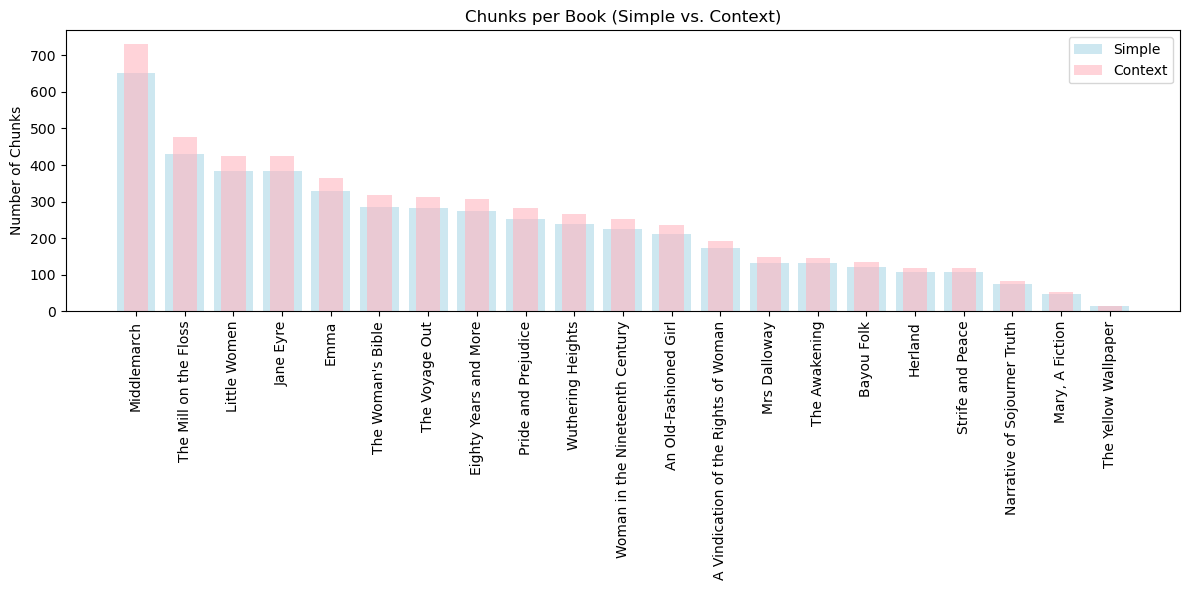

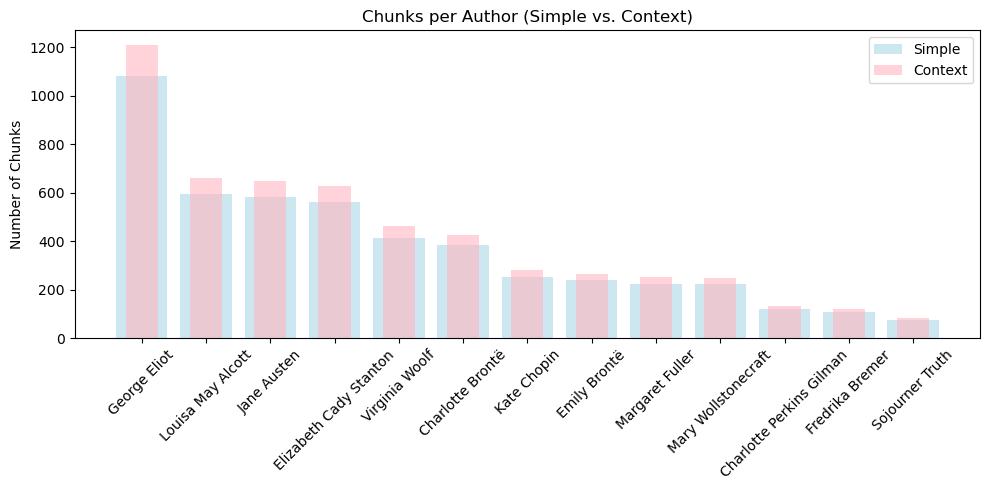

In [6]:
# compare chunk distribution

# group chunk counts by book
book_counts_simple = df["title"].value_counts().sort_values(ascending=False)
book_counts_context = df_context["title"].value_counts().reindex(book_counts_simple.index)

# group chunk counts by author
author_counts_simple = df["author"].value_counts().sort_values(ascending=False)
author_counts_context = df_context["author"].value_counts().reindex(author_counts_simple.index)

# plot: chunks per book (simple vs. context)
plt.figure(figsize=(12, 6))
plt.bar(book_counts_simple.index, book_counts_simple.values, alpha=0.6, label="Simple", color='lightblue')
plt.bar(book_counts_context.index, book_counts_context.values, alpha=0.6, label="Context", width=0.5, color='lightpink')
plt.xticks(rotation=90)
plt.ylabel("Number of Chunks")
plt.title("Chunks per Book (Simple vs. Context)")
plt.legend()
plt.tight_layout()
plt.show()

# plot: chunks per author (simple vs. context)
plt.figure(figsize=(10, 5))
plt.bar(author_counts_simple.index, author_counts_simple.values, alpha=0.6, label="Simple", color='lightblue')
plt.bar(author_counts_context.index, author_counts_context.values, alpha=0.6, label="Context", width=0.5, color='lightpink')
plt.xticks(rotation=45)
plt.ylabel("Number of Chunks")
plt.title("Chunks per Author (Simple vs. Context)")
plt.legend()
plt.tight_layout()
plt.show()

We group and compare the number of chunks per book and per author in both datasets. This helps us confirm:
- The chunking logic worked correctly (context version has more chunks)
- No major imbalances across books or authors
- We can normalize later results by chunk count if needed

The visual comparison also reveals which texts are longest (*Middlemarch*, *The Mill on the Floss*) and which authors are most prolific (Eliot, Alcott, Austen).

These patterns help us contextualize later results. For example:
- Emotion frequencies can be normalized per chunk or per author
- Books with higher chunk volume may have more diverse themes or emotional arcs
- Overlap in the context dataset can help topic models (like LDA or BERTopic) generate more coherent topics

## 4. Further Preprocessing

With the chunked text loaded, we now prepare two different versions of the data for separate modeling tasks:

1. **Thematic Modeling** – uncovering recurring topics and themes across books, authors, or time
2. **Emotion Classification** – detecting sentence-level emotions around gendered references

Each path requires specific preprocessing tailored to its modeling needs. We lemmatize, clean, and enrich the data with linguistic patterns to ensure model-ready inputs.

### 4.1 Preprocessing for Thematic Modeling

This pipeline prepares the data for topic modeling using approaches like TF-IDF, LDA, BERTopic, and Word2Vec.

We work with the **context-aware chunked dataset**, as overlapping windows preserve continuity across paragraphs — useful for models that depend on semantic flow (BERTopic).

Main steps include:
- Lemmatizing the text (lowercasing, removing stopwords and punctuation)
- Detecting bigram collocations (e.g., `get_married`)
- Extracting verb-object patterns for better thematic signals
- Saving per-book and per-author aggregated corpora for later modeling

All output files are saved in `data/processed/`, ready for use in Step 5.

While building this pipeline, we faced a few challenges: low-frequency bigrams often lacked meaning, and many character name pairs surfaced as collocations (e.g., `mr_darcy`, `jo_march`). We tuned frequency thresholds and added filters to improve semantic clarity. We also found that verb-object constructions helped recover more abstract or action-based themes, such as `fight_oppression` or `seek_freedom`, which were missed by bigram detection alone.

In [7]:
# preview structure
df_context[["title", "chunk"]].head(3)

title                                              chunk
0  Herland  CHAPTER 1.\nA Not Unnatural Enterprise This is...
1  Herland  few things that don’t. We three had a chance t...
2  Herland  I had understood, so I showed him a red and bl...

#### Lemmatization

In [8]:
# define a function to clean and lemmatize each chunk using spaCy
## lowercase, remove stop words, and lemmatize
def clean_and_lemmatize(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

In [9]:
tqdm.pandas()  # enable progress_apply for pandas

# apply lemmatization across all chunks
df_context["lemmatized_text"] = df_context["chunk"].progress_apply(clean_and_lemmatize)

100%|██████████| 5407/5407 [05:46<00:00, 15.58it/s]


In [10]:
# check lemmatization results
print("\nLemmatization Results Sample:")
print(df_context[["chunk", "lemmatized_text"]].head(5))

# deeper check of lemmatization
df_context["lemmatized_text"].head(10)


Lemmatization Results Sample:
                                               chunk  \
0  CHAPTER 1.\nA Not Unnatural Enterprise This is...   
1  few things that don’t. We three had a chance t...   
2  I had understood, so I showed him a red and bl...   
3  glass and squatted down to investigate. “Chemi...   
4  a dozen Montenegroes up and down these great r...   

                                     lemmatized_text  
0  chapter unnatural enterprise write memory unfo...  
1  thing chance join big scientific expedition ne...  
2  understand show red blue pencil carry ask yes ...  
3  glass squat investigate chemical sort tell spo...  
4  dozen montenegroe great range discuss hotly wa...  


0    chapter unnatural enterprise write memory unfo...
1    thing chance join big scientific expedition ne...
2    understand show red blue pencil carry ask yes ...
3    glass squat investigate chemical sort tell spo...
4    dozen montenegroe great range discuss hotly wa...
5    cliff waterfall yes ask jeff way course valuab...
6    find extremely clear idea country woman like u...
7    friend terry idea pretty woman game homely one...
8    triangle good speed cross base leave high moun...
9    hold peace long run upward gosh say terry woma...
Name: lemmatized_text, dtype: object

#### Detect and Inject Collocations

To improve the quality of our thematic modeling, we identify and inject **collocations** — frequent two-word phrases that carry more semantic weight than individual tokens.

These bigrams help models like LDA and BERTopic recognize **multi-word concepts** as unified thematic signals rather than separate, diluted words.

Steps:
- We extract statistically significant bigrams using **Pointwise Mutual Information (PMI)** with a frequency threshold (≥ 7)
- Filter and reformat them into joined tokens (e.g., `work_house` instead of `work house`)
- Apply the transformation across all chunks in the context-aware dataset

We also begin exploring **verb-object and verb-preposition pairs** (e.g., `take_responsibility`, `fight_against`) as a complementary pattern that reflects deeper thematic roles.

These enhancements result in cleaner, concept-rich inputs for topic models that follow.

In [11]:
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# find collocations in all lemmatized text
all_words = " ".join(df_context["lemmatized_text"]).split()
# find statitscally significant bigrams
finder = BigramCollocationFinder.from_words(all_words)

# set a minimum frequency threshold (5 appearances)
finder.apply_freq_filter(7)  # only keep bigrams that appear at least 5 times (eliminates rare but statistically significant bigrams)

# apply pointwise mutual information (PMI) to filter bigrams
top_bigrams = finder.nbest(BigramAssocMeasures.pmi, 500)

# convert to set for easy use
top_bigrams_set = set(["_".join(pair) for pair in top_bigrams])

In [12]:
# see top bigrams
print("Top 20 bigrams:")
for bigram in list(top_bigrams_set)[:20]:
    print("-", bigram)

Top 20 bigrams:
- tête_à
- wuthere_height
- miss_mayblunt
- straw_hat
- allen_chapter
- chapter_xxii
- pace_deck
- pocket_knife
- shalt_thou
- louisa_southworth
- game_chess
- miss_crocker
- thou_dost
- solar_system
- père_antoine
- anti_slavery
- gracechurch_street
- chapter_xxiii
- à_tête
- chapter_xii


In [13]:
def apply_collocations(text, bigrams_set):
    words = text.split()
    i = 0
    result = []
    while i < len(words) - 1:
        pair = f"{words[i]}_{words[i+1]}"
        if pair in bigrams_set:
            result.append(pair)
            i += 2
        else:
            result.append(words[i])
            i += 1
    if i == len(words) - 1:
        result.append(words[-1])
    return " ".join(result)

# apply to your text
df_context["lemmatized_text"] = df_context["lemmatized_text"].apply(lambda x: apply_collocations(x, top_bigrams_set))

Lower-frequency bigrams proved to be very bad in terms of interpretation. Instead, we see that after a frequency of 40 appearances, the quality improves. We will try to improve this even more using verb-based patterns, that will give us better collocations.

In [14]:
def extract_verb_phrases(text):
    doc = nlp(text)
    phrases = []
    for token in doc:
        if token.pos_ == "VERB":
            for child in token.children:
                if child.dep_ in ("dobj", "prep"):  # direct object or preposition
                    phrases.append(f"{token.lemma_}_{child.lemma_}")
    return phrases

df_context["verb_phrases"] = df_context["chunk"].progress_apply(extract_verb_phrases)

100%|██████████| 5407/5407 [05:50<00:00, 15.43it/s]


In [15]:
# preview updated text with bigrams
print("\nExample lemmatized text with bigrams:")
print(df_context["lemmatized_text"].iloc[0][:500])

# preview extracted verb-object/prep patterns
print("\nExample verb phrases:")
print(df_context["verb_phrases"].iloc[0][:20])


Example lemmatized text with bigrams:
chapter unnatural enterprise write memory unfortunately bring material carefully prepare different story book note carefully copy record firsthand description picture bad loss eye city park lot lovely view street building outside gorgeous garden important woman believe look description good come woman good description get rest world need know country say fear self appoint missionary trader land greedy expansionist push want tell fare bad find begin way classmate friend terry nicholson old nick g

Example verb phrases:
['write_from', 'bring_with', 'bring_material', 'have_bird’', 'have_eye', 'come_to', 'know_about', 'take_it', 'take_upon', 'tell_they', 'tell_that', 'find_it', 'call_he', 'call_with', 'know_year', 'have_in', 'have_deal', 'have_in', 'make_kind', 'fill_in']


#### Filter based on Model Granularity

In [19]:
# per-book aggregation
book_docs = df_context.groupby("title")["lemmatized_text"].apply(" ".join).reset_index()

# per-author (optional)
author_docs = df_context.groupby("author")["lemmatized_text"].apply(" ".join).reset_index()

In [20]:
print("Book Docs Size: ", book_docs.shape)
book_docs["lemmatized_text"].head(3)

Book Docs Size:  (21, 2)


0    introduction consider historic page view live ...
1    chapter polly arrive time station tom come oh ...
2    account creole agreeable afternoon late autumn...
Name: lemmatized_text, dtype: object

In [21]:
print("Author Docs Size: ", author_docs.shape)
author_docs["lemmatized_text"].head(3)

Author Docs Size:  (13, 2)


0    chapter possibility take walk day wander leafl...
1    chapter unnatural enterprise write memory unfo...
2    comment genesis exodus leviticus number deuter...
Name: lemmatized_text, dtype: object

#### Save Processed Corpora for Modeling

In [22]:
# for topic modeling (bigram + verb phrase extraction included)
df_context.to_csv(PROCESSED_DIR/ "thematic_chunks_context_bigram.csv", index=False)

# for per-book LDA/BERTOPIC
book_docs.to_csv(PROCESSED_DIR / "thematic_books.csv", index=False)

# for per-author LDA/BERTOPIC
author_docs.to_csv(PROCESSED_DIR / "thematic_authors.csv", index=False)

### 4.2 Preprocessing for Emotion Classification

This pipeline prepares the dataset for sentence-level emotion classification, using transformer models trained on labeled emotion datasets (e.g., GoEmotions).

We work with the **non-overlapping chunked dataset** to avoid repeated sentences and ensure clean segmentation.

Key preprocessing steps:
- Split each chunk into individual sentences using spaCy
- Filter for sentences that contain **gendered terms** or **feminine-coded names**
- Remove very short or noisy sentences
- Retain key metadata (book title, author, year, chunk_id) with each sentence

The result is a filtered dataset focused on feminine-referenced language, enabling us to study how **emotions are linguistically expressed around women** in 18th–20th century literature.

During this step, we had to carefully balance **coverage** and **precision**. A broad list of gendered terms and historical feminine names ensured recall, but led to some noisy matches. We used sentence length thresholds and manually reviewed samples to reduce false positives. Additionally, spaCy’s sentence segmentation sometimes misfired on archaic punctuation, so we included quality checks to validate splits before moving forward with classification.

In [79]:
# load spaCy English model
nlp = spacy.load("en_core_web_sm")

# load the cleaned, chunked data without overlaps
df_chunks = pd.read_csv(PROCESSED_DIR / "processed_book_chunks.csv")

# quick sanity check
print(f"Loaded {len(df_chunks)} chunks")
df_chunks.head()

Loaded 4852 chunks


chunk    title  \
0  CHAPTER 1.\nA Not Unnatural Enterprise This is...  Herland   
1  The expedition was up among the thousand tribu...  Herland   
2  It was early yet; we had just breakfasted; and...  Herland   
3  “Woman Country--up\nthere.” Then we were inter...  Herland   
4  It had a special covering of fitted armor, thi...  Herland   

                     author  year chunk_id  
0  Charlotte Perkins Gilman  1915   CP_001  
1  Charlotte Perkins Gilman  1915   CP_002  
2  Charlotte Perkins Gilman  1915   CP_003  
3  Charlotte Perkins Gilman  1915   CP_004  
4  Charlotte Perkins Gilman  1915   CP_005

In [80]:
tqdm.pandas()  

# function that segments text into sentences
def split_chunk_into_sentences(chunk):
    doc = nlp(chunk)
    return [sent.text.strip() for sent in doc.sents if sent.text.strip()]

# create a list of rows, one per sentence
all_sentences = []

# loop over all chunks with progress bar
for _, row in tqdm(df_chunks.iterrows(), total=len(df_chunks), desc="Splitting sentences"):
    sentences = split_chunk_into_sentences(row["chunk"])
    for sent in sentences:
        all_sentences.append({
            "sentence": sent,
            "title": row["title"],
            "author": row["author"],
            "year": row["year"],
            "chunk_id": row["chunk_id"]
        })

Splitting sentences: 100%|██████████| 4852/4852 [05:18<00:00, 15.21it/s]


In [81]:
# convert to DataFrame
df_sentences = pd.DataFrame(all_sentences)

# check result
print(f"Extracted {len(df_sentences)} sentences from {len(df_chunks)} chunks")
df_sentences.sample(5)

Extracted 114207 sentences from 4852 chunks


sentence  \
77243   He gave a short laugh, shook\nhands with her, ...   
71548   No, no,\nyou shall not deceive me: I know it t...   
22817   They rove about, mental and moral\nIshmaelites...   
103864  Turning, she gazed in through the gaping chasm...   
110477                 “You know I am a scoundrel, Jane?”   

                                  title             author  year chunk_id  
77243                      Little Women  Louisa May Alcott  1868   LM_041  
71548               Pride and Prejudice        Jane Austen  1813   JA_243  
22817   Woman in the Nineteenth Century    Margaret Fuller  1845   MF_050  
103864                       Bayou Folk        Kate Chopin  1894   KC_097  
110477                        Jane Eyre   Charlotte Brontë  1847   CB_250

In [90]:
# list of historically common feminine-coded words (1790-1925)
GENDERED_TERMS = [
    # pronouns
    "she", "her", "hers", "herself",
    # gender terms
    "woman", "women", "female",
    # titles
    "lady", "ladies", "miss", "missus", "madam", "ma'am",
    "mistress", "matron", "dame", "spinster", "widow",
    # family
    "mother", "mom", "mama", "mamma", "mum",
    "daughter", "sister", "aunt", "niece",
    "wife", "bride", "widow", "matron",
    # youth
    "girl", "girls", "maiden", "lass", "lassie", "belle",
    # ocupations and roles
    "governess", "nursemaid", "seamstress", "maid", "housekeeper",
    "servant", "companion", "chaperone", "schoolmistress",
    # religious and cultural references
    "nun", "virgin", "mother superior", "abbess",
    # terms of address or description
    "gentlewoman", "fair one", "damsel", "lady love", "coquette",
    "biddy", "wench", "heroine"
]

# taken from character list (see section 5.4)
FEMALE_NAMES = [
    "jo", "dorothea", "emma", "jane", "elizabeth", "mary", "amy", "maggie",
    "susanna", "rachel", "beth", "harriet", "lucy", "catherine", "meg",
    "isabella", "rosamond", "hannah", "helen", "susan", "sally", "cathy",
    "lizzy", "ellen", "evelyn", "kitty", "miss bates", "diana", "bessie",
    "lady catherine", "miss", "astrid", "clarissa", "jane fairfax"
]

In [91]:
# lowercase everything for case-insensitive matching
df_sentences["sentence_lower"] = df_sentences["sentence"].str.lower()

# merge the lists for matching
gender_indicators = GENDERED_TERMS + FEMALE_NAMES

# build a regex pattern using word boundaries for exact matches
pattern = r'\b(' + '|'.join(re.escape(term) for term in gender_indicators) + r')\b'

# apply regex to filter sentences that include any gendered term or female name
df_gendered = df_sentences[df_sentences["sentence_lower"].str.contains(pattern, regex=True)]

# drop helper column after filtering
df_gendered = df_gendered.drop(columns=["sentence_lower"])

# summary
print(f"{len(df_gendered)} sentences matched gendered terms or names (out of {len(df_sentences)} total)")

45778 sentences matched gendered terms or names (out of 114207 total)


In [92]:
# remove sentences under 5 words (optional threshold)
df_gendered["word_count"] = df_gendered["sentence"].str.split().str.len()
df_filtered = df_gendered[df_gendered["word_count"] >= 5].copy()

print(f"Remaining after length filter: {len(df_filtered)}")
df_filtered.drop(columns=["word_count"], inplace=True)

Remaining after length filter: 44264


In [98]:
# placeholder label column
df_filtered["inferred_emotion"] = ""

# columns: sentence, label, title, author, year, chunk_id
df_filtered.head()

sentence    title  \
4   We had some\nbird’s-eyes of the cities and par...  Herland   
6   Descriptions aren’t any good\nwhen it comes to...  Herland   
35  And as we got farther and farther upstream, in...  Herland   
36  “Up yonder,” “Over there,” “Way up”--was all t...  Herland   
39  But there were tales of long ago, when some br...  Herland   

                      author  year chunk_id inferred_emotion  
4   Charlotte Perkins Gilman  1915   CP_001                   
6   Charlotte Perkins Gilman  1915   CP_001                   
35  Charlotte Perkins Gilman  1915   CP_002                   
36  Charlotte Perkins Gilman  1915   CP_002                   
39  Charlotte Perkins Gilman  1915   CP_002

In [100]:
df_filtered.to_csv(str(PROCESSED_DIR / "emotion_sentences.csv"), index=False)
print(f"Saved gendered emotional sentences)

Saved gendered emotional sentences to: /Users/emmamora/Documents/GitHub/feminist_nlp/data/processed/processed_book_chunks.csv


## 5. Thematic Modeling

In this step, we use multiple unsupervised modeling techniques to uncover key themes across the corpus. The goal is to extract interpretable patterns of meaning — from concrete topics like `marriage` or `education` to more abstract concepts like `freedom`, `virtue`, or `womanhood`.

We rely on the preprocessed, lemmatized, and bigram-enriched dataset (`thematic_chunks_context_bigram.csv`) created in Step 4.1. This version captures both context and linguistic structure, which helps improve model coherence.

We explore several modeling approaches:
- **TF-IDF** to extract high-value terms per book or author
- **LDA (Latent Dirichlet Allocation)** for unsupervised topic modeling
- **Word2Vec** to analyze semantic similarity and cluster thematically related words
- **BERTopic** to combine contextual embeddings with clustering
- **KWIC (Keyword-in-Context)** to inspect how core feminist concepts appear in surrounding text

Each method offers a different perspective: TF-IDF highlights discriminative vocabulary, LDA and BERTopic reveal latent themes, Word2Vec shows lexical proximity, and KWIC ties abstract themes back to concrete usage.

All models operate on either chunk-, book-, or author-level corpora, and their outputs are saved in `data/processed/` and `reports/figures/`.

### 5.1 TF-IDF Term Extraction

TF-IDF (Term Frequency–Inverse Document Frequency) is a simple but powerful method for identifying **keywords that are distinctive to each document** — in this case, each book or author.

We apply TF-IDF to the lemmatized + bigrammed text to surface terms that stand out across the corpus. This helps us identify dominant themes like `get_married`, `go_school`, or `woman_right` that are central to specific authors or eras.

We compute TF-IDF in two modes:
- **Per-book**: to detect the most distinctive terms in individual texts
- **Per-author**: to understand vocabulary preferences and thematic focus across authors

Challenges we faced:
- **Balancing specificity and generality**: Some terms (e.g., `said`, `know`) were frequent but thematically weak. We tuned `min_df` and `max_df` values to filter out overly common or rare tokens.
- **Name-heavy outputs**: Without filtering, author and character names dominated top terms. This was partially mitigated by using lemmatized and collocation-injected text.
- **Visualization clarity**: We limited the number of top terms and focused on selected books/authors to avoid overcrowded charts.

This step surfaces key thematic terms per book or author and shares the same preprocessed input used later for Word2Vec and BERTopic.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# load pre-processed data
books_df = pd.read_csv(PROCESSED_DIR / "thematic_books.csv")
authors_df = pd.read_csv(PROCESSED_DIR / "thematic_authors.csv")

In [24]:
# define a TF-IDF vectorizer
# we include unigrams and bigrams (from preprocessed lemmatized_text)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.9)

In [25]:
# fit tf-idf on book texts
tfidf_books = vectorizer.fit_transform(books_df["lemmatized_text"])
tfidf_feature_names = vectorizer.get_feature_names_out()

# convert to dataframe for inspection
tfidf_books_df = pd.DataFrame(tfidf_books.toarray(), columns=tfidf_feature_names)
tfidf_books_df["title"] = books_df["title"]

In [26]:
tfidf_books_df.head(5)

aaron     aback   abandon  abandon field  abandon scheme  \
0  0.000000  0.000000  0.003132       0.000000             0.0   
1  0.000000  0.000558  0.000000       0.000000             0.0   
2  0.000000  0.000000  0.014223       0.007328             0.0   
3  0.005827  0.000000  0.004170       0.000000             0.0   
4  0.000000  0.000000  0.000000       0.000000             0.0   

   abandon speculation  abandon tear  abandonment     abase  abasement  ...  \
0             0.000000           0.0          0.0  0.003228   0.002917  ...   
1             0.000000           0.0          0.0  0.000000   0.000000  ...   
2             0.003664           0.0          0.0  0.000000   0.000000  ...   
3             0.000000           0.0          0.0  0.000000   0.000000  ...   
4             0.000000           0.0          0.0  0.000000   0.000000  ...   

       zest    zigzag  zillah  zion  zion haughty  zodiac      zone  zoo  \
0  0.006128  0.000000     0.0   0.0           0.0     0.0  0.002314  0.0   
1  0.000000  0.000000     0.0   0.0           0.0     0.0  0.000000  0.0   
2  0.002319  0.002627     0.0   0.0           0.0     0.0  0.000000  0.0   
3  0.005440  0.001540     0.0   0.0           0.0     0.0  0.001540  0.0   
4  0.000000  0.000649     0.0   0.0           0.0     0.0  0.000000  0.0   

   zoological      à_la  
0    0.000000  0.000000  
1    0.000000  0.000000  
2    0.000000  0.012154  
3    0.002149  0.001782  
4    0.000000  0.000000  

[5 rows x 97673 columns]

In [27]:
def get_top_terms(tfidf_row, feature_names, top_n=10):
    top_indices = np.argsort(tfidf_row)[-top_n:]
    return [feature_names[i] for i in reversed(top_indices)]

books_df["top_terms"] = tfidf_books_df.drop(columns=["title"]).apply(
    lambda row: get_top_terms(row.values, tfidf_feature_names), axis=1
)
books_df[["title", "top_terms"]].head(5)

title  \
0  A Vindication of the Rights of Woman   
1                 An Old-Fashioned Girl   
2                            Bayou Folk   
3                 Eighty Years and More   
4                                  Emma   

                                           top_terms  
0  [sex, render, understand young, rousseau, fema...  
1  [polly, toll, fanny, maud, fan, shaw, grandma,...  
2  [dat, de, yielding, bayou, la_folle, madame, y...  
3  [anthony, convention, suffrage, stanton, new_y...  
4  [emma, westminster cathedral, harriet, woodenn...

In [28]:
# fit tf-idf on author texts
tfidf_authors = vectorizer.fit_transform(authors_df["lemmatized_text"])
tfidf_authors_df = pd.DataFrame(tfidf_authors.toarray(), columns=vectorizer.get_feature_names_out())

# extract top terms per author
authors_df["top_terms"] = tfidf_authors_df.apply(
    lambda row: get_top_terms(row.values, vectorizer.get_feature_names_out()), axis=1
)
authors_df[["author", "top_terms"]].head(5)

author                                          top_terms
0          Charlotte Brontë  [rochester, jane, fairfax, adèle, mrs fairfax,...
1  Charlotte Perkins Gilman  [terry, motherhood, big, john, baby, civilizat...
2    Elizabeth Cady Stanton  [unto, bible, moses, israel, say unto, thy, th...
3              Emily Brontë  [catherine, edgar, joseph, nelly, wuthere_heig...
4           Fredrika Bremer  [susanna, norway, mountain, whilst, sweden, no...

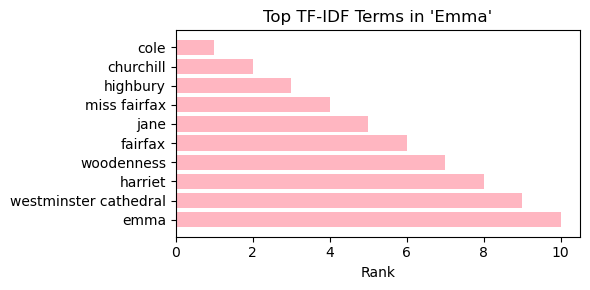

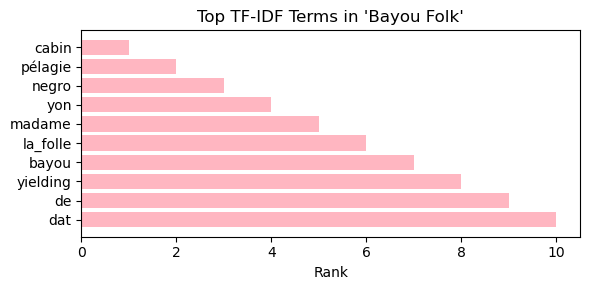

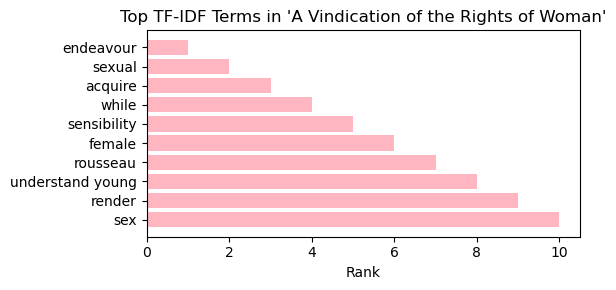

In [29]:
import matplotlib.pyplot as plt

# choose a few representative titles
selected_titles = ["Emma", "Bayou Folk", "A Vindication of the Rights of Woman"]

for title in selected_titles:
    top_terms = books_df[books_df["title"] == title]["top_terms"].values[0]
    plt.figure(figsize=(6, 3))
    plt.barh(top_terms[::-1], range(1, len(top_terms) + 1), color="lightpink")
    plt.title(f"Top TF-IDF Terms in '{title}'")
    plt.xlabel("Rank")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

The bar plots above show the **Top TF-IDF Terms** in *Emma* (Jane Austen) and *Bayou Folk* (Kate Chopin), highlighting words that are statistically prominent in each text relative to the rest of the corpus.

These TF-IDF scores reveal several insights:

- In *Emma*, top terms like `emma`, `harriet`, `fairfax`, and `highbury` are tightly linked to the novel’s **character network** and **social geography**. The prominence of names and places reflects Austen’s close focus on interpersonal dynamics and domestic space.
  
- In *Bayou Folk*, top terms like `la_folle`, `negro`, `cabin`, and `bayou` point to **regional dialect**, **racialized settings**, and **Louisiana vernacular**, signaling the text’s embeddedness in Southern realism and post-Reconstruction themes.

This contrast reflects how different authors encode thematic meaning:
- Austen’s vocabulary is centered on relationships, propriety, and social status
- Chopin’s vocabulary foregrounds landscape, race, and cultural hybridity

Importantly, this TF-IDF-based vocabulary also helps inform:
- **Downstream modeling** (Word2Vec, BERTopic) by identifying high-value tokens
- **KWIC term selection**, especially when building feminist theme categories
- **Interpretive context**, such as how location or identity influences emotion framing 

By surfacing these core terms, TF-IDF gives us a first layer of **text-specific semantic fingerprinting**, before we model larger patterns across the corpus.

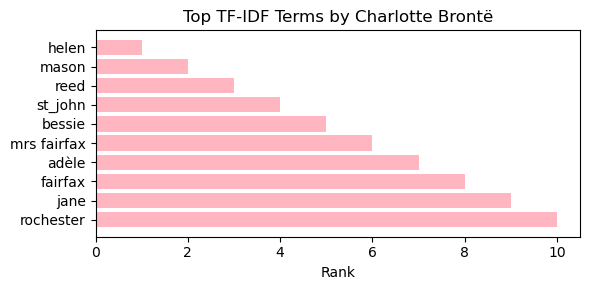

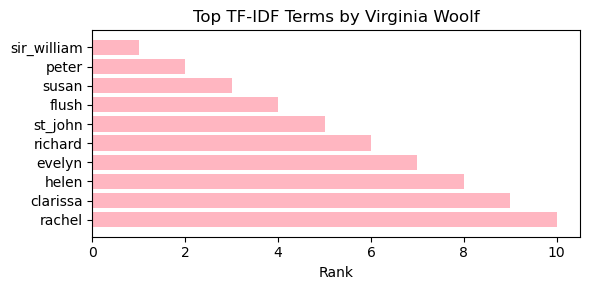

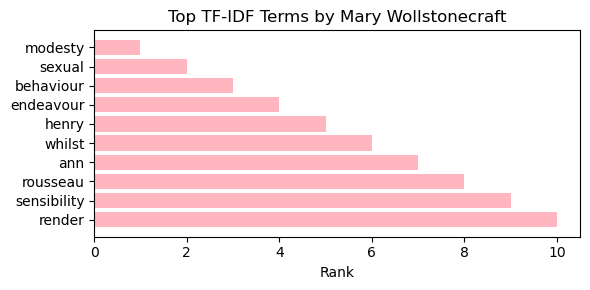

In [30]:
selected_authors = ["Charlotte Brontë", "Virginia Woolf", "Mary Wollstonecraft"]

for author in selected_authors:
    top_terms = authors_df[authors_df["author"] == author]["top_terms"].values[0]
    plt.figure(figsize=(6, 3))
    plt.barh(top_terms[::-1], range(1, len(top_terms) + 1), color="lightpink")
    plt.title(f"Top TF-IDF Terms by {author}")
    plt.xlabel("Rank")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

These plots show the **Top TF-IDF Terms** for three central authors in the corpus: Charlotte Brontë, Virginia Woolf, and Mary Wollstonecraft. Each bar highlights words that are statistically prominent in that author’s work relative to the rest of the dataset.

**Author-Level Observations**
- **Charlotte Brontë**:
  - Character names like `rochester`, `jane`, `adèle`, and `mrs fairfax` dominate the list, reflecting the narrative structure of *Jane Eyre*.
  - The frequency of family-related and domestic terms suggests a strong focus on **personal development**, **social roles**, and **emotional relationships** — key themes in Brontë’s fiction.
- **Virginia Woolf**:
  - Terms such as `clarissa`, `rachel`, `richard`, and `peter` point to Woolf’s use of multiple perspectives and her interest in **psychological depth**.
  - The presence of characters across several works illustrates her emphasis on **stream-of-consciousness narration** and interior experience.
- **Mary Wollstonecraft**:
  - Her vocabulary is more conceptual, with terms like `virtue`, `modesty`, `sensibility`, and `behaviour`.
  - The inclusion of `rousseau` signals the **philosophical and argumentative nature** of *A Vindication of the Rights of Woman*, as she responds directly to Enlightenment discourse.

**Relevance to the Broader Analysis**

These TF-IDF profiles offer a quick way to understand each author’s thematic focus:
- Brontë emphasizes character and emotional development.
- Woolf focuses on internal states and shifting subjectivity.
- Wollstonecraft foregrounds argument, values, and ideology.

TF-IDF, while simple, offers a strong starting point for interpreting style and content across the corpus.

### 5.2 LDA Topic Modeling

Latent Dirichlet Allocation (LDA) is an unsupervised modeling technique that discovers **groups of words that frequently co-occur**, suggesting latent "topics" across the corpus.

We use the Gensim implementation of LDA on our chunked, lemmatized, bigram-injected dataset. Each chunk is assigned a dominant topic, and we visualize topic distributions per book and author.

Challenges and key steps:
- **Overfitting to character names**: Early LDA results were dominated by named entities (`jo`, `emma`, `lydgate`). Using bigrams and verb-object patterns helped rebalance the topic space toward themes.
- **Choosing number of topics (`num_topics`)**: We tested different values and selected 10 for interpretability across books and authors.
- **Mapping topics**: LDA returns word distributions, not labels. We manually interpreted each topic based on top terms and created provisional labels (e.g., “Domestic Space”, “Romantic Intensity”).

The result is a set of interpretable themes that span books and authors — useful for analyzing stylistic variation, ideological focus, and shifts over time.

In [31]:
import gensim

In [34]:
import gensim
from gensim import corpora, models

# load preprocessed data (chunk-level)

df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")

# use lemmatized + bigrammed text column
texts = df["lemmatized_text"].apply(lambda x: x.split()).tolist()

In [35]:
# build dictionary (word → id mapping)
dictionary = corpora.Dictionary(texts)

# filter extremes
dictionary.filter_extremes(no_below=5, no_above=0.5)

# create bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in texts]

In [36]:
# train LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,         # you can tune this
    random_state=42,
    passes=10,
    per_word_topics=True
)

In [37]:
# print top terms for each topic
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx + 1}:")
    print(topic)
    print()

Topic 1:
0.007*"room" + 0.006*"old" + 0.006*"stand" + 0.006*"day" + 0.005*"sit" + 0.005*"door" + 0.005*"hand" + 0.005*"see" + 0.005*"woman" + 0.004*"house"

Topic 2:
0.019*"mr" + 0.015*"fred" + 0.011*"mary" + 0.011*"mrs" + 0.011*"tell" + 0.010*"get" + 0.009*"o" + 0.009*"money" + 0.009*"father" + 0.009*"want"

Topic 3:
0.033*"mr" + 0.018*"lydgate" + 0.012*"mrs" + 0.010*"rosamond" + 0.010*"bulstrode" + 0.007*"thing" + 0.005*"feel" + 0.005*"celia" + 0.004*"vincy" + 0.004*"middlemarch"

Topic 4:
0.013*"woman" + 0.011*"mind" + 0.011*"susanna" + 0.009*"heart" + 0.009*"love" + 0.008*"virtue" + 0.008*"nature" + 0.007*"reason" + 0.006*"affection" + 0.006*"beauty"

Topic 5:
0.006*"life" + 0.005*"find" + 0.004*"feel" + 0.004*"year" + 0.004*"give" + 0.004*"woman" + 0.004*"mind" + 0.004*"friend" + 0.004*"day" + 0.004*"feeling"

Topic 6:
0.007*"love" + 0.007*"eye" + 0.006*"feel" + 0.006*"long" + 0.006*"hand" + 0.006*"life" + 0.005*"day" + 0.005*"see" + 0.005*"leave" + 0.005*"heart"

Topic 7:
0.015*"

The table below summarizes the **10 topics identified by LDA**, based on their top words and inferred thematic focus. LDA works by detecting clusters of words that frequently co-occur across documents — in this case, chunked segments of feminist texts.

| **Topic** | **Top Words** | **Probable Theme** |
|-----------|---------------|---------------------|
| **1** | room, stand, door, sit, woman, house | **Domestic space & physical environment** — scenes of home life and interior detail |
| **2** | mr, fred, mary, mrs, money, father, want | **Family and financial dynamics** — interpersonal negotiation, desire, social position |
| **3** | mr, lydgate, rosamond, middlemarch, bulstrode | **Middlemarch-specific** — characters and themes from Eliot’s novel |
| **4** | woman, mind, love, virtue, affection, beauty | **Philosophy, inner life, and feminine virtue** — idealism, character, and emotion |
| **5** | life, feel, year, friend, give, day | **Reflection and connection** — passages about time, emotion, and relational ties |
| **6** | love, eye, see, hand, leave, heart | **Romantic and emotional intensity** — expressions of longing and closeness |
| **7** | jo, polly, girl, amy, tom, laurie, meg | **Girlhood and relationships** — characters from *Little Women*, *An Old-Fashioned Girl* |
| **8** | mr, mrs, maggie, jane, emma, miss, elizabeth | **Named female leads** — Austen/Brontë characters and their social surroundings |
| **9** | woman, child, god, wife, lord, mother | **Morality, religion, and womanhood** — sacred roles and societal expectations |
| **10** | dorothea, casaubon, brooke, husband, young | **Dorothea Brooke & marriage conflict** — specific to *Middlemarch*'s plot arc |

Some topics are **clearly tied to specific texts** or characters — e.g., Topics 3 and 10 are centered on *Middlemarch*, while Topic 7 picks up characters from *Little Women*. Others are **more abstract and cross-cutting**, like Topic 4 on “virtue and inner life,” or Topic 6’s focus on emotion and intimacy.

This blend of **book-specific and thematic topics** is useful for downstream interpretation:
- We can examine **how these topics appear across different authors or decades**
- We can link them to **emotion predictions** to see how themes like “motherhood” or “freedom” are emotionally framed
- We can extract **KWIC contexts** to analyze how certain key words operate within narrative passages

Overall, this topic model confirms that LDA is picking up both **narrative identities (characters, plots)** and **ideological patterns (morality, affection, domesticity)** — which aligns with the broader goals of our feminist literary analysis.

In [38]:
# assign dominant topic per chunk
def get_dominant_topic(doc_bow):
    topic_probs = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    topic_probs_sorted = sorted(topic_probs, key=lambda x: -x[1])
    return topic_probs_sorted[0][0], topic_probs_sorted[0][1]  # topic_id, probability

# apply to all chunks
topic_assignments = [get_dominant_topic(doc) for doc in corpus]
df["topic_id"] = [topic[0] for topic in topic_assignments]
df["topic_prob"] = [topic[1] for topic in topic_assignments]

In [39]:
# extract top words for each topic
topic_terms = {
    i: ", ".join([term.split("*")[1].strip().strip('"') 
                  for term in lda_model.print_topics(num_words=6)[i][1].split(" + ")])
    for i in range(lda_model.num_topics)
}

# map back to df
df["topic_label"] = df["topic_id"].map(topic_terms)

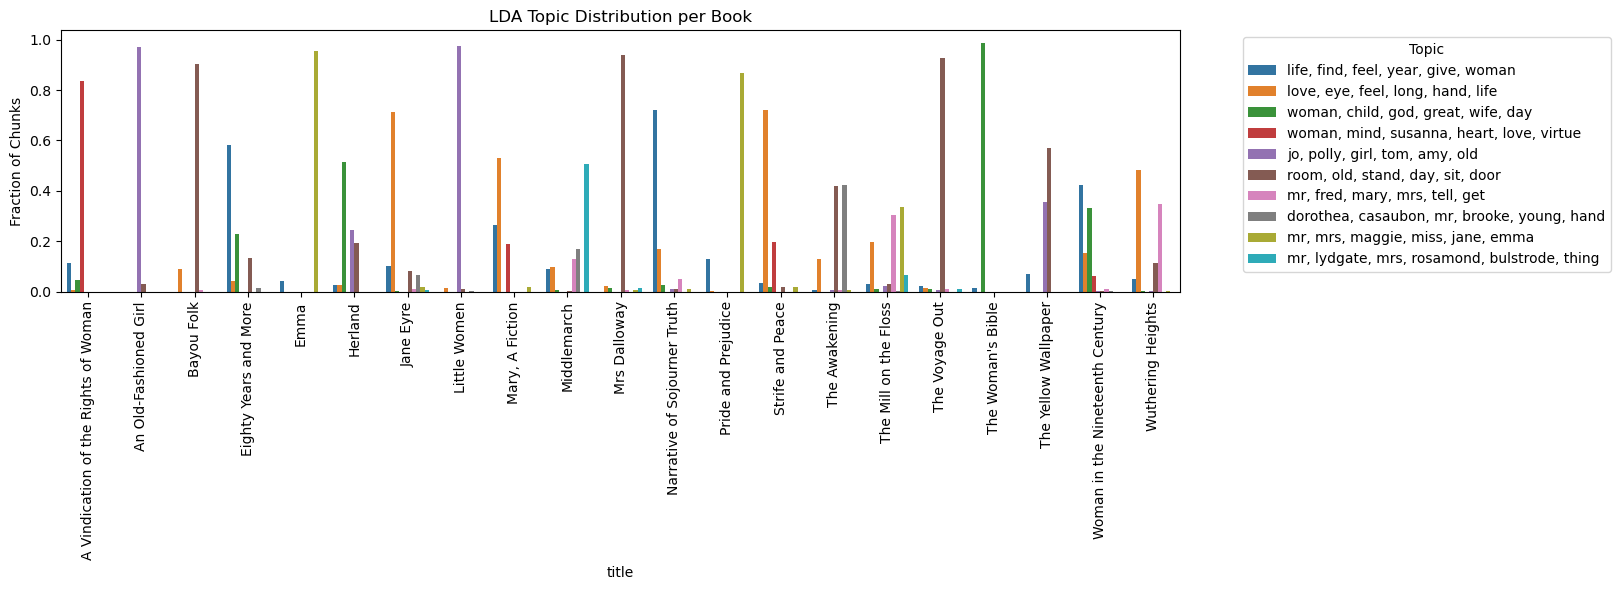

In [40]:
import seaborn as sns

# group by book and topic
topic_dist = df.groupby(["title", "topic_label"]).size().reset_index(name="count")

# normalize within each book
topic_dist["fraction"] = topic_dist.groupby("title")["count"].transform(lambda x: x / x.sum())

# plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=topic_dist,
    x="title", y="fraction", hue="topic_label"
)
plt.xticks(rotation=90)
plt.title("LDA Topic Distribution per Book")
plt.ylabel("Fraction of Chunks")
plt.tight_layout()
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The bar chart below shows the **fraction of text chunks per book** that are assigned to each LDA topic. This gives us a comparative view of **thematic concentration vs. diversity** across the corpus.

- Some texts are **highly dominated by a single topic**:
  - *A Vindication of the Rights of Woman* is mostly associated with the **“virtue/ideology”** topic, consistent with its philosophical essay style.
  - *An Old-Fashioned Girl* is almost entirely covered by the **“girlhood and domestic life”** topic, reflecting its narrow thematic focus.

- Others exhibit **greater thematic spread**:
  - *Eighty Years and More* and *Middlemarch* show a **more balanced distribution** across several topics, indicating richer structural or ideological layering.
  - This suggests these texts explore a wider range of feminist experiences — from personal reflection to public life.

- **Book-specific vs. cross-cutting topics**:
  - Topics dominated by **named characters** (e.g., Dorothea, Lydgate, Jo) tend to be concentrated in the books they originate from.
  - In contrast, broader themes like **love**, **womanhood**, and **domestic life** recur across multiple works, hinting at shared feminist concerns across authors and genres.

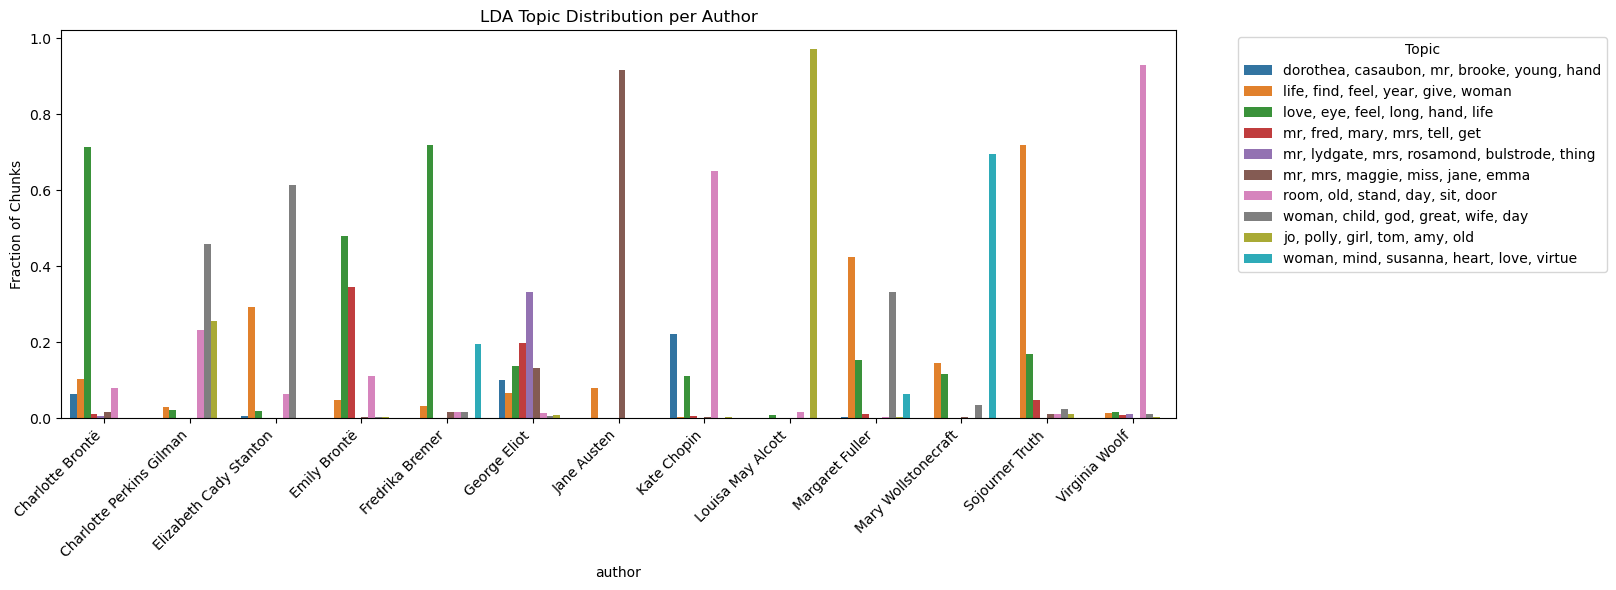

In [42]:
# group by author and topic
author_topic_dist = df.groupby(["author", "topic_label"]).size().reset_index(name="count")

# normalize within each author
author_topic_dist["fraction"] = author_topic_dist.groupby("author")["count"].transform(lambda x: x / x.sum())

# plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=author_topic_dist,
    x="author", y="fraction", hue="topic_label"
)
plt.xticks(rotation=45, ha="right")
plt.title("LDA Topic Distribution per Author")
plt.ylabel("Fraction of Chunks")
plt.tight_layout()
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The bar chart below visualizes the **distribution of LDA topics per author**, showing what proportion of each author’s text chunks were associated with each topic. This helps compare **individual thematic focus** with **shared discursive patterns** across the corpus.

- **Some authors are heavily concentrated in a single topic**:
  - *Jane Austen* is almost entirely associated with the **character-centered relationships** topic, highlighting her narrative focus on social interaction and dialogue.
  - *Louisa May Alcott* is dominated by the **girlhood and domesticity** theme, consistent with her portrayal of youth and moral development.
  
- **Others span multiple topics**:
  - *Mary Wollstonecraft* and *Elizabeth Cady Stanton* show thematic variety — including virtue, religion, womanhood, and reflection — pointing to a broader intellectual scope typical of feminist nonfiction.
  - *George Eliot* also covers a more balanced mix of personal, philosophical, and narrative-focused themes.

- **Shared and exclusive themes**:
  - Topics like **love, inner life, and virtue** recur across many authors, indicating **common thematic ground** in feminist literature of the period.
  - Conversely, character-specific or narrative-heavy topics (e.g., Dorothea or Jo March) remain tied to the books they originate from, showing how **genre and narrative style** influence topic distribution.

In [44]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# prepare pyLDAvis visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# show in notebook (or save if running outside)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.033878 -0.123169       1        1  14.557256
4     -0.107801  0.082531       2        1  13.202455
0      0.124510 -0.160547       3        1  13.134104
7      0.073259  0.092206       4        1  12.133098
6      0.086452 -0.056869       5        1  11.481785
8     -0.166097 -0.042746       6        1  11.212423
2      0.025873  0.123561       7        1   7.745779
1      0.112806  0.103663       8        1   6.469278
9      0.053565  0.016637       9        1   5.658722
3     -0.236445 -0.035268      10        1   4.405100, topic_info=           Term         Freq        Total Category  logprob  loglift
483          mr  7846.000000  7846.000000  Default  30.0000  30.0000
114       woman  5860.000000  5860.000000  Default  29.0000  29.0000
8582   dorothea  1404.000000  1404.000000  Default  28.0000  28.0000
12273        jo  1728.000000  1728.000000  Default  27.0000  27.0000
12394   lydgate  1338.000000  1338.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
654       sense   156.793235  1058.989969  Topic10  -5.6077   1.2123
437     society   137.248140   521.638854  Topic10  -5.7408   1.7872
1115       true   149.713693   907.495303  Topic10  -5.6539   1.3204
116       world   152.209241  1712.523445  Topic10  -5.6373   0.7019
559      mother   149.633520  2454.080412  Topic10  -5.6544   0.3251

[814 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
9864       9  0.975317         abbot
7423       2  0.950046  abolitionist
7116       6  0.991020       abraham
2686       1  0.018118       acquire
2686       2  0.060394       acquire
...      ...       ...           ...
372        8  0.073867         young
372        9  0.127696         young
372       10  0.043220         young
12560      1  0.013166       zoraïde
12560      3  0.974252       zoraïde

[2681 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 8, 7, 9, 3, 2, 10, 4])

This interactive visualization offers a useful way to explore the LDA topic model by projecting topics into a 2D semantic space using multidimensional scaling.

- **Topic distinctiveness**: Topics are clearly separated in space, indicating that the model has captured meaningful thematic differences.
- **Topic prevalence**: The size of each circle represents how frequent that topic is across the corpus — with Topic 1 emerging as the most dominant, followed by Topics 2 and 3.
- **Term interpretation**: Selecting a topic displays its most representative terms in the right-hand panel. For example, Topic 10 is linked to *Middlemarch*, as shown by terms like “dorothea” and “casaubon.”
- **Diagnostic value**: This view helps assess topic overlap and coherence, and can inform decisions about adjusting the number of topics (`num_topics`).

In [46]:
# create reports/figures folder if it doesn't exist
(REPO_DIR / "reports" / "figures").mkdir(parents=True, exist_ok=True)

pyLDAvis.save_html(vis, str(REPO_DIR / "reports" / "figures" / "lda_topics.html"))

### 5.3 Word Embedding Clustering

To explore the latent semantic structure among thematic terms, we trained a **Word2Vec** model on the lemmatized + bigram-injected text chunks. Word2Vec learns **vector representations of words** based on their surrounding context, so that words with similar meanings or functions appear close together in the resulting vector space.

**Training & Optimization**
- Trained Word2Vec with: `vector_size = 150`, `window = 7`, `min_count = 10`, `epochs = 30`
- Used our enriched, cleaned dataset to avoid noise from rare or functionally weak tokens
- Clustered the resulting vectors using **KMeans (k=10)**
- Reduced dimensionality with **UMAP** for clearer visual separation (PCA was tested but less interpretable)

**Challenges we addressed:**
- **High-frequency verbs** (`say`, `come`, `look`) cluttered the embedding space. We increased `min_count` and filtered weak tokens to emphasize thematic terms.
- **Dense or uninterpretable PCA plots** made clustering hard to analyze. UMAP gave more meaningful and separable projections.
- **Low-value clusters** persisted until we combined bigrams and frequency filtering. We manually reviewed cluster contents and focused on high-quality thematic groupings.

**Visual & Semantic Interpretation**
The final UMAP projection revealed several coherent clusters. Below are representative themes by cluster:

- **Cluster 0:** Domestic presence — `mr, mrs, sit, room, home, place`
- **Cluster 1:** Moral philosophy — `virtue, beauty, truth, sex`
- **Cluster 2:** Emotional/internal states — `love, heart, soul, god, dorothea`
- **Cluster 3:** Social/gender roles — `man, husband, wife, family`
- **Cluster 4:** Embodied perception — `eye, hand, face, arm, amy`
- **Cluster 5:** Event & narrative — `call, appear, story, dead`
- **Cluster 6:** Institutions & doctrine — `woman, lord, law, church`
- **Cluster 7:** Utility/action verbs — `say, think, find, know`
- **Cluster 8:** Romantic imagery — `music, sweet, air, heaven`
- **Cluster 9:** Movement/setting — `door, run, water, fall, watch`

These clusters reveal how feminist literature organizes meaning around domains like domestic life, emotion, virtue, and social power.

**Outputs Saved**
- `word2vec_feminist.model`: Trained Word2Vec model
- `word2vec_umap_clustered.csv`: 2D word coordinates with cluster assignments

These embeddings now serve as a **semantic backbone** for:
- Thematic exploration
- Lexicon construction
- Mapping emotional or ideological language across time and authorship

In [47]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [48]:
# path to your processed thematic chunks
df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")

# tokenize lemmatized + bigrammed text
tokenized_chunks = df["lemmatized_text"].apply(lambda x: x.split()).tolist()

In [50]:
w2v_model = Word2Vec(
    sentences=tokenized_chunks,
    vector_size=150,      # dimensionality of vectors
    window=7,             # context window
    min_count=3,          # ignore words with total frequency < 5
    workers=4,
    epochs=30,
    seed=42
)

In [51]:
# extract word vectors and vocabulary
word_vectors = w2v_model.wv
vocab = word_vectors.index_to_key
X = word_vectors[vocab]

In [53]:
# word similarity checks
w2v_model.wv.most_similar("marriage", topn=10)

[('union', 0.5199782848358154),
 ('matrimony', 0.46421071887016296),
 ('divorce', 0.45170852541923523),
 ('desirable', 0.4464401304721832),
 ('polygamy', 0.43569257855415344),
 ('parentage', 0.4347919523715973),
 ('matrimonial', 0.43410083651542664),
 ('elopement', 0.4259294271469116),
 ('suitor', 0.41845059394836426),
 ('alliance', 0.41809460520744324)]

In [54]:
# check for other words
w2v_model.wv.most_similar("work", topn=10)

[('accomplish', 0.42424723505973816),
 ('labor', 0.41537338495254517),
 ('task', 0.3924129009246826),
 ('writing', 0.3348401188850403),
 ('busy', 0.3268263339996338),
 ('sewing', 0.3203238844871521),
 ('research', 0.31936317682266235),
 ('fare', 0.30022796988487244),
 ('employment', 0.2895869314670563),
 ('toil', 0.28839442133903503)]

In [55]:
w2v_model.wv.most_similar(positive=["woman", "king"], negative=["man"])

[('vashti', 0.5072859525680542),
 ('esther', 0.4771440029144287),
 ('adonijah', 0.46248549222946167),
 ('prince', 0.4443299174308777),
 ('queen', 0.44399547576904297),
 ('bath_sheba', 0.44316503405570984),
 ('ahasueru', 0.43752163648605347),
 ('jael', 0.4312528669834137),
 ('shushan', 0.4274780750274658),
 ('judges', 0.4199732840061188)]

In [56]:
NUM_CLUSTERS = 10

kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# store in DataFrame for inspection
clusters_df = pd.DataFrame({
    "word": vocab,
    "cluster": labels
})

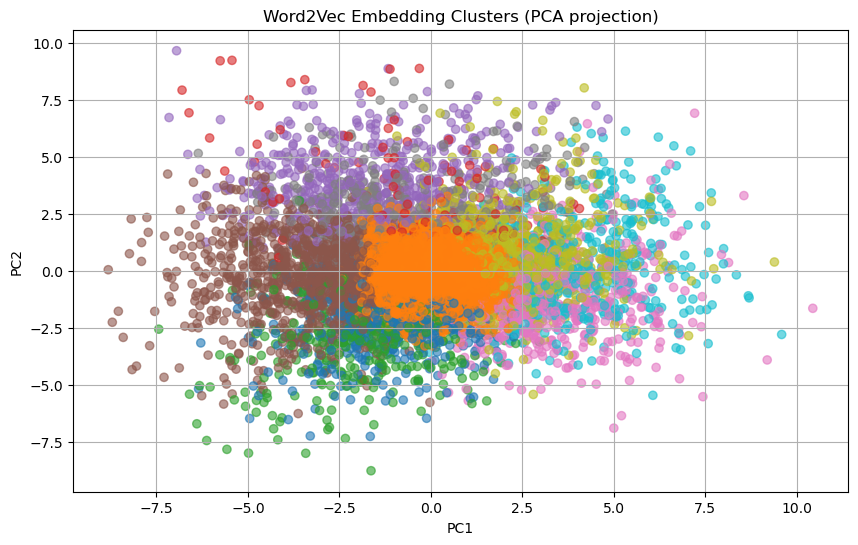

In [58]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("Word2Vec Embedding Clusters (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

This PCA projection visualizes the clustered Word2Vec embeddings, with each point representing a word and colors denoting KMeans cluster assignments.

- **Dense central region**: A large concentration of points near the origin suggests a core of high-frequency or semantically broad words, which tend to dominate across the corpus.
- **Overlap between clusters**: Many clusters show significant spatial overlap, indicating that **PCA does not always provide clear thematic separation**. This limitation motivated our switch to UMAP for more interpretable visualization.
- **Initial structure check**: Despite the visual noise, this view is helpful for checking that word vectors form coherent groups and that the model has not collapsed into a uniform embedding space.

In [59]:
# sort and preview words by cluster
for i in range(NUM_CLUSTERS):
    words = clusters_df[clusters_df["cluster"] == i]["word"].tolist()
    print(f"\nCluster {i}:")
    print(", ".join(words[:15]))  # show top 15


Cluster 0:
call, book, read, country, church, general, story, school, town, study, note, judge, address, public, service

Cluster 1:
fine, carry, clear, instead, music, line, remark, save, serve, plain, suggest, one, single, wonderful, remind

Cluster 2:
woman, child, wife, god, bear, daughter, son, soul, law, lord, human, death, age, land, teach

Cluster 3:
lydgate, tulliver, casaubon, bulstrode, brooke, heathcliff, weston, march, darcy, linton, elton, rochester, knightley, glegg, fairfax

Cluster 4:
say, mr, come, think, know, little, good, go, mrs, time, day, thing, see, tell, great

Cluster 5:
man, life, mind, world, high, manner, reason, sense, nature, idea, power, true, strong, state, character

Cluster 6:
walk, night, light, door, air, near, window, water, beautiful, foot, tree, reach, step, sound, dark

Cluster 7:
feel, love, turn, word, heart, maggie, moment, pass, feeling, thought, fall, voice, dorothea, rise, spirit

Cluster 8:
like, old, get, tom, cry, laugh, boy, run, set

**Strengths of the model:**
- Some clusters showed strong thematic coherence, including:
  - **Social and religious roles** (e.g., `woman, god, child, soul`)
  - **Character-based groupings** (e.g., `dorothea, rochester, lydgate`)
  - **Emotional and sensory language** (e.g., `feel, heart, love, moment`)

**Limitations observed:**
- Several clusters were diluted by common, low-signal verbs (`say`, `come`, `get`)
- The PCA visualization lacked clarity due to overlapping points
- Analogy performance was limited, likely due to corpus size and domain specificity

**Planned improvements:**
- Increase `min_count` and adjust `window` to suppress noise
- Switch to **UMAP** for more interpretable cluster separation
- Prioritize vector similarity and cluster analysis over analogies

In [71]:
# updated hyperparameters to reduce noise and expand context
w2v_updated_model = Word2Vec(
    sentences=tokenized_chunks,
    vector_size=150,
    window=7,
    min_count=10,
    workers=4,
    epochs=30,
    seed=42
)

# re-extract word vectors and vocabulary
word_vectors_updated = w2v_updated_model.wv
vocab_updated = word_vectors_updated.index_to_key
X_updated= word_vectors_updated[vocab_updated]

In [72]:
# re-cluster
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_updated)

clusters_df_updated = pd.DataFrame({"word": vocab_updated, "cluster": labels})

In [73]:
# try UMAP
from umap import UMAP

umap_model = UMAP(n_components=2, random_state=42)
reduced_umap = umap_model.fit_transform(X)

/Users/emmamora/anaconda3/envs/feminist-nlp/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


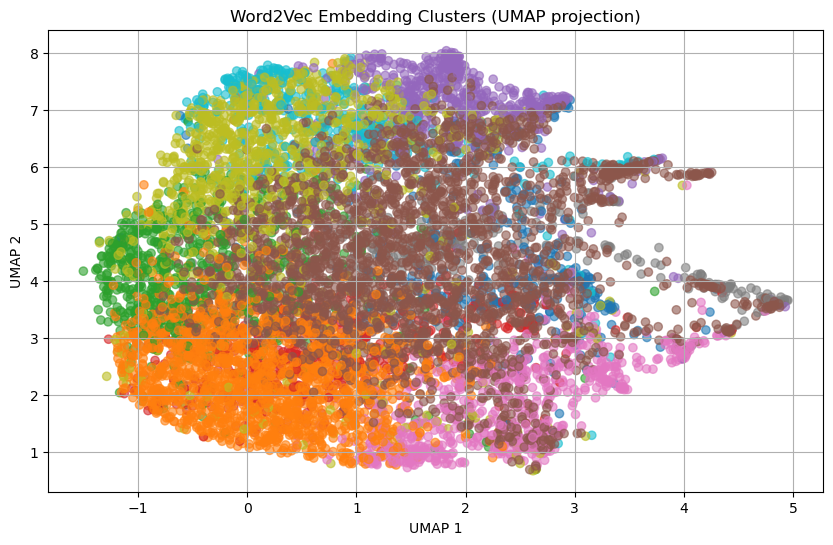

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=labels, cmap="tab10", alpha=0.6)
plt.title("Word2Vec Embedding Clusters (UMAP projection)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

This UMAP projection of the Word2Vec embeddings provides a clearer view of the semantic structure learned by the model:

- **Improved visual clarity**: Compared to PCA, UMAP better separates clusters, making thematic groupings easier to interpret.
- **Local cohesion**: Words with similar meanings or roles appear more tightly grouped — e.g., emotional vocabulary or character names form identifiable regions.
- **Persistent noise**: Some clusters still include high-frequency verbs or general terms, suggesting the need for more aggressive filtering in future iterations.

Overall, UMAP offers a more interpretable map of the embedding space, helping us visually confirm that the model captures distinct semantic fields relevant to our feminist corpus.

In [75]:
# print words by cluster
for i in range(10):
    words = clusters_df_updated[clusters_df_updated["cluster"] == i]["word"].tolist()
    print(f"\nCluster {i}:")
    print(", ".join(words[:15]))


Cluster 0:
mr, come, go, mrs, time, day, see, long, leave, miss, room, sit, house, home, place

Cluster 1:
high, nature, power, true, form, show, body, human, truth, beauty, virtue, sex, creature, free, effect

Cluster 2:
feel, life, love, heart, maggie, moment, god, feeling, thought, bear, sense, dorothea, spirit, strong, soul

Cluster 3:
man, great, mind, give, work, friend, world, wife, live, husband, far, family, present, manner, reason

Cluster 4:
hand, eye, face, head, arm, draw, small, table, large, white, dress, lay, amy, chair, hair

Cluster 5:
new, call, hold, appear, fine, carry, story, fair, line, second, dead, save, plain, command, part

Cluster 6:
woman, year, book, son, country, law, lord, church, age, land, unto, king, chapter, bible, history

Cluster 7:
say, think, know, like, look, little, good, thing, tell, find, take, old, way, shall, child

Cluster 8:
air, grow, beautiful, clear, touch, picture, fill, earth, thy, sweet, music, strike, bright, warm, heaven

Cluster

We retrained the Word2Vec model with updated parameters and applied UMAP for dimensionality reduction. This resulted in a more readable 2D representation of the word embedding space, where thematic clusters are more distinct and interpretable.

**Example interpretations of clustered regions:**

- **Cluster 0:** Social presence and domestic space — `mr, mrs, sit, room, home, place`
- **Cluster 1:** Moral and philosophical traits — `virtue, beauty, truth, form, sex`
- **Cluster 2:** Emotional and spiritual states — `love, life, heart, soul, god, dorothea`
- **Cluster 3:** Social hierarchy and gender roles — `man, husband, wife, mind, family, reason`
- **Cluster 4:** Physical embodiment — `eye, hand, face, arm, dress, amy`
- **Cluster 5:** Narrative events and progression — `call, appear, dead, story, save, second`
- **Cluster 6:** Institutions and ideological structures — `woman, church, lord, law, king, bible`
- **Cluster 7:** Functional and auxiliary verbs — `say, think, find, know, shall, child, old`
- **Cluster 8:** Romantic and sensory imagery — `sweet, air, music, warm, earth, heaven`
- **Cluster 9:** Spatial and action-oriented language — `door, run, watch, water, window, fall`

In [79]:
# save model
w2v_updated_model.save(str(REPO_DIR / "models" /"word2vec_feminist.model"))

# save clusters and UMAP results
umap_df = pd.DataFrame(reduced_umap, columns=["UMAP1", "UMAP2"])
umap_df["word"] = clusters_df["word"]
umap_df["cluster"] = clusters_df["cluster"]
umap_df.to_csv(PROCESSED_DIR / "word2vec_umap_clustered.csv", index=False)


### 5.4 BERTopic Modeling

BERTopic is a modern topic modeling technique that combines **contextual sentence embeddings** (e.g., from `all-MiniLM-L6-v2`) with clustering to identify coherent and interpretable themes. Unlike LDA, BERTopic leverages transformer-based embeddings to capture subtle meaning and phrase-level nuance.

We applied BERTopic to our cleaned and lemmatized chunked dataset, iteratively refining the pipeline to improve thematic clarity. The process unfolded in three key stages:


1. **BERTopic on Raw Chunks**
- **Input:** `lemmatized_text` column from the chunked dataset
- **Result:** 22 topics
- **Issue:** Topics were heavily dominated by character names (`emma`, `jo`, `heathcliff`) and narrative fillers (`say`, `come`, `know`)
- **Limitation:** Raw input retained narrative scaffolding and named entities, which overwhelmed thematic signals

2. **BERTopic with NER Filtering**
- **Improvement:** Used `spaCy` to remove named entities (`PERSON`) and stopwords
- **Result:** More granular topics (~45), partial reduction in name dominance
- **Issue:** Many names leaked back in through merged bigrams and missed NER boundaries (e.g., `mr_darcy`, `emma` still prominent)

3. **BERTopic with Manual Name Filtering**
- **Enhancement:** Built a custom stopword list of ~50 frequent character names using `spaCy` + frequency filtering
- **Result:** 39 interpretable topics centered around abstract themes (e.g., `freedom`, `virtue`, `law`, `mind`)
- **Outcome:** The most coherent and literary-relevant model, with fewer plot- or person-dominated clusters

**Summary of Results**

| Step                 | Topics Found | Notes                                                   |
|----------------------|--------------|----------------------------------------------------------|
| Raw BERTopic         | 22           | Character-heavy, redundant topics                        |
| With NER Filtering   | ~45          | Partial improvement, names still prominent               |
| With Name Filtering  | ~39          | Most interpretable: fewer names, clearer abstract themes |

**Challenges Faced**

- **Character name dominance**: Dominated early results across all versions. Resolved only through a manual name-removal pass.
- **HDBSCAN sensitivity**: Small parameter shifts led to very different topic granularity. We tuned `min_topic_size` for balance.
- **Topic collapse**: Some settings merged all clusters into generic themes. We addressed this by stabilizing input quality (bigrams, name filtering) and adjusting the embedding model.
- **Labeling and interpretation**: BERTopic does not label topics automatically. We manually interpreted top terms to assign meaningful thematic labels used in later stages.

**Outputs**
- Chunk-level topic assignments: `thematic_chunks_bertopic.csv`
- Visualizations:
  - `bertopic_overview.html`  
  - `bertopic_filtered_overview.html`  
  - `bertopic_no_names_overview.html`
- Final model saved as: `bertopic_no_names_feminist`

These interpretable topic clusters now serve as the **thematic foundation** for cross-author analysis, emotion overlay (Step 7), and keyword-based interpretation (KWIC in Step 5.5).

#### BERTopic Raw

In [3]:
# load thematic chunk data
df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_bigram.csv")
texts = df["lemmatized_text"].tolist()

In [4]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

print("Loading embedding model...")
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")  # fast + decent quality
print("Model loaded")
# "paraphrase-MiniLM-L12-v2" (slower, slightly richer) as an alternative

print("Initializing BERTopic...")
topic_model = BERTopic(
    embedding_model=embedding_model,
    n_gram_range=(1, 2),             # 1–2 word phrases
    min_topic_size=20,               # how general or ganular topics should be (10-20 for small-medium datasets)
    calculate_probabilities=True
)

print("BERTopic initialized")

Loading embedding model...
Model loaded
Initializing BERTopic...
BERTopic initialized


In [5]:
# fit model
topics, probs = topic_model.fit_transform(texts)

In [6]:
# sanity checks
print("Number of Topics Found:", len(set(topics)))

# print top 10 topics
print("Top 10 Topics:")
for i in range(10):
    print(f"Topic {i}: {topic_model.get_topic(i)}")

# top words in topic 0
topic_model.get_topic(0)

Number of Topics Found: 22
Top 10 Topics:
Topic 0: [('woman', 0.015337970963428565), ('man', 0.014538632848967255), ('life', 0.011194744670662731), ('love', 0.009682279872319512), ('mind', 0.009536986479684689), ('heart', 0.007563383711559572), ('child', 0.007532034419411181), ('virtue', 0.006667176524020324), ('nature', 0.006445338826665534), ('reason', 0.0059720334878122245)]
Topic 1: [('jo', 0.03431485262707519), ('meg', 0.02215356723383473), ('laurie', 0.019831685346644853), ('amy', 0.019502363692351428), ('beth', 0.01743565983908629), ('little', 0.013064498522181613), ('like', 0.01227597696690885), ('look', 0.011623901966934207), ('good', 0.011344618031369592), ('come', 0.01065606134356963)]
Topic 2: [('emma', 0.031470298842505996), ('harriet', 0.020655026312461945), ('think', 0.015690971227431294), ('mr_knightley', 0.014672795034580867), ('know', 0.01305474399912907), ('mrs_weston', 0.012894130106264503), ('thing', 0.012682898915151246), ('mr_elton', 0.011584951493422358), ('say'

[('woman', 0.015337970963428565),
 ('man', 0.014538632848967255),
 ('life', 0.011194744670662731),
 ('love', 0.009682279872319512),
 ('mind', 0.009536986479684689),
 ('heart', 0.007563383711559572),
 ('child', 0.007532034419411181),
 ('virtue', 0.006667176524020324),
 ('nature', 0.006445338826665534),
 ('reason', 0.0059720334878122245)]

In [7]:
# add topics and probabilities to the original df
df["bertopic_topic"] = topics
df["bertopic_prob"] = probs.max(axis=1)  # highest prob per row

In [10]:
# topic overview
topic_model.visualize_topics()
fig = topic_model.visualize_topics()
fig.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_overview.html"))

We applied BERTopic on the lemmatized book chunks to uncover underlying thematic patterns, using contextual embeddings from `all-MiniLM-L6-v2`. The model initially produced 22 topic clusters based on semantic similarity.

**Key observations:**

- **Character-dominated topics**: Many topics were driven by prominent character names (e.g., *jo*, *elizabeth*, *emma*), indicating the model often clustered around stylistic or narrative figures rather than conceptual themes.
- **Frequent low-value terms**: High-frequency verbs like *say*, *think*, *look*, and *come* appeared repeatedly, reducing topic interpretability.
- **Semantic redundancy**: Several topics overlapped in content. For example, Topics 0 and 4 both emphasized abstract concepts such as *woman*, *life*, *mind*, and *virtue*, suggesting thematic duplication.

**Main limitations:**

- **Named entity bias**: The presence of character names led to over-personalized topics, skewing the output toward plot- or book-specific groupings.
- **Insufficient filtering**: Even after lemmatization, the raw text retained noise—both stylistic and structural—that diluted the clarity of the discovered themes.

These findings highlighted the need for further preprocessing (e.g., entity removal, collocation handling) to shift the focus from characters to broader feminist discourse.

#### BERTopic Filtered (Standard NER)

In [25]:
# load lemmatized chunks
df_updated = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

In [26]:
# remove named entities and low-content words 
def filter_entities_and_lowvalue(text):
    doc = nlp(text)
    return " ".join([
        token.text for token in doc
        if not token.ent_type_  # remove named entities
        and not token.is_stop
        and token.is_alpha
        and len(token.text) > 2
    ])

df_updated["filtered_text"] = df_updated["lemmatized_text"].progress_apply(filter_entities_and_lowvalue)

100%|██████████| 5407/5407 [01:57<00:00, 46.21it/s]


In [27]:
df_updated["filtered_text"].head(25)

0     write memory unfortunately bring material care...
1     thing chance join big scientific expedition ne...
2     understand red blue pencil carry ask yes point...
3     glass squat investigate chemical sort tell spo...
4     dozen montenegroe great range discuss hotly wa...
5     cliff waterfall yes ask way course valuable lo...
6     find extremely clear idea country woman like u...
7     friend terry idea pretty woman game homely wor...
8     good speed cross base leave high mountain lake...
9     hold peace long run upward gosh terry woman ch...
10    progress talk civilization cry softly restrain...
11    scatter time reach far man dare push leave mai...
12    pleasant nearer sit learn language terry prote...
13    hear vanish gay laughter fleet away wide open ...
14    double row tree shade footpath tree vine fruit...
15    park open square college building stand quiet ...
16    woman earth brief address include partner ente...
17    evidently determine purpose apparently abl

In [28]:
# compare original vs filtered text side by side
df_updated[["lemmatized_text", "filtered_text"]].sample(5, random_state=42)

lemmatized_text  \
4269  sprague surgeon director arrive early mr bulst...   
1615  justly selfish domineering end circumstance ca...   
1924  plump firm hand hold thin feeble one sound ple...   
230   mean helen laugh benignantly strew handful lon...   
465   light worship god spirit find conduct degree r...   

                                          filtered_text  
4269  sprague surgeon director arrive early bulstrod...  
1615  justly selfish domineering end circumstance ca...  
1924  plump firm hand hold thin feeble sound pleasan...  
230   mean helen laugh benignantly strew handful lon...  
465   light worship god spirit find conduct degree r...

In [29]:
# remove common weak verbs/adjectives (to focus on content-rich words)
weak_words = set(["say", "know", "come", "look", "think", "good", "thing", "make"])
df_updated["filtered_text"] = df_updated["filtered_text"].apply(
    lambda text: " ".join([w for w in text.split() if w not in weak_words])
)

In [33]:
# load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# initialize new topic model
topic_model_filtered = BERTopic(
    embedding_model=embedding_model,
    n_gram_range=(1, 2),
    min_topic_size=15,
    calculate_probabilities=True,
    verbose=True
)

# fit new model
topics_filtered, probs_filtered = topic_model_filtered.fit_transform(df_updated["filtered_text"])
df_updated["bertopic_topic_filtered"] = topics_filtered

2025-06-01 02:37:36,138 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 169/169 [00:31<00:00,  5.34it/s]
2025-06-01 02:38:08,011 - BERTopic - Embedding - Completed ✓
2025-06-01 02:38:08,011 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-01 02:38:10,572 - BERTopic - Dimensionality - Completed ✓
2025-06-01 02:38:10,573 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-01 02:38:10,863 - BERTopic - Cluster - Completed ✓
2025-06-01 02:38:10,872 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-01 02:38:13,796 - BERTopic - Representation - Completed ✓


In [35]:
# sanity checks
print("Number of Filtered Topics Found:", len(set(topics_filtered)))

# print top 10 topics
print("Top 10 Filtered Topics:")
for i in range(10):
    print(f"Topic {i}: {topic_model_filtered.get_topic(i)}")

# top words in topic 0
topic_model_filtered.get_topic(0)

Number of Filtered Topics Found: 27
Top 10 Filtered Topics:
Topic 0: [('emma', 0.018012990926493538), ('miss', 0.016048426708830534), ('mrs', 0.014700011554385078), ('jane', 0.011485498772989461), ('harriet', 0.01110234832927834), ('weston', 0.010836195345389018), ('darcy', 0.010282088824897858), ('elton', 0.010142892258729466), ('soon', 0.009758409282780241), ('bennet', 0.009544223820669927)]
Topic 1: [('maggie', 0.041957917754217484), ('tulliver', 0.025573637470859032), ('glegg', 0.016037606489321635), ('mrs', 0.0148012278772396), ('father', 0.013420383541993331), ('tom', 0.013267405706670014), ('philip', 0.012286240597968888), ('like', 0.011488865501697932), ('mrs tulliver', 0.01093675497501574), ('pullet', 0.009675258755908927)]
Topic 2: [('woman', 0.03548096281890804), ('unto', 0.02167665015477243), ('man', 0.01919210573793374), ('lord', 0.017932291582682374), ('bible', 0.015040046357131888), ('god', 0.014483234479548798), ('wife', 0.01448039622440218), ('king', 0.0136808454477936

[('emma', 0.018012990926493538),
 ('miss', 0.016048426708830534),
 ('mrs', 0.014700011554385078),
 ('jane', 0.011485498772989461),
 ('harriet', 0.01110234832927834),
 ('weston', 0.010836195345389018),
 ('darcy', 0.010282088824897858),
 ('elton', 0.010142892258729466),
 ('soon', 0.009758409282780241),
 ('bennet', 0.009544223820669927)]

In [37]:
# topic overview
topic_model_filtered.visualize_topics()
fig = topic_model_filtered.visualize_topics()
fig.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_filtered_overview.html"))

Despite applying Named Entity Recognition (NER), many topic clusters still contain frequent character names such as `emma`, `dorothea`, or `heathcliff`. Several factors contribute to this:

- **NER coverage gaps**: spaCy’s entity recognizer can miss names—especially when they are lowercased, stylized, or contextually ambiguous, which is common in older literary texts.
- **Post-NER bigram construction**: Collocations like `mr_darcy` or `mrs_weston` are often formed *after* NER filtering, reintroducing names into the token stream.
- **High term frequency**: Named entities occur frequently and consistently within texts, making them statistically salient to unsupervised models.
- **Model dynamics**: BERTopic clusters based on co-occurrence and embedding similarity, not on semantic categories like “person” or “theme.” As a result, names become valid clustering anchors.

To reduce this character-name dominance and improve topic clarity, several approaches are possible:
- Create a **custom stopword list** of high-frequency character names.
- Run **NER filtering prior to collocation detection** to prevent name reinsertion.
- Apply **TF-IDF-based filtering** to remove overly common, non-thematic terms.
- Optionally **prune or merge** character-driven topics in post-processing.

For this iteration, we implemented the first approach — removing common character names — to improve thematic interpretability while preserving the overall structure of the corpus.

#### BERTopic Filtered (Name Filtering)

In [38]:
from collections import Counter

# combine all lemmatized chunks (or raw if more accurate)
all_text = " ".join(df_updated["chunk"].tolist())

# process in smaller batches to avoid memory issues
def extract_person_entities(text, batch_size=10000):
    people = []
    for i in tqdm(range(0, len(text), batch_size)):
        doc = nlp(text[i:i+batch_size])
        people.extend([ent.text.lower() for ent in doc.ents if ent.label_ == "PERSON"])
    return people

# run entity extraction
character_entities = extract_person_entities(all_text)

# count frequencies
char_counts = Counter(character_entities)

100%|██████████| 1455/1455 [05:46<00:00,  4.20it/s]


In [87]:
df_characters = pd.DataFrame(character_entities, columns=["character"])
df_characters.to_csv(str(PROCESSED_DIR / "character_list.csv"))

In [89]:
# preview most common names
char_counts.most_common(10)

[('tom', 2012),
 ('jo', 1370),
 ('dorothea', 1041),
 ('emma', 903),
 ('jane', 873),
 ('elizabeth', 812),
 ('mary', 737),
 ('amy', 710),
 ('casaubon', 702),
 ('laurie', 657)]

In [40]:
# frequency cutoff >50
name_list = [name for name, count in char_counts.items() if count > 50]

In [41]:
# load lemmatized chunks
df_updated = pd.read_csv(PROCESSED_DIR / "thematic_chunks_context_bigram.csv")
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

# remove named entities and low-content words 
def filter_entities_and_lowvalue(text):
    doc = nlp(text)
    return " ".join([
        token.text for token in doc
        if not token.ent_type_  # remove named entities
        and not token.is_stop
        and token.is_alpha
        and len(token.text) > 2
    ])

df_updated["filtered_text"] = df_updated["lemmatized_text"].progress_apply(filter_entities_and_lowvalue)

# remove common weak verbs/adjectives (to focus on content-rich words)
weak_words = set(["say", "know", "come", "look", "think", "good", "thing", "make"])
df_updated["filtered_text"] = df_updated["filtered_text"].apply(
    lambda text: " ".join([w for w in text.split() if w not in weak_words])
)

# remove character names from the filtered text
df_updated["filtered_text_no_names"] = df_updated["filtered_text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in name_list])
)
# check if names were removed
print("Sample filtered text without names:")
print(df_updated["filtered_text_no_names"].sample(5, random_state=42).tolist())

100%|██████████| 5407/5407 [01:58<00:00, 45.64it/s]


Sample filtered text without names:
['sprague surgeon director arrive early treasurer chairman absent conversation imply issue problematical majority tyke certain generally suppose physician wonder turn unanimous different mind concur action rugged weighty foresee adherent doctor suspect religion middlemarch tolerate deficiency probable professional weight believe world old association cleverness evil principle potent mind lady patient strict idea frilling sentiment negation doctor neighbor hard head dry witted condition texture hold favorable storing judgment connect drug event certain medical man middlemarch reputation definite religious view prayer active piety general presumption medical skill ground professionally speak fortunate religious sympathy general kind distant medical sanction sentiment church dissent adhesion particular tenet insist apt lutheran doctrine justification church stand fall return sure man mere machine fortuitous conjunction atom mrs wimple insist particular 

In [46]:
# rerun topic modeling without character names
# load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# initialize new topic model
topic_model_filtered = BERTopic(
    embedding_model=embedding_model,
    n_gram_range=(1, 2),
    min_topic_size=12, # size 10 => 45 topics; size 15 => 3 topics; 12 => 39 topics; 13 => 3 topics (sudden dip due to HDBSCAN sensitivity, clutter collapse, etc.)
    calculate_probabilities=True,
    verbose=True
)

# fit new model
topics_filtered, probs_filtered = topic_model_filtered.fit_transform(df_updated["filtered_text_no_names"])
df_updated["bertopic_topic_filtered_no_names"] = topics_filtered

# sanity checks
print("Number of Filtered Topics Found (No Names):", len(set(topics_filtered)))

# print top 10 topics
print("Top 10 Filtered Topics (No Names):")
for i in range(10):
    print(f"Topic {i}: {topic_model_filtered.get_topic(i)}")

# top words in topic 0
topic_model_filtered.get_topic(0)

2025-06-01 03:17:20,198 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 169/169 [00:33<00:00,  5.09it/s]
2025-06-01 03:17:53,669 - BERTopic - Embedding - Completed ✓
2025-06-01 03:17:53,672 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-01 03:17:58,210 - BERTopic - Dimensionality - Completed ✓
2025-06-01 03:17:58,216 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-01 03:17:58,663 - BERTopic - Cluster - Completed ✓
2025-06-01 03:17:58,683 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-06-01 03:18:02,214 - BERTopic - Representation - Completed ✓


Number of Filtered Topics Found (No Names): 39
Top 10 Filtered Topics (No Names):
Topic 0: [('mrs', 0.014993117771097965), ('dear', 0.009453551791171043), ('soon', 0.00922424784730345), ('friend', 0.008417135719154928), ('time', 0.008094082182478616), ('sister', 0.008028998492859233), ('hope', 0.007851718853020596), ('wish', 0.007681811359678398), ('lady', 0.0076581984639002895), ('hear', 0.007329460488691415)]
Topic 1: [('woman', 0.021199199018099614), ('man', 0.017545776062343175), ('virtue', 0.010754140650672487), ('mind', 0.01034597790557232), ('child', 0.0095190381898665), ('sex', 0.009332420718252687), ('reason', 0.009022130408337282), ('life', 0.008675003308986523), ('love', 0.007786495287510211), ('nature', 0.00717985915301867)]
Topic 2: [('woman', 0.030464606000845468), ('unto', 0.02024820525339159), ('lord', 0.016964802617724095), ('man', 0.016139750412485228), ('bible', 0.014231021183600635), ('god', 0.013548864330346112), ('king', 0.013292640324314443), ('wife', 0.013133163

[('mrs', 0.014993117771097965),
 ('dear', 0.009453551791171043),
 ('soon', 0.00922424784730345),
 ('friend', 0.008417135719154928),
 ('time', 0.008094082182478616),
 ('sister', 0.008028998492859233),
 ('hope', 0.007851718853020596),
 ('wish', 0.007681811359678398),
 ('lady', 0.0076581984639002895),
 ('hear', 0.007329460488691415)]

In [47]:
# topic overview
topic_model_filtered.visualize_topics()
fig_1 = topic_model_filtered.visualize_topics()
fig_1.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_no_names_overview.html"))

In [51]:
# topic similarity heatmap
fig_2 = topic_model_filtered.visualize_heatmap()
fig_2.write_html(str(REPO_DIR / "reports" / "figures" / "bertopic_no_names_heatmap.html"))

In [52]:
# save results
topic_model_filtered.save(str(REPO_DIR / "models" / "bertopic_no_names_feminist"))
df_updated.to_csv(PROCESSED_DIR / "thematic_chunks_bertopic.csv", index=False)

2025-06-01 03:22:53,779 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


**What We Did**

- Extracted high-frequency person names using `spaCy`'s NER across the full corpus.
- Built a custom stopword list of character names appearing >50 times (e.g., `tom`, `amy`, `casaubon`).
- Removed those names from the lemmatized, cleaned text — *after* all other filtering steps (stopwords, punctuation, weak verbs).
- Also filtered out low-value words like `say`, `think`, `look`, and `good` to sharpen thematic focus.

**What Improved**

- The new BERTopic model (run on filtered text) produced **39 interpretable topics** — fewer character clusters, more abstract concepts.
- Sample topic highlights:
  - **Topic 0:** `mrs`, `dear`, `friend`, `soon` → domestic address & intimacy
  - **Topic 1:** `woman`, `mind`, `virtue`, `affection` → moral philosophy
  - **Topic 4:** `tree`, `river`, `mountain`, `water` → nature imagery
  - **Topic 6:** `convention`, `right`, `law`, `state` → institutional critique

This shift allowed the model to pick up on language patterns around ideology, emotion, and embodiment — not just narrative actors.

**Outputs**

- Topic labels per chunk:  
  `data/processed/thematic_chunks_bertopic.csv`
- Interactive plots:  
  `reports/figures/bertopic_no_names_overview.html`  
  `reports/figures/bertopic_no_names_heatmap.html`
- Saved model:  
  `models/bertopic_no_names_feminist`


This final filtering step made BERTopic significantly more useful for our analysis. By reducing name noise and boosting content-rich vocabulary, we now get:
- Cleaner topics for emotion or sentiment overlays
- Better alignment with feminist concepts (freedom, work, virtue)
- Easier comparison across authors, genres, or time periods

This version is used in all downstream modeling (Steps 6–7).

### 5.5 KWIC

Keyword-in-Context (KWIC) extraction allows us to explore **how core feminist concepts are actually used** in the literary texts — not just that they appear, but *how they’re framed*, *what words surround them*, and *who uses them most*.

We built a KWIC index from the original (non-lemmatized) chunked text using a curated set of ~30 keywords grouped into conceptual categories:

- **Marriage & family**: `marriage`, `husband`, `wife`, `children`
- **Autonomy & rights**: `freedom`, `choice`, `law`, `right`
- **Emotion & morality**: `love`, `virtue`, `sin`, `truth`
- **Labor & education**: `work`, `school`, `money`, `teach`

**What We Did**
- Matched keywords **at token level**, using lowercase normalization to catch all inflections
- Extracted short windows (±5 tokens) around each match to build a KWIC dataset
- Aggregated results by **author** and **book** to study thematic emphasis across the corpus
- Visualized:
  - Total frequency of each keyword
  - Keyword usage distribution by author
  - Co-occurrence patterns across themes

**Design Choices & Issues**
- **Broad matching strategy** increased recall but introduced noise. For instance, `free` matched `free_time`, not always `freedom`. We manually reviewed KWIC samples and refined keyword lists.
- **Ambiguous terms** like `love` or `truth` were contextually vague. Emotion overlay in Step 6 helps disambiguate tone and function.
- **Granularity balance**: Some themes (e.g., `marriage`) were overrepresented in plot-heavy texts. We cross-referenced these with BERTopic results to validate thematic significance.

**Why This Matters**
KWIC analysis bridges **quantitative modeling (TF-IDF, BERTopic, Word2Vec)** with **close-reading practices**, showing how abstract feminist themes are actually **constructed linguistically** — in emotion, grammar, and repetition.

It also primes us for Step 6, where we’ll overlay **emotion predictions** onto these same sentences to understand **how feminist values are emotionally framed** — e.g., is `marriage` described with joy, fear, resignation?

This dual view — thematic + emotional — allows for a richer interpretation of feminist discourse across authors and time.

In [54]:
# define keyword-in-context (KWIC) extraction function
def extract_kwic(text, keyword, window=10):
    tokens = text.split()
    matches = []
    for i, token in enumerate(tokens):
        if token == keyword:
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            kwic_window = tokens[start:end]
            matches.append(" ".join(kwic_window))
    return matches

In [55]:
# load processed thematic chunks with BERTopic results
df = pd.read_csv(PROCESSED_DIR / "thematic_chunks_bertopic.csv")
tqdm.pandas()

# define thematic keywords (can refine further)
theme_terms = [
    "marriage", "husband", "wife", "divorce", "matrimony", "union",
    "independence", "education", "school", "reason", "freedom", "rights",
    "work", "labor", "money", "employment", "poverty", "job", "career",
    "love", "feel", "care", "heart", "mother", "father", "child", "girl", "boy",
    "virtue", "power", "obey", "duty", "truth", "law", "voice", "vote"
]

# make a lowercase version of the raw chunk text for matching
df["chunk_lower"] = df["chunk"].str.lower()

# initialize list to collect kwic data
kwic_records = []

# define a function to extract KWIC (± window_size words)
def extract_kwic(text, keyword, window_size=5):
    tokens = text.split()
    matches = []
    for i, token in enumerate(tokens):
        if token == keyword:
            start = max(i - window_size, 0)
            end = min(i + window_size + 1, len(tokens))
            matches.append(" ".join(tokens[start:end]))
    return matches

# loop through each thematic keyword and collect context windows
for term in theme_terms:
    for _, row in df.iterrows():
        chunk_text = row["chunk_lower"]  # match on lowercase version
        windows = extract_kwic(chunk_text, term)
        for context in windows:
            kwic_records.append({
                "keyword": term,
                "context": context,
                "title": row["title"],
                "author": row["author"],
                "topic": row.get("bertopic_topic_filtered_no_names", None)
            })

# convert to dataframe
kwic_df = pd.DataFrame(kwic_records)

In [57]:
# save to CSV
kwic_df.to_csv(PROCESSED_DIR / "kwic_theme_terms.csv", index=False)
# display
kwic_df

keyword                                            context  \
0      marriage  a strange, new joy. of marriage as a ceremony ...   
1      marriage       new joy. of marriage as a ceremony they knew   
2      marriage  “of course they haven’t any marriage ceremony ...   
3      marriage  are monogamous, you know. and marriage is the ...   
4      marriage  with them and made our marriage vows. chapter ...   
...         ...                                                ...   
15132      vote        that. when i give a vote i must know what i   
15133      vote  that away; else i should vote for things stayi...   
15134      vote  that away; else i should vote for things stayi...   
15135      vote  would not withdraw from me, vote or no vote, w...   
15136      vote  every argument, and the casting vote in every ...   

             title                    author  topic  
0          Herland  Charlotte Perkins Gilman     -1  
1          Herland  Charlotte Perkins Gilman      1  
2          Herland  Charlotte Perkins Gilman      1  
3          Herland  Charlotte Perkins Gilman     -1  
4          Herland  Charlotte Perkins Gilman      1  
...            ...                       ...    ...  
15132  Middlemarch              George Eliot     -1  
15133  Middlemarch              George Eliot     -1  
15134  Middlemarch              George Eliot     -1  
15135  Middlemarch              George Eliot     -1  
15136    Jane Eyre          Charlotte Brontë     -1  

[15137 rows x 5 columns]

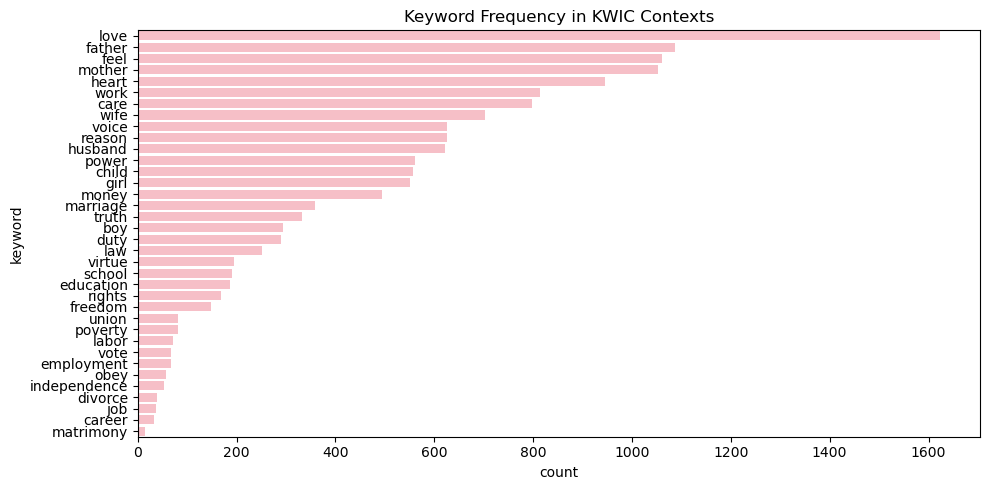

In [64]:
# keyword frequency distribution
plt.figure(figsize=(10, 5))
sns.countplot(
    data=kwic_df,
    y="keyword", 
    order=kwic_df["keyword"].value_counts().index, 
    color="lightpink"
    )
plt.title("Keyword Frequency in KWIC Contexts")
plt.tight_layout()
plt.show()

This plot shows the frequency of selected feminist-related keywords in sentence-level KWIC (Keyword-in-Context) extractions.

- **Dominant terms** like `love`, `father`, `feel`, and `mother` suggest a strong emotional and familial focus across the corpus.
- Words related to **social roles** (`wife`, `husband`, `child`, `girl`) and **labor/value** (`work`, `power`, `voice`) appear consistently, highlighting recurring themes of domesticity, care, and agency.
- **Lower-frequency terms** like `vote`, `education`, `freedom`, or `divorce` still reflect critical feminist concerns, though they are less common in the selected literary material — possibly due to historical context or genre norms.

These frequencies help identify which themes were most explicitly referenced in 18th–20th century feminist writing, and offer a base for deeper contextual or emotional analysis in Step 7.

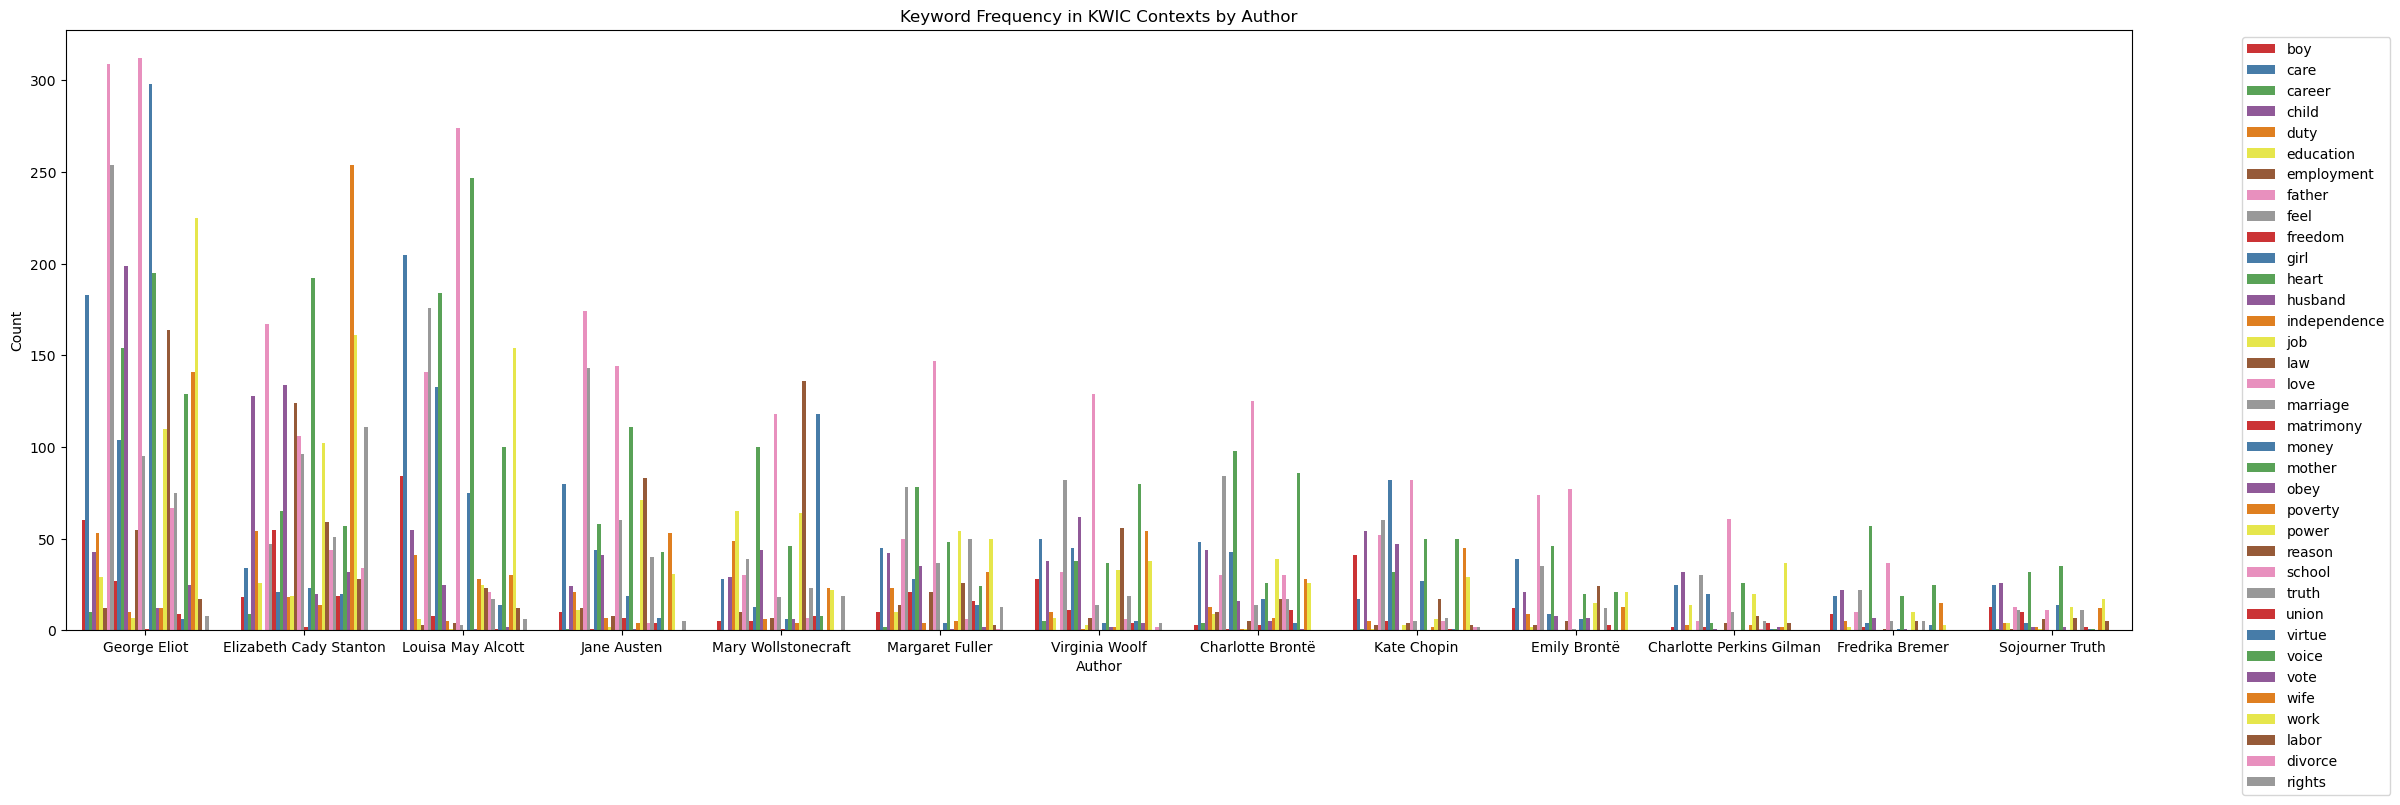

In [70]:
# analysis of keyword mentions by author

# aggregate keyword counts by author
keyword_counts = kwic_df.groupby(["author", "keyword"]).size().reset_index(name="count")

# sort authors by total keyword mentions (optional, for nicer layout)
author_order = (
    keyword_counts.groupby("author")["count"]
    .sum()
    .sort_values(ascending=False)
    .index
)

# plot as grouped bar chart
plt.figure(figsize=(24, 8))
sns.barplot(
    data=keyword_counts,
    x="author",
    y="count",
    hue="keyword",
    order=author_order,
    palette="Set1"
)
plt.title("Keyword Frequency in KWIC Contexts by Author")
plt.xlabel("Author")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

This plot aggregates the frequency of all thematic keywords found in KWIC windows, grouped by author. It enables a cross-author comparison of how often different feminist-related terms (like `freedom`, `mother`, or `education`) appear in their writings.

**Notable patterns:**
- **George Eliot**, **Louisa May Alcott**, and **Elizabeth Cady Stanton** show the highest keyword densities, suggesting broad thematic engagement in their texts.
- Emotionally and relationally charged terms (`love`, `feel`, `mother`, `heart`) appear across almost all authors, reflecting a common focus on interiority and family.
- Structural or political terms (`labor`, `vote`, `career`, `rights`) are less frequent and more unevenly distributed — likely reflecting historical context, genre, and authorial stance.

Text(0.5, 0.98, 'Keyword Frequency by Author (KWIC Contexts)')

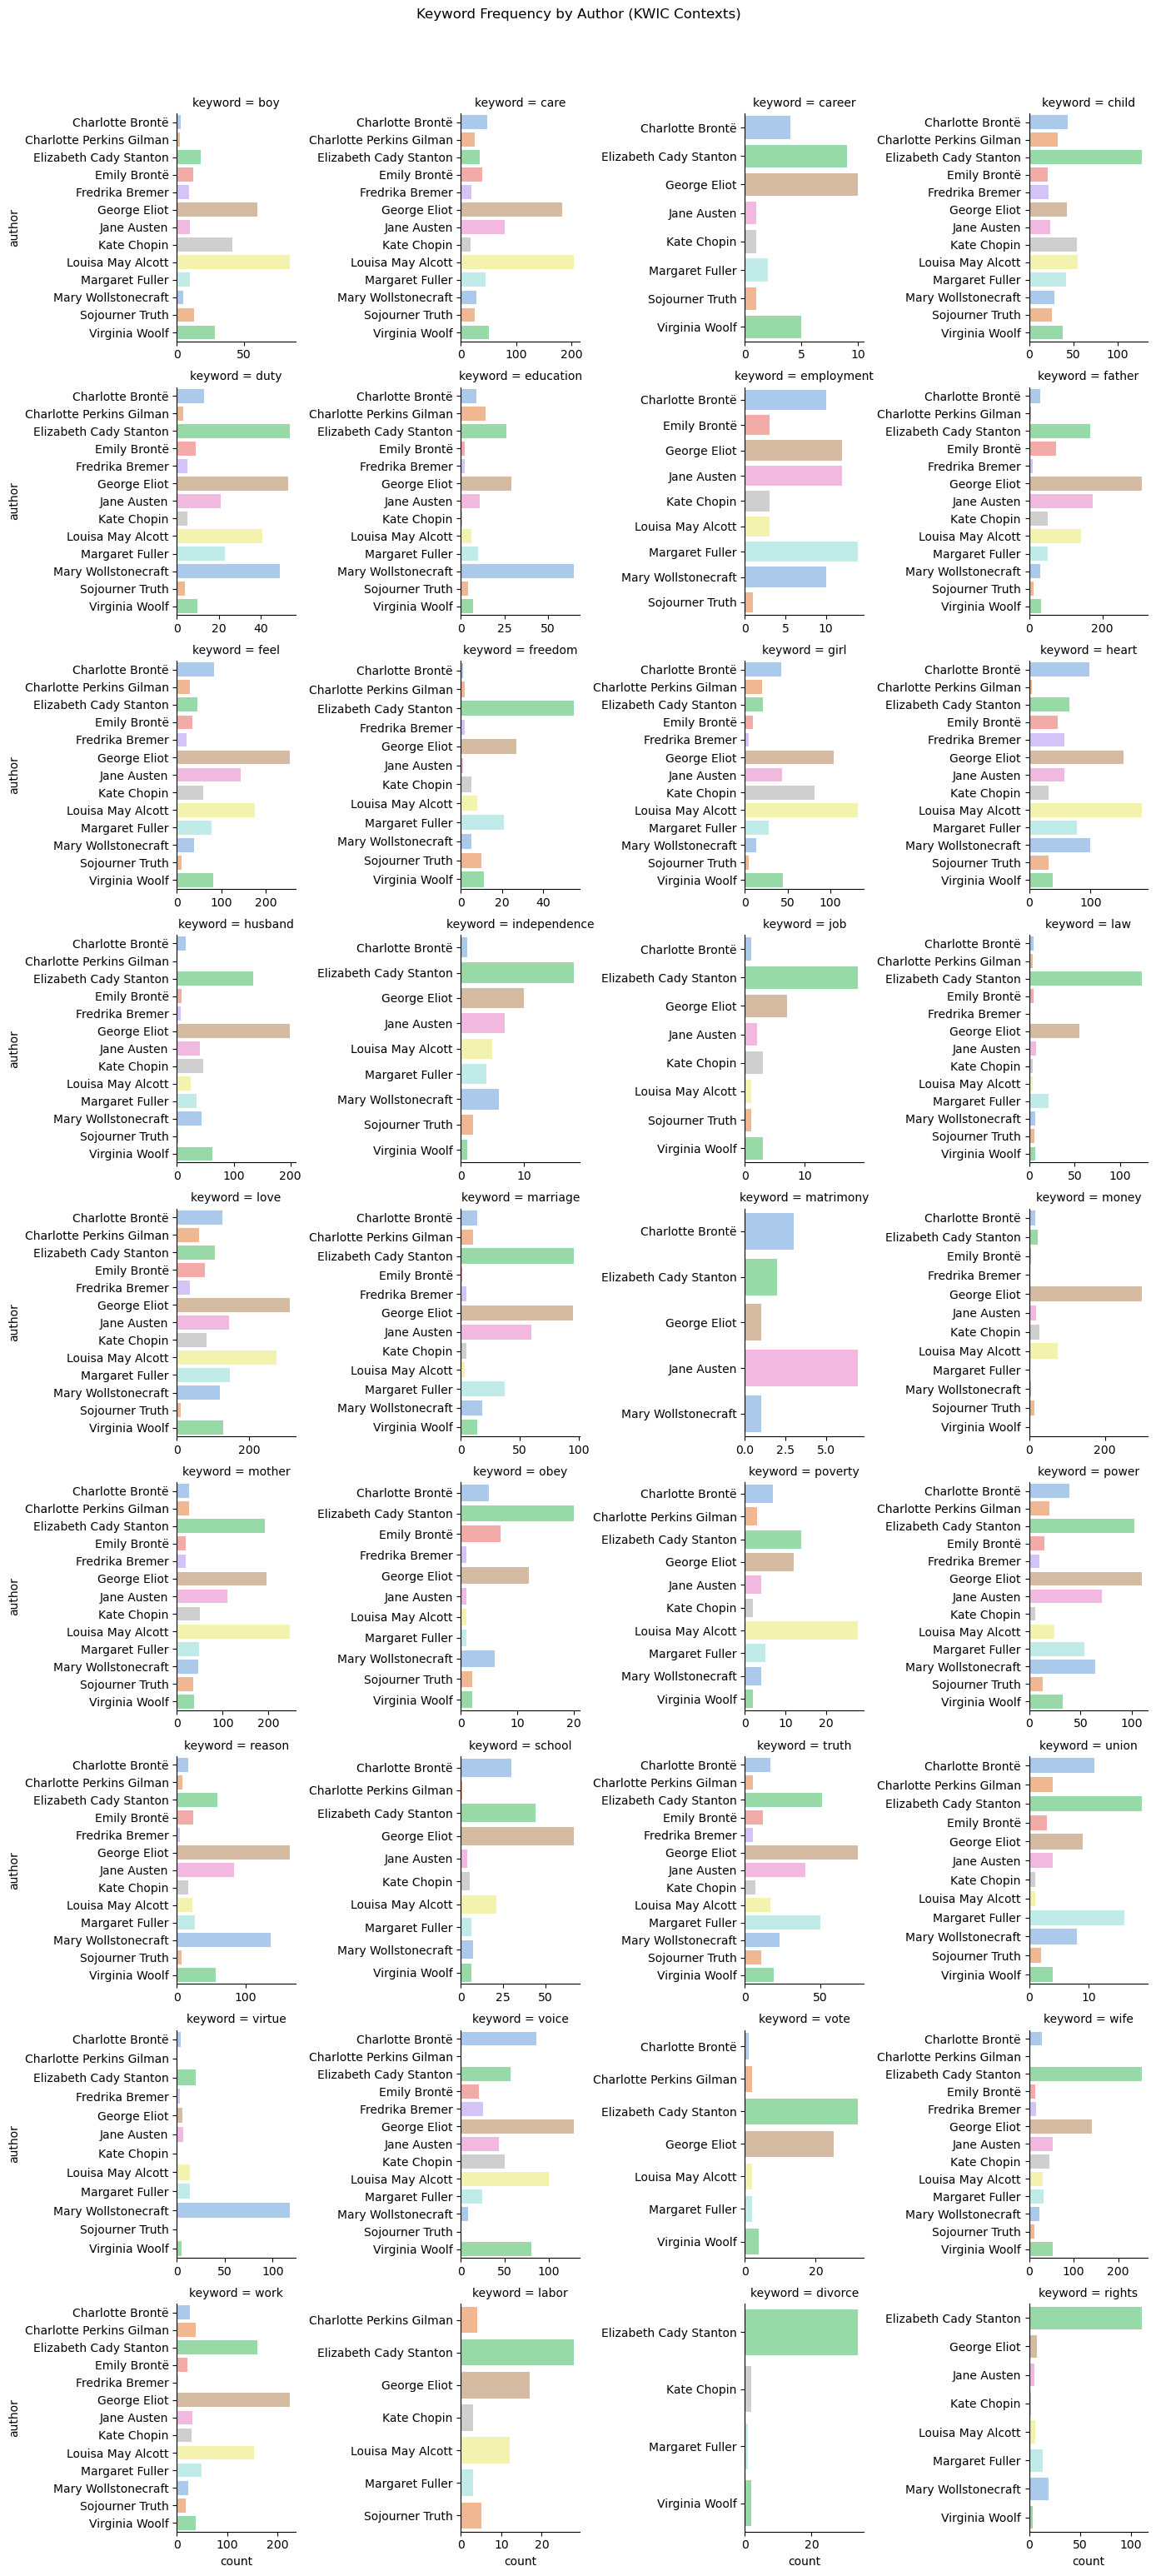

In [75]:
# analysis of author distribution for each keyword
g = sns.catplot(
    data=keyword_counts,
    kind="bar",
    x="count", y="author",
    col="keyword",
    col_wrap=4,
    height=3.5,
    sharex=False,
    sharey=False,
    palette="pastel"
)
g.fig.subplots_adjust(top=0.94)
g.fig.suptitle("Keyword Frequency by Author (KWIC Contexts)")

This grid of bar plots shows **how each author engages with specific feminist themes**, one keyword at a time. Each panel focuses on a single term — from emotional language like `feel` and `love`, to structural concerns like `education`, `labor`, or `freedom`.

**Why this matters in context:**
- Authors like **Elizabeth Cady Stanton** and **Mary Wollstonecraft** show strong usage of political and ideological terms (`rights`, `law`, `school`, `virtue`), reflecting their work in feminist theory and social critique.
- **Louisa May Alcott** and **George Eliot** lean into more relational or emotional language (`girl`, `mother`, `feel`, `truth`), aligned with their focus on domestic life, character development, and personal transformation.
- Some keywords appear across many authors (`love`, `heart`, `mother`), suggesting **shared emotional ground**, while others like `job`, `divorce`, or `vote` are rare — reflecting the **limited discursive space** women had around labor and autonomy in 19th-century literature.
- Sparse mentions of terms like `career`, `employment`, or `poverty` also show how **economic themes were often secondary** to moral or interpersonal narratives.

This visualization gives us a thematic map of feminist discourse as it was written — showing which authors took up which struggles, and where those voices overlapped or diverged.

In [76]:
# show KWIC contexts for selected keywords
sample_terms = ["marriage", "independence", "work", "love", "vote"]
for term in sample_terms:
    print(f"\n--- KWIC for: {term.upper()} ---")
    display(kwic_df[kwic_df["keyword"] == term][["context", "author", "title"]].sample(5, random_state=42))


--- KWIC for: MARRIAGE ---


context  \
223  thousand pounds was settled by marriage articl...   
42   that the children of the marriage should be br...   
261  boudoir—with a background of prospective marri...   
301  i will hinder! such a marriage would be fatal ...   
56   marriage. the pythagoreans taught that marriag...   

                     author                title  
223             Jane Austen  Pride and Prejudice  
42   Elizabeth Cady Stanton    The Woman's Bible  
261            George Eliot          Middlemarch  
301            George Eliot          Middlemarch  
56   Elizabeth Cady Stanton    The Woman's Bible


--- KWIC for: INDEPENDENCE ---


context             author  \
1835  tremulous, had a certain proud independence in...       George Eliot   
1865  will, still nettled. “my personal independence...       George Eliot   
1864  with his unmixed resolutions of independence a...       George Eliot   
1828  that an external freedom, an independence of t...    Margaret Fuller   
1860  a sense of power and independence better than ...  Louisa May Alcott   

                                title  
1835            The Mill on the Floss  
1865                      Middlemarch  
1864                      Middlemarch  
1828  Woman in the Nineteenth Century  
1860                     Little Women


--- KWIC for: WORK ---


context             author  \
3435  (a strange comment theirs, when work was done)...     Virginia Woolf   
3777  you like. i intend to work hard,” said amy in her  Louisa May Alcott   
3415  existing.) meals are taken separately; work is...    Margaret Fuller   
3479  them alone they'd go to work and take care of ...  Louisa May Alcott   
3727  plainly showed how earnest her work had been. ...  Louisa May Alcott   

                                title  
3435                     Mrs Dalloway  
3777                     Little Women  
3415  Woman in the Nineteenth Century  
3479            An Old-Fashioned Girl  
3727                     Little Women


--- KWIC for: LOVE ---


context             author  \
4922  st. john said, it was love that made her under...     Virginia Woolf   
5268  so much, and seems to love so well! but--the n...    Fredrika Bremer   
5623  way; that i’m mad with love for you; that i re...       George Eliot   
6013  an effort and tried to love him. it couldn’t b...  Louisa May Alcott   
5416    but i own i should love well to bring her pride       Emily Brontë   

                      title  
4922         The Voyage Out  
5268       Strife and Peace  
5623  The Mill on the Floss  
6013           Little Women  
5416      Wuthering Heights


--- KWIC for: VOTE ---


context  \
15115  convenient side, and given his vote for the ap...   
15085  platform, address the assembly, or vote for me...   
15073        as to think that a vote does him or her any   
15078       was then adopted by a vote of 53 to 41. "the   
15097  say her prayers. our women vote with the same ...   

                       author                  title  
15115            George Eliot            Middlemarch  
15085  Elizabeth Cady Stanton  Eighty Years and More  
15073          Virginia Woolf         The Voyage Out  
15078  Elizabeth Cady Stanton      The Woman's Bible  
15097  Elizabeth Cady Stanton  Eighty Years and More

In [77]:
# save KWIC results to CSV
kwic_df.to_csv(PROCESSED_DIR / "kwic_results.csv", index=False)

## 6. Emotion Classification

This step focuses on **identifying emotions** in sentences that explicitly reference women, using **transformer-based models**. Our goal is to quantify and interpret the emotional tone surrounding gendered language in feminist literature (1790–1925), helping us trace patterns of sentiment, agency, and affective framing across texts.

We work with the filtered dataset produced in Step 4.2:
- Only sentences that include gendered pronouns or feminine-coded names are retained
- Metadata like book title, author, and chunk ID are preserved
- The result is a high-precision sample of **woman-referencing language**, suitable for emotional analysis


**Ensemble Emotion Classification**
We apply three different models to a sample of sentences:
- `SamLowe/roberta-base-go_emotions` — 28 nuanced emotion labels (fine-tuned on GoEmotions)
- `bhadresh-savani/distilbert-base-uncased-emotion` — simpler 6-class emotion set
- `facebook/bart-large-mnli` — zero-shot classification based on label similarity

A custom ensemble strategy selects the most frequent (or most confident) prediction across the three. This helps us **compare models, check consistency**, and identify weaknesses before scaling up.

**Full Dataset Classification (Undersampled & All Sentences)**
For scalability and performance, we select a single performant model:  
- `SamLowe/roberta-base-go_emotions`

This model is applied in two rounds:
- An **undersampled version**, where max 200 sentences are sampled per book (to balance author/book representation)
- The **full dataset**, where every gender-referencing sentence is classified

Each sentence receives a single **GoEmotions label**, later mapped to **Ekman’s 6 basic emotions** (`joy`, `sadness`, `anger`, `fear`, `disgust`, `surprise`) plus `neutral`.

After inference, we:
- **Map fine-grained GoEmotions labels** to a reduced set for interpretability
- **Visualize distributions** of emotions overall, and by author/book
- **Filter out `neutral` predictions** to spotlight emotionally expressive content
- Examine **sentence length per emotion**, revealing how emotional framing relates to sentence complexity

This step produces a reusable dataset (`emotion_sentences_final.csv`) for future narrative or classification tasks.

### 6.1. Emotion Classification with Ensemble

In this section, we explore **ensemble-based emotion classification** as a way to boost prediction reliability and cross-check label consistency. Instead of relying on a single model, we combine outputs from three transformer-based classifiers:

- **Model 1:** `SamLowe/roberta-base-go_emotions`  
  A fine-tuned model on the GoEmotions dataset (28 emotion classes + neutral)
- **Model 2:** `bhadresh-savani/distilbert-base-uncased-emotion`  
  Trained on a 6-emotion set + neutral, provides quicker but coarser predictions
- **Model 3:** `facebook/bart-large-mnli` (Zero-Shot)  
  Uses natural language inference to match sentences with a fixed emotion label set

Each sentence is passed through all three models. The ensemble then selects the **final emotion** via a majority vote; if there's no agreement, we fall back on the highest-confidence prediction.

We aligned the output space to a unified label set based on **Ekman's six core emotions** (`anger`, `joy`, `sadness`, `fear`, `disgust`, `surprise`) plus `neutral`. This makes the results interpretable and simplifies downstream analysis.

**Important note:**  
- This ensemble pipeline is computationally expensive. Inference with three models, especially including a zero-shot classifier, significantly increases runtime — making it impractical for large-scale classification.  
- For this reason, we only applied it to a **small random sample of 30 sentences**, useful for debugging and model comparison.  
- If higher label accuracy is critical, especially in future extensions or downstream tasks, this ensemble method offers a **more robust but slower alternative** to single-model classification.

In [103]:
# import required packages
from transformers import pipeline
from collections import Counter
from tqdm import tqdm
tqdm

# load the emotion-labeled sentences
df_emotions = pd.read_csv(PROCESSED_DIR / "emotion_sentences.csv")

# check a few examples
df_emotions.sample(5)

sentence  \
8098   it is SEALED,' repeated\nSojourner, in the dee...   
33883  Poor as he is, he didn’t forget a\nservant or ...   
30489  The young girl obediently yielded to her old c...   
6073   The unmarried woman careth for the things of t...   
18501  And perhaps here was an opportunity\nindicated...   

                              title                  author  year chunk_id  \
8098   Narrative of Sojourner Truth         Sojourner Truth  1850   ST_069   
33883                  Little Women       Louisa May Alcott  1868   LM_268   
30489                 The Awakening             Kate Chopin  1899   KC_129   
6073              The Woman's Bible  Elizabeth Cady Stanton  1895   EC_241   
18501         The Mill on the Floss            George Eliot  1860   GE_267   

       inferred_emotion  
8098                NaN  
33883               NaN  
30489               NaN  
6073                NaN  
18501               NaN

In [108]:
# load transformers pipelines for emotion or zero-shot classification

# model 1: pretrained emotion classifier with 6 core emotions + neutral
# model_1 = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)
model_1 = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", top_k=1)

# model 2: bhadresh-savani (6 emotions)
model_2 = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion", top_k=1)

# model 3: zero-shot (labels must match Model 1 for consistency)
model_3 = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# define common emotion labels to align all models 
emotion_labels = ["anger", "joy", "sadness", "fear", "surprise", "disgust", "neutral"] # based on Ekman's 6 basic emotions + neutral class

Device set to use mps:0
Device set to use mps:0
Device set to use mps:0


In [124]:
print("Model 1 output:", model_1("She felt lost and afraid."))
print("Model 2 output:", model_2("She felt lost and afraid."))
print("Model 3 output:", model_3("She felt lost and afraid.", candidate_labels=emotion_labels))

Model 1 output: [[{'label': 'fear', 'score': 0.8060752749443054}]]
Model 2 output: [[{'label': 'sadness', 'score': 0.9936484694480896}]]
Model 3 output: {'sequence': 'She felt lost and afraid.', 'labels': ['fear', 'surprise', 'sadness', 'disgust', 'neutral', 'anger', 'joy'], 'scores': [0.6896416544914246, 0.16199538111686707, 0.11673657596111298, 0.013447667472064495, 0.008939960971474648, 0.007424407638609409, 0.0018143586348742247]}


In [123]:
from collections import Counter

def get_ensemble_emotion(sentence, model_1, model_2, model_3, labels):
    def parse_output(output):
        # unwrap nested lists like [[{...}]]
        if isinstance(output, list) and isinstance(output[0], list):
            output = output[0]
        # now we expect output to be list of dicts or a zero-shot dict
        if isinstance(output, list) and isinstance(output[0], dict):
            return output[0]['label'].lower(), output[0]['score']
        elif isinstance(output, dict) and 'labels' in output and 'scores' in output:
            return output['labels'][0].lower(), output['scores'][0]
        else:
            print("Unexpected format:", output)
            raise ValueError("Unsupported model output format")

    try:
        label1, score1 = parse_output(model_1(sentence))
        label2, score2 = parse_output(model_2(sentence))
        label3, score3 = parse_output(model_3(sentence, candidate_labels=labels))

        votes = [label1, label2, label3]
        vote_counts = Counter(votes)

        # apply majority rule if possible
        if vote_counts.most_common(1)[0][1] >= 2:
            final = vote_counts.most_common(1)[0][0]
        else:
            scores = {label1: score1, label2: score2, label3: score3}
            final = max(scores.items(), key=lambda x: x[1])[0]

        return {
            "model_1": label1,
            "model_2": label2,
            "model_3": label3,
            "final_emotion": final
        }

    except Exception as e:
        print(f"Error on sentence: {sentence}")
        raise e

In [125]:
sample_df = df_emotions.sample(n=30, random_state=42).copy()

sample_df["ensemble_output"] = sample_df["sentence"].progress_apply(
    lambda x: get_ensemble_emotion(x, model_1, model_2, model_3, labels=emotion_labels)
)

sample_df["model_1"] = sample_df["ensemble_output"].apply(lambda x: x["model_1"])
sample_df["model_2"] = sample_df["ensemble_output"].apply(lambda x: x["model_2"])
sample_df["model_3"] = sample_df["ensemble_output"].apply(lambda x: x["model_3"])
sample_df["inferred_emotion"] = sample_df["ensemble_output"].apply(lambda x: x["final_emotion"])

sample_df.drop(columns=["ensemble_output"], inplace=True)
sample_df[["sentence", "model_1", "model_2", "model_3", "inferred_emotion"]].head()

100%|██████████| 30/30 [02:47<00:00,  5.59s/it]


sentence     model_1 model_2  \
11100                 She heard the names of the\nstars.     neutral    fear   
43717       Try if she can speak now—ask her her\nname.”     neutral   anger   
8901   I come now with satisfaction to my own country...  admiration     joy   
41043  The lawyer had already gathered\nfrom her expr...     neutral     joy   
32386  Soon your mother\nwill be here, and then every...    optimism     joy   

        model_3 inferred_emotion  
11100  surprise          neutral  
43717  surprise          neutral  
8901        joy              joy  
41043  surprise          neutral  
32386  surprise              joy

### 6.2 Emotion Classification on Undersampled Data

After testing the ensemble approach, we shifted to a **single-model pipeline** for larger-scale inference. The main goal here was to **balance interpretability and speed**, allowing us to label a wide selection of sentences without overloading compute resources.

We used `SamLowe/roberta-base-go_emotions`, a well-performing model trained on the **GoEmotions** dataset (28 emotion labels + neutral). It offers a good trade-off: accurate, fast, and reasonably generalizable across textual styles.

To keep the analysis manageable and representative, we **sampled up to 200 sentences per book**, ensuring every author and title was proportionally included.

Each sentence is processed individually, and the model’s **top emotion prediction** is recorded as `inferred_emotion`. We then **mapped those detailed GoEmotions labels** into a smaller, interpretable set based on **Ekman’s core emotions**: `joy`, `sadness`, `fear`, `anger`, `disgust`, `surprise`, and `neutral`.

This process gives us:
- A balanced snapshot of emotional tone across the corpus (excluding *The Yellow Walpaper*, which had 50 samples)
- A compact emotion vocabulary for downstream modeling
- A scalable method we can apply to the **full dataset** in the next step

This step uses **undersampled data**, making it suitable for exploratory analysis and visualizations — but not yet representative of the entire corpus distribution.

<Axes: title={'center': 'Sentence count per book'}, xlabel='title'>

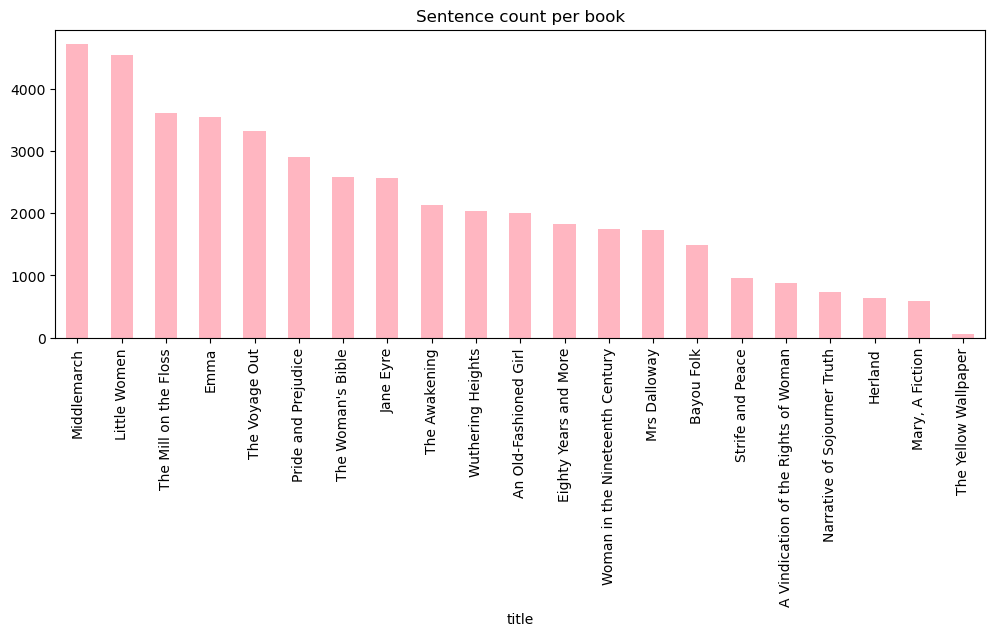

In [155]:
# check how many sentences come from each book
df_emotions["title"].value_counts().plot(kind="bar", figsize=(12, 4), title="Sentence count per book", color="lightpink")

This bar chart shows the total number of extracted sentences per book prior to undersampling. As expected, longer novels such as *Middlemarch*, *Little Women*, and *The Mill on the Floss* contribute the most sentences due to their narrative length.

In contrast, short texts like *The Yellow Wallpaper* naturally have far fewer sentences, which explains its minimal presence in later visualizations. To ensure a more balanced comparison across the corpus, we **undersampled each book to a maximum of 200 sentences**, preventing longer works from dominating the emotion distribution.

In [156]:
# sample max 200 sentences per book (adjustable)
max_samples_per_book = 200

# sample from each group (book) without replacement
df_sampled = df_emotions.groupby("title").apply(
    lambda x: x.sample(n=min(len(x), max_samples_per_book), random_state=42)
).reset_index(drop=True)

# check result
print(f"Total sampled sentences: {len(df_sampled)}")
df_sampled["title"].value_counts()

Total sampled sentences: 4051


title
A Vindication of the Rights of Woman    200
An Old-Fashioned Girl                   200
Woman in the Nineteenth Century         200
The Woman's Bible                       200
The Voyage Out                          200
The Mill on the Floss                   200
The Awakening                           200
Strife and Peace                        200
Pride and Prejudice                     200
Narrative of Sojourner Truth            200
Mrs Dalloway                            200
Middlemarch                             200
Mary, A Fiction                         200
Little Women                            200
Jane Eyre                               200
Herland                                 200
Emma                                    200
Eighty Years and More                   200
Bayou Folk                              200
Wuthering Heights                       200
The Yellow Wallpaper                     51
Name: count, dtype: int64

In [158]:
from transformers import pipeline
from tqdm import tqdm

# load the model
model_1 = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", top_k=1)

# helper to parse and unwrap predictions
def parse_goemotions_output(output):
    if isinstance(output, list):
        if isinstance(output[0], list):
            output = output[0]
        if isinstance(output[0], dict):
            return output[0]["label"].lower()
    return "error"

# main single-sentence classifier
def classify_emotion_single(sentence):
    try:
        text = str(sentence).replace("\n", " ").strip()
        if len(text.split()) < 3:
            return "too_short"
        output = model_1(text)
        return parse_goemotions_output(output)
    except Exception as e:
        print(f"Error: {text[:50]} → {str(e)}")
        return "error"

# apply to undersampled dataset
tqdm.pandas()
df_sampled["inferred_emotion"] = df_sampled["sentence"].progress_apply(classify_emotion_single)

# preview
print("Sample results:")
print(df_sampled[["sentence", "inferred_emotion"]].sample(10, random_state=42))

# save
df_sampled.to_csv(PROCESSED_DIR / "emotion_sentences_labeled_undersampled.csv", index=False)

Device set to use mps:0
100%|██████████| 4051/4051 [32:30<00:00,  2.08it/s]  


✅ Sample results:
                                               sentence inferred_emotion  \
2826  He directed his\ncarriage to meet him at Mrs. ...          neutral   
149   But fair and softly,\ngentle reader, male or f...           desire   
2028                            He never saw her again.          neutral   
2401  At that instant she felt,\nthat years of happi...        confusion   
3208  Evelyn\nbroke out, pulling the blind down and ...          neutral   
1795  As she passed through the streets in an\nhackn...          disgust   
2566           My dear aunt, how could you think of it?        curiosity   
2023  But what could be done for female vagrants lik...          neutral   
2357  If her master came into the house and found\nh...          neutral   
3795  Her nurse she bid to\nstay, and gave orders th...          neutral   

     inferred_emotion  
2826          neutral  
149            desire  
2028          neutral  
2401        confusion  
3208          neutral  
1

In [160]:
print(df_sampled.columns.tolist())

['sentence', 'title', 'author', 'year', 'chunk_id', 'inferred_emotion', 'inferred_emotion']


It seems like we mistakenly created 2 `inferred_emotions` columns. We will now delete one.

In [161]:
df_sampled

sentence  \
0     SOME INSTANCES OF THE FOLLY WHICH THE IGNORANC...   
1     The woman who is faithful to\nthe father of he...   
2     Considering the length of time that women have...   
3     And whilst\nwomen are educated to rely on thei...   
4         What has she to reflect about, who must obey?   
...                                                 ...   
4046    “One or two, Ellen, to keep for Linton’s sake!”   
4047  I\nshuddered to be near him, and thought on th...   
4048  and can you\ncompare my feelings respecting Ca...   
4049             Miss Linton,\ntake your seat by _him_.   
4050                               But do you like her?   

                                     title               author  year  \
0     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
1     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
2     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
3     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
4     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
...                                    ...                  ...   ...   
4046                     Wuthering Heights         Emily Brontë  1847   
4047                     Wuthering Heights         Emily Brontë  1847   
4048                     Wuthering Heights         Emily Brontë  1847   
4049                     Wuthering Heights         Emily Brontë  1847   
4050                     Wuthering Heights         Emily Brontë  1847   

     chunk_id inferred_emotion inferred_emotion  
0      MW_159          neutral          neutral  
1      MW_059         approval         approval  
2      MW_068        curiosity        curiosity  
3      MW_158          neutral          neutral  
4      MW_074          neutral          neutral  
...       ...              ...              ...  
4046   EB_162          neutral          neutral  
4047   EB_100          neutral          neutral  
4048   EB_105        curiosity        curiosity  
4049   EB_191          neutral          neutral  
4050   EB_079        curiosity        curiosity  

[4051 rows x 7 columns]

In [162]:
# keep the first occurrence of each column name
df_sampled = df_sampled.loc[:, ~df_sampled.columns.duplicated()]

In [163]:
df_sampled

sentence  \
0     SOME INSTANCES OF THE FOLLY WHICH THE IGNORANC...   
1     The woman who is faithful to\nthe father of he...   
2     Considering the length of time that women have...   
3     And whilst\nwomen are educated to rely on thei...   
4         What has she to reflect about, who must obey?   
...                                                 ...   
4046    “One or two, Ellen, to keep for Linton’s sake!”   
4047  I\nshuddered to be near him, and thought on th...   
4048  and can you\ncompare my feelings respecting Ca...   
4049             Miss Linton,\ntake your seat by _him_.   
4050                               But do you like her?   

                                     title               author  year  \
0     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
1     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
2     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
3     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
4     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
...                                    ...                  ...   ...   
4046                     Wuthering Heights         Emily Brontë  1847   
4047                     Wuthering Heights         Emily Brontë  1847   
4048                     Wuthering Heights         Emily Brontë  1847   
4049                     Wuthering Heights         Emily Brontë  1847   
4050                     Wuthering Heights         Emily Brontë  1847   

     chunk_id inferred_emotion  
0      MW_159          neutral  
1      MW_059         approval  
2      MW_068        curiosity  
3      MW_158          neutral  
4      MW_074          neutral  
...       ...              ...  
4046   EB_162          neutral  
4047   EB_100          neutral  
4048   EB_105        curiosity  
4049   EB_191          neutral  
4050   EB_079        curiosity  

[4051 rows x 6 columns]

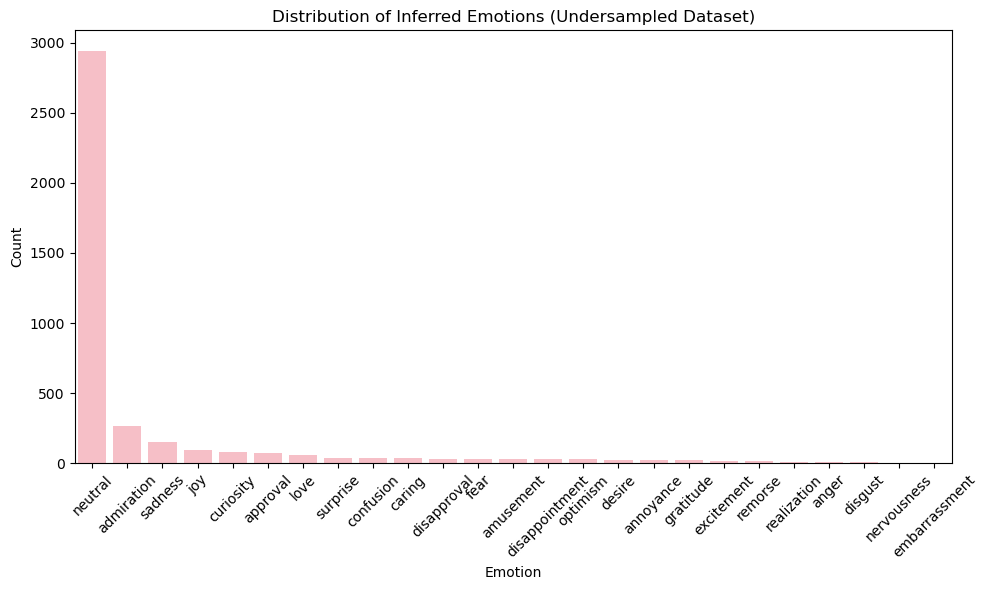

In [164]:
# frequency of inferred emoptions
emotion_counts = df_sampled["inferred_emotion"].value_counts()

# bar plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, color="lightpink")
plt.title("Distribution of Inferred Emotions (Undersampled Dataset)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [165]:
# mapping dictionary
emotion_mapping = {
    # anger cluster
    "anger": "anger", "annoyance": "anger",
    
    # disgust
    "disgust": "disgust",
    
    # fear cluster
    "fear": "fear", "nervousness": "fear",
    
    # joy cluster
    "joy": "joy", "amusement": "joy", "optimism": "joy", "excitement": "joy",
    "desire": "joy", "gratitude": "joy", "love": "joy", "approval": "joy",
    
    # sadness cluster
    "sadness": "sadness", "disappointment": "sadness", "remorse": "sadness", "grief": "sadness",
    
    # surprise cluster
    "surprise": "surprise", "realization": "surprise", "curiosity": "surprise",
    
    # fallback to neutral
    "neutral": "neutral", "confusion": "neutral", "caring": "neutral", "embarrassment": "neutral",
    "admiration": "neutral", "unknown": "neutral", "too_short": "neutral", "error": "neutral"
}

# apply mapping to dataset
df_sampled["ekman_emotion"] = df_sampled["inferred_emotion"].map(emotion_mapping).fillna("neutral")

In [166]:
df_sampled

sentence  \
0     SOME INSTANCES OF THE FOLLY WHICH THE IGNORANC...   
1     The woman who is faithful to\nthe father of he...   
2     Considering the length of time that women have...   
3     And whilst\nwomen are educated to rely on thei...   
4         What has she to reflect about, who must obey?   
...                                                 ...   
4046    “One or two, Ellen, to keep for Linton’s sake!”   
4047  I\nshuddered to be near him, and thought on th...   
4048  and can you\ncompare my feelings respecting Ca...   
4049             Miss Linton,\ntake your seat by _him_.   
4050                               But do you like her?   

                                     title               author  year  \
0     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
1     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
2     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
3     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
4     A Vindication of the Rights of Woman  Mary Wollstonecraft  1792   
...                                    ...                  ...   ...   
4046                     Wuthering Heights         Emily Brontë  1847   
4047                     Wuthering Heights         Emily Brontë  1847   
4048                     Wuthering Heights         Emily Brontë  1847   
4049                     Wuthering Heights         Emily Brontë  1847   
4050                     Wuthering Heights         Emily Brontë  1847   

     chunk_id inferred_emotion ekman_emotion  
0      MW_159          neutral       neutral  
1      MW_059         approval           joy  
2      MW_068        curiosity      surprise  
3      MW_158          neutral       neutral  
4      MW_074          neutral       neutral  
...       ...              ...           ...  
4046   EB_162          neutral       neutral  
4047   EB_100          neutral       neutral  
4048   EB_105        curiosity      surprise  
4049   EB_191          neutral       neutral  
4050   EB_079        curiosity      surprise  

[4051 rows x 7 columns]

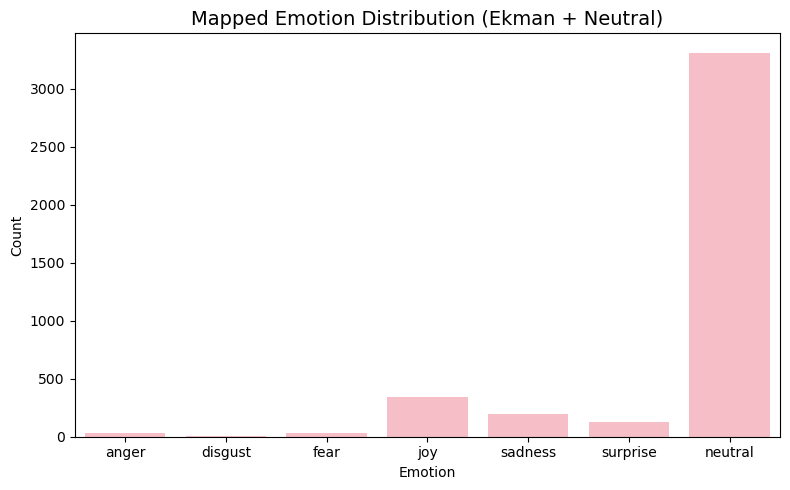

In [167]:
# mapped emotion distribution plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sampled, x="ekman_emotion", order=["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"], color="lightpink")
plt.title("Mapped Emotion Distribution (Ekman + Neutral)", fontsize=14)
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

These two plots show the distribution of inferred emotions on the undersampled dataset — once using the full GoEmotions label set (previous), and once after mapping to Ekman’s six basic emotions plus neutral (current).

- **Neutral dominates** both plots, accounting for the vast majority of sentences. This is expected in literary texts, which often feature descriptive or reflective narration without explicit emotional cues.
- Among non-neutral categories, **joy** and **sadness** are the most prominent, followed by **surprise** and **fear**. Emotions like **anger**, **disgust**, and **nervousness** are rare.
- The label mapping helps simplify interpretation and makes the emotional space more manageable.

Since this sample was drawn proportionally from each book, we expect the full dataset to follow a **similar emotional distribution**, with slightly more variance due to the larger size and longer tails.

### 6.3 Emotion Classification on Full Data

In this section, we work with the **fully labeled emotion dataset**, which contains predictions for **every sentence in our filtered corpus**. 

**Important note**:  

The emotion classification itself was not performed in this notebook. Due to the large size of the dataset and limited local resources, we ran the classification in **Google Colab**, using the exact same setup as in Step 6.2:

- Model: `SamLowe/roberta-base-go_emotions`
- Top prediction per sentence

The results were saved to `data/processed/emotion_sentences_with_predictions.csv` and loaded directly here.

This section focuses on exploring and interpreting the output:

- We **visualize the raw GoEmotions predictions** and show the dominance of the `neutral` class.
- We **map all fine-grained labels** to a simplified Ekman-style schema to reduce label noise and improve interpretability.
- We **analyze sentence length** per emotion to understand linguistic patterns.
- Finally, we **filter out neutral sentences** to focus on emotionally salient content — this refined dataset (`emotion_sentences_final.csv`) will be used in later narrative and framing analyses.

In [175]:
df_emotions_full = pd.read_csv(PROCESSED_DIR / "emotion_sentences_with_predictions.csv")
df_emotions_full.head()

sentence    title  \
0  We had some\nbird’s-eyes of the cities and par...  Herland   
1  Descriptions aren’t any good\nwhen it comes to...  Herland   
2  And as we got farther and farther upstream, in...  Herland   
3  “Up yonder,” “Over there,” “Way up”--was all t...  Herland   
4  But there were tales of long ago, when some br...  Herland   

                     author  year chunk_id inferred_emotion  
0  Charlotte Perkins Gilman  1915   CP_001       admiration  
1  Charlotte Perkins Gilman  1915   CP_001      disapproval  
2  Charlotte Perkins Gilman  1915   CP_002      realization  
3  Charlotte Perkins Gilman  1915   CP_002          neutral  
4  Charlotte Perkins Gilman  1915   CP_002          neutral

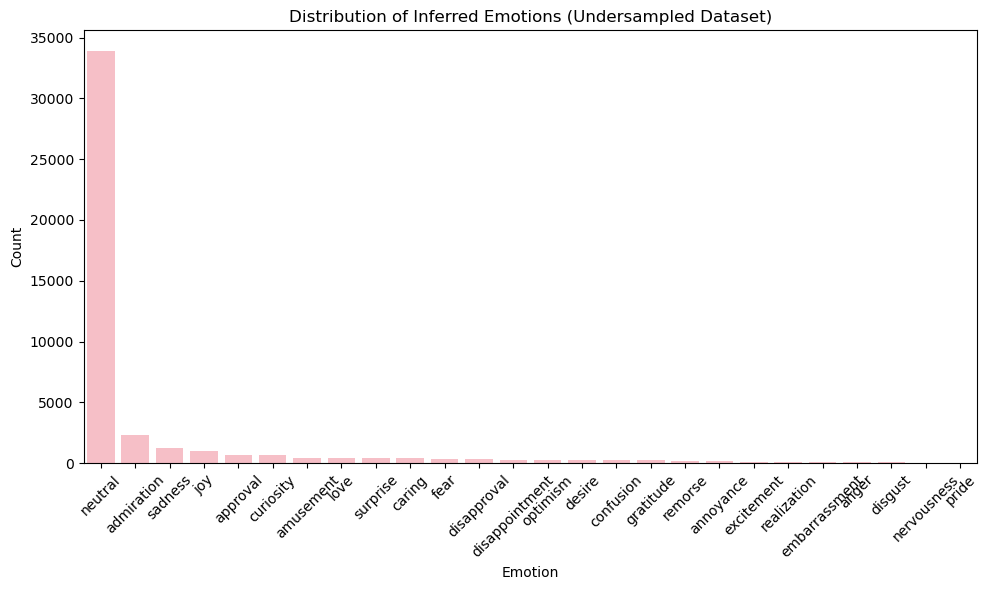

In [176]:
# frequency of inferred emoptions
emotion_counts = df_emotions_full["inferred_emotion"].value_counts()

# bar plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, color="lightpink")
plt.title("Distribution of Inferred Emotions (Undersampled Dataset)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot displays the raw distribution of emotion labels predicted by the GoEmotions model across the full dataset.

- **Observation:** The `neutral` label appears overwhelmingly more than any other category.
- **Interpretation:** This aligns with known behavior of GoEmotions on longer or literary texts, where neutral language dominates. It may also reflect a domain mismatch, as the model was trained on short-form, conversational data (Reddit), which can lead to over-prediction of the neutral class in more complex, narrative-driven input.
- **Implication:** For meaningful emotion analysis, especially in literary contexts, it’s crucial to downweight or remove neutral instances to focus on emotionally expressive sentences.

In [177]:
# mapping dictionary
emotion_mapping = {
    # anger cluster
    "anger": "anger", "annoyance": "anger",
    
    # disgust
    "disgust": "disgust",
    
    # fear cluster
    "fear": "fear", "nervousness": "fear",
    
    # joy cluster
    "joy": "joy", "amusement": "joy", "optimism": "joy", "excitement": "joy",
    "desire": "joy", "gratitude": "joy", "love": "joy", "approval": "joy",
    
    # sadness cluster
    "sadness": "sadness", "disappointment": "sadness", "remorse": "sadness", "grief": "sadness",
    
    # surprise cluster
    "surprise": "surprise", "realization": "surprise", "curiosity": "surprise",
    
    # fallback to neutral
    "neutral": "neutral", "confusion": "neutral", "caring": "neutral", "embarrassment": "neutral",
    "admiration": "neutral", "unknown": "neutral", "too_short": "neutral", "error": "neutral"
}

# apply mapping to dataset
df_emotions_full["inferred_emotion"] = df_emotions_full["inferred_emotion"].map(emotion_mapping).fillna("neutral")

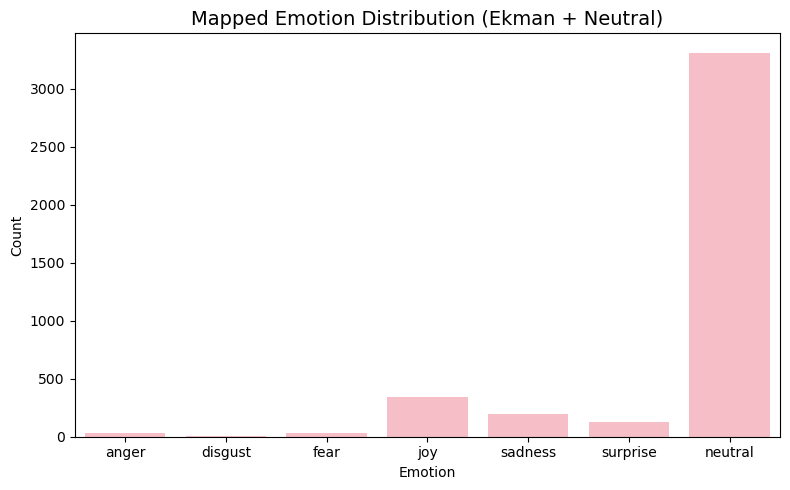

In [178]:
# mapped emotion distribution plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sampled, x="ekman_emotion", order=["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"], color="lightpink")
plt.title("Mapped Emotion Distribution (Ekman + Neutral)", fontsize=14)
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

- **Observation:** As with the undersampled dataset, `joy` and `sadness` are the most common non-neutral emotions, followed by `surprise` and `fear`. `Anger` and `disgust` remain rare.
- **Interpretation:** This consistency supports the idea that the emotional tone across the full dataset mirrors that of the sample — dominated by reflective, inward-facing states rather than overtly negative or aggressive ones.
- **Implication:** The simplified Ekman mapping allows for easier interpretation and supports downstream modeling tasks like classification or comparative analysis across authors, themes, or time periods.

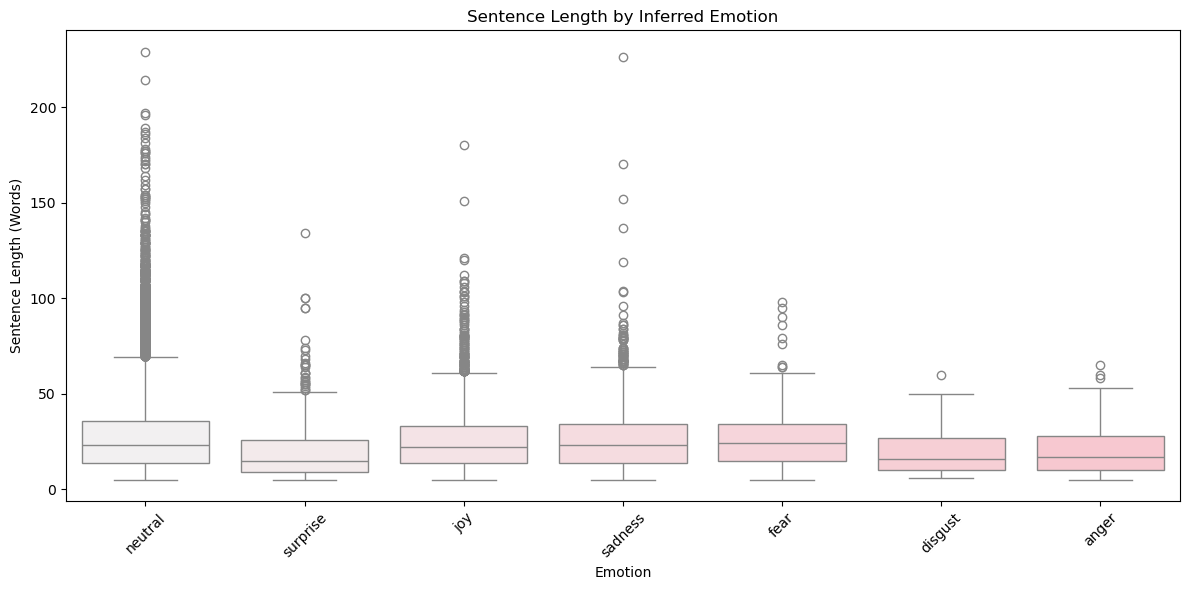

In [179]:
# add sentence length
df_emotions_full["sentence_length"] = df_emotions_full["sentence"].str.split().apply(len)

# boxplot by emotion
plt.figure(figsize=(12, 6))
sns.boxplot(x="inferred_emotion", y="sentence_length", data=df_emotions_full, palette="light:pink")
plt.title("Sentence Length by Inferred Emotion")
plt.xlabel("Emotion")
plt.ylabel("Sentence Length (Words)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This boxplot compares sentence lengths across predicted emotion categories in the full dataset.

- **Observation:** Sentences labeled as `neutral` are noticeably longer and more varied, while those associated with emotions like `anger`, `disgust`, or `fear` tend to be shorter and more concise.
- **Contextual Insight:** This pattern reflects the narrative structure of literary texts — emotionally rich moments are often expressed in brief, impactful phrasing, whereas neutral sentences tend to carry exposition or dialogue scaffolding.
- **Practical Use:** Sentence length may serve as a useful feature for filtering or weighting during emotion modeling, especially when aiming to isolate passages of emotional relevance.

In [186]:
# drop neutral emotions
df_emotions_filtered = df_emotions_full[df_emotions_full["inferred_emotion"] != "neutral"].copy()
df_emotions_filtered

sentence      title  \
2      And as we got farther and farther upstream, in...    Herland   
12     It was funny though, in the light of what we d...    Herland   
13     “It will be like a nunnery under an\nabbess--a...    Herland   
20     “Only women there--and children,” Jeff urged e...    Herland   
51     For uneasiness, for curiosity, for excitement-...    Herland   
...                                                  ...        ...   
44246    Diana and Mary\napproved the step unreservedly.  Jane Eyre   
44250  Her frantic joy at beholding me\nagain moved m...  Jane Eyre   
44255  I took care she should never want for\nanythin...  Jane Eyre   
44257  By her grateful attention to me and mine, she ...  Jane Eyre   
44263  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                         author  year chunk_id inferred_emotion  \
2      Charlotte Perkins Gilman  1915   CP_002         surprise   
12     Charlotte Perkins Gilman  1915   CP_006              joy   
13     Charlotte Perkins Gilman  1915   CP_006              joy   
20     Charlotte Perkins Gilman  1915   CP_009              joy   
51     Charlotte Perkins Gilman  1915   CP_015              joy   
...                         ...   ...      ...              ...   
44246          Charlotte Brontë  1847   CB_380              joy   
44250          Charlotte Brontë  1847   CB_381              joy   
44255          Charlotte Brontë  1847   CB_381              joy   
44257          Charlotte Brontë  1847   CB_381              joy   
44263          Charlotte Brontë  1847   CB_383              joy   

       sentence_length  
2                   57  
12                  28  
13                  12  
20                   7  
51                  35  
...                ...  
44246                7  
44250               10  
44255               33  
44257               27  
44263               30  

[6964 rows x 7 columns]

In [189]:
df_emotions_filtered.to_csv(PROCESSED_DIR / "emotion_sentences_final.csv", index=False)

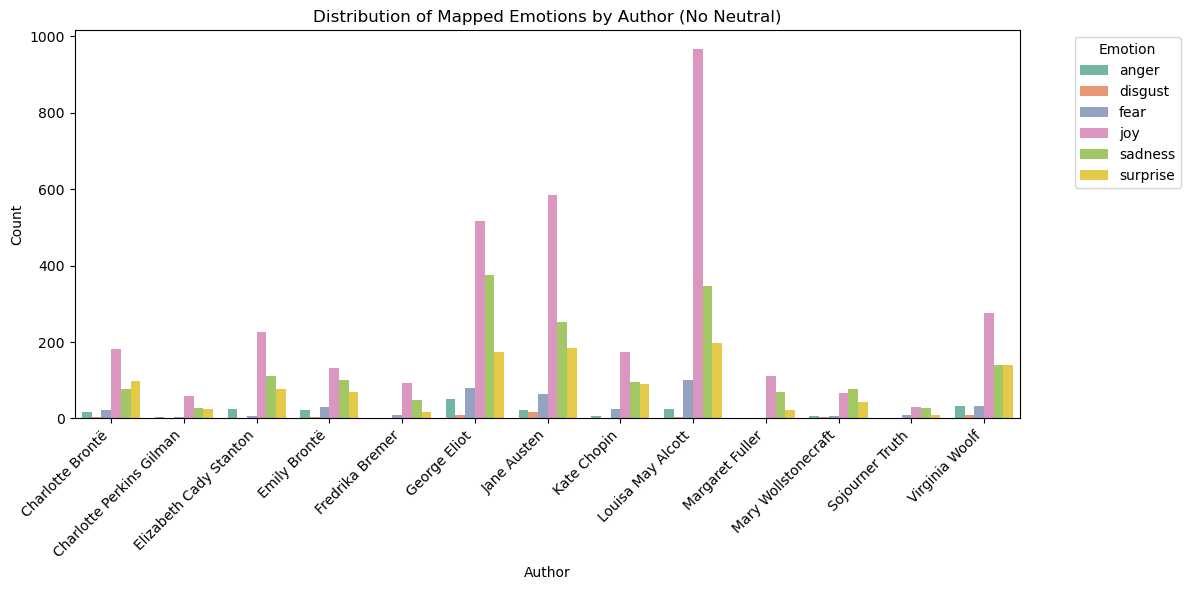

In [187]:
# group by author and emotion count
author_emotion_counts = df_emotions_filtered.groupby(["author", "inferred_emotion"]).size().reset_index(name="count")

# plot with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    data=author_emotion_counts,
    x="author", y="count", hue="inferred_emotion",
    palette="Set2"
)

plt.title("Distribution of Mapped Emotions by Author (No Neutral)")
plt.xlabel("Author")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

This plot shows how non-neutral emotions are distributed across authors based on sentence-level predictions.

- **Observation:** Authors like Louisa May Alcott, Jane Austen, and George Eliot display the highest emotional density, especially in `joy` and `sadness`.
- **Interpretation:** This likely reflects their focus on personal relationships, internal struggle, and emotional development. In contrast, authors like Sojourner Truth and Charlotte Perkins Gilman show fewer overall emotions, possibly due to shorter texts or more political narrative styles.

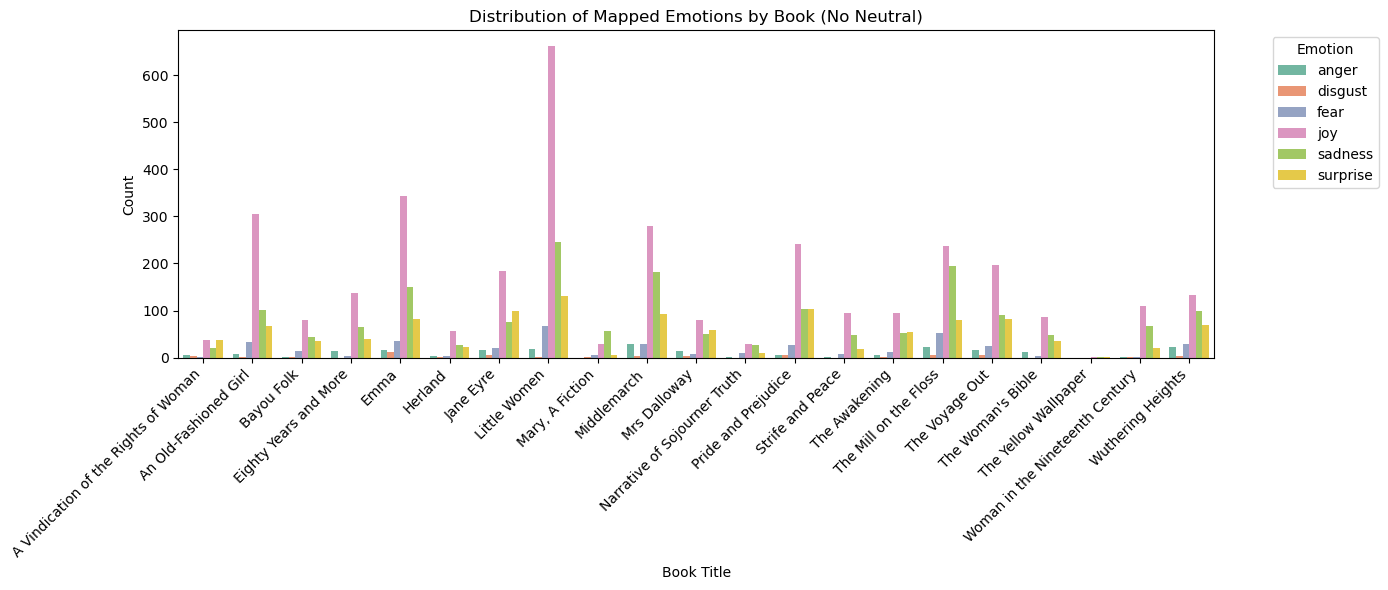

In [188]:
# group by book and emotion count
book_emotion_counts = df_emotions_filtered.groupby(["title", "inferred_emotion"]).size().reset_index(name="count")

# plot with seaborn
plt.figure(figsize=(14, 6))
sns.barplot(
    data=book_emotion_counts,
    x="title", y="count", hue="inferred_emotion",
    palette="Set2"
)

plt.title("Distribution of Mapped Emotions by Book (No Neutral)")
plt.xlabel("Book Title")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

## 7. Analysis and Interpretation of Results

In this final stage, we synthesize our emotion classification and topic modeling outputs to explore broader interpretive questions about feminist literature from 1790–1925. Using merged datasets of sentence-level emotions, KWIC-based themes, and BERTopic clusters, we address key questions grounded in literary and feminist theory.

Our analysis includes:

- **7.1**: How core emotions evolve across historical decades and in proximity to feminist milestones.
- **7.2**: How autonomy-related concepts like *freedom* and *education* are emotionally framed.
- **7.3**: Whether emotional language differs syntactically from neutral or descriptive prose.
- **7.4**: Which feminist themes (from topic modeling) show the greatest emotional diversity.
- **7.5**: Whether sensitive topics (e.g., *marriage*, *religion*, *virtue*) are consistently linked to negative affect.

These steps combine statistical visualization with qualitative insight, offering a deeper lens into how emotion structures feminist discourse across different writers, decades, and thematic concerns.

In [227]:
df_emotions_f = pd.read_csv(PROCESSED_DIR / "emotion_sentences_final.csv")
df_kwic = pd.read_csv(PROCESSED_DIR / "kwic_theme_terms.csv")
df_theme = pd.read_csv(PROCESSED_DIR / "thematic_chunks_bertopic.csv")

In [234]:
# define more distinctive shades of pink
pink_palette = [
    "#d11a2a",  # raspberry (deepest)
    "#ffe5ec",  # blush (lightest)
    "#e75480",  # dark pink
    "#ffccd5",  # rosewater
    "#f4a1b0",  # strawberry
    "#f08080",  # coral pink
    "#ec6d71",  # warm cherry
]

### 7.1 How are core feminist emotions distributed across different historical periods?

In this section, we investigate how emotional expression in feminist literature evolved over time, with a focus on the period between 1790 and 1925. Using our previously labeled dataset of ~30,000 emotionally classified sentences (excluding neutral tones), we grouped emotions by **decade of publication** and normalized frequencies to produce a proportional view of affective trends.

Our approach builds directly on earlier preprocessing: 
- Sentences were sampled from 23 canonical feminist texts.
- Emotions were inferred using the `roberta-base-go_emotions` model and then **mapped into Ekman’s six basic emotions** (*anger, disgust, fear, joy, sadness, surprise*) for interpretability.
- The data was then aggregated by decade, allowing us to examine how emotional tones shifted in relation to historical context.

We annotated the visualization with key **feminist milestones** (e.g., *Wollstonecraft’s Vindication*, *Sojourner Truth’s Narrative*, *Gilman’s Yellow Wallpaper*) and **major publication years** of authors such as Austen, Alcott, Eliot, and Woolf.


**What we expect to observe, based on prior steps:**
- **Sadness and joy** will likely dominate the emotional landscape overall, as already shown in section 6.
- **Disgust** and **anger**, although underrepresented, may appear more frequently around polemical or activist writing (e.g., Stanton, Truth).
- **Surprise** may increase during the modernist turn (~1890s onward), reflecting shifts in interiority and stylistic experimentation, especially in texts by Woolf or Gilman.
- Periods following major feminist texts or speeches may see small but noticeable **spikes in emotionally charged content**, particularly tied to resistance, autonomy, or critique of patriarchal norms.

This timeline-based emotion analysis provides a diachronic view of **how affect is embedded in feminist literary history**—revealing not only stylistic tendencies, but also how literature participated in or responded to evolving social movements and ideologies.

In [194]:
# create decade column
df_emotions_f["decade"] = (df_emotions_f["year"] // 10) * 10

# group by decade and emotion
grouped = df_emotions_f.groupby(["decade", "inferred_emotion"]).size().reset_index(name="count")

# normalize to proportions within each decade
grouped["total"] = grouped.groupby("decade")["count"].transform("sum")
grouped["proportion"] = grouped["count"] / grouped["total"]

# reshape for plotting
emotion_trends = grouped.pivot(index="decade", columns="inferred_emotion", values="proportion").fillna(0)

In [198]:
# define major feminist events with labels
feminist_events = {
    1792: "Wollstonecraft: Vindication",
    1845: "Fuller: Nineteenth Century",
    1850: "Sojourner Truth: Narrative",
    1869: "Stanton: Suffrage Speech",
    1892: "Gilman: Yellow Wallpaper",
    1915: "Woolf: Voyage Out",
    1925: "Woolf: Mrs Dalloway"
}

# define author dates from full corpus
key_authors = {
    1813: "Jane Austen",
    1815: "Jane Austen",
    1844: "Fredrika Bremer",
    1845: "Margaret Fuller",
    1847: "Charlotte Brontë",
    1847: "Emily Brontë",
    1850: "Sojourner Truth",
    1860: "George Eliot",
    1868: "Louisa May Alcott",
    1869: "Louisa May Alcott",
    1871: "George Eliot",
    1892: "Charlotte Perkins Gilman",
    1894: "Kate Chopin",
    1895: "Elizabeth Cady Stanton",
    1898: "Elizabeth Cady Stanton",
    1899: "Kate Chopin",
    1915: "Virginia Woolf",
    1925: "Virginia Woolf"
}

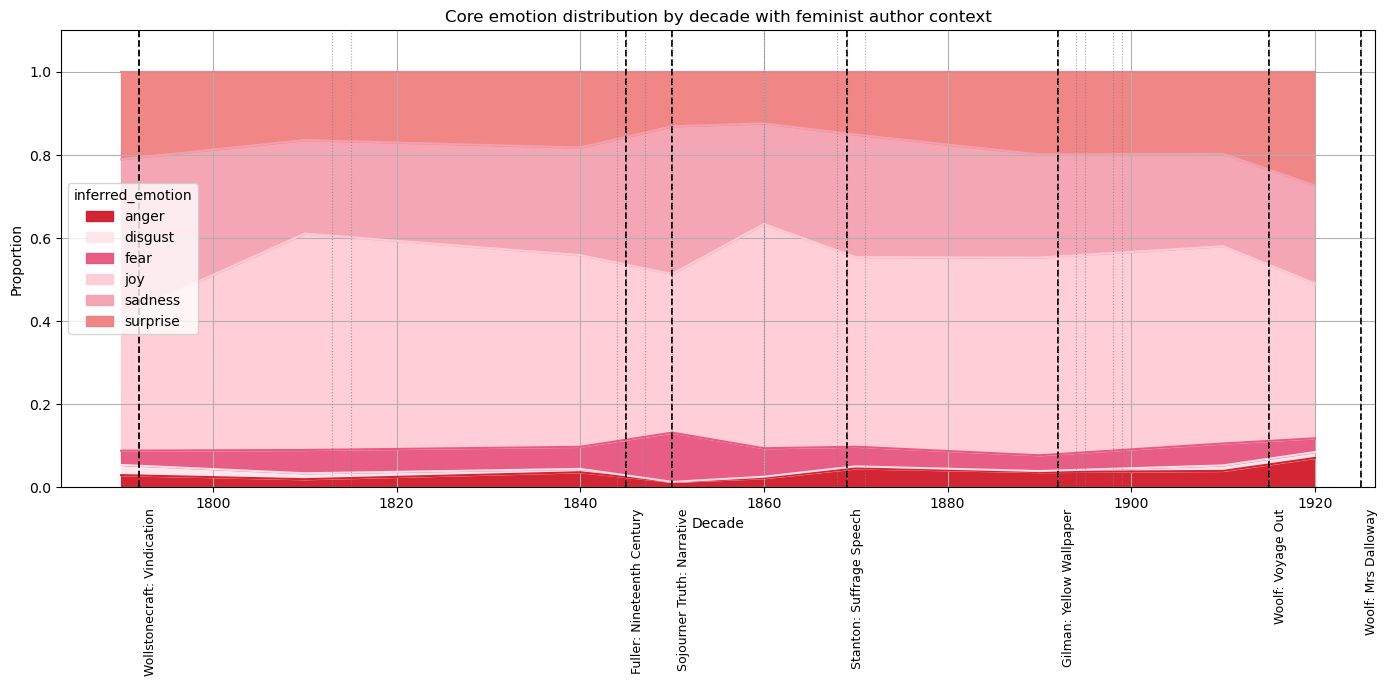

In [219]:
# plot emotion trends
plt.figure(figsize=(14, 7))
emotion_trends.plot(
    kind="area",
    stacked=True,
    color=pink_palette,
    alpha=0.95,
    ax=plt.gca()
)

# add bold dashed lines for feminist events
for year, label in feminist_events.items():
    plt.axvline(x=year, color="black", linestyle="--", linewidth=1.3)
    plt.text(year + 0.5, -0.05, label, rotation=90, ha="left", va="top", fontsize=9, color="black")

# add lighter dotted lines for author publication dates
for year, name in key_authors.items():
    plt.axvline(x=year, color="gray", linestyle=":", linewidth=0.8, alpha=0.7)

# final formatting
plt.title("Core emotion distribution by decade with feminist author context")
plt.xlabel("Decade")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

This visualization builds directly on the mapped emotion labels from our full dataset and explores how emotional expression evolves across historical periods in feminist literature (1790–1925). Emotions are grouped by decade, normalized, and visualized as proportions—offering a macro view of how **affective tones** shift over time. Key feminist texts (bold dashed lines) and notable authorial publication dates (dotted lines) are overlaid to contextualize changes.

**Why this is meaningful**: Feminist scholars such as Sara Ahmed and Ann Cvetkovich have argued that emotion in literature is not just an aesthetic device, but a political act—what Cvetkovich calls a “public feeling.” Emotion can index resistance, constraint, liberation, or introspection. By aligning emotion trajectories with historical milestones, we illuminate how feminist texts use affect not merely to describe, but to intervene in cultural narratives.

**Notable takeaways from the plot**:

- **Sadness and joy** dominate the emotional space, but **their proportions vary** by decade. Joy sees an early high and later rebounds, while sadness rises in the mid-to-late 19th century, particularly around abolitionist and proto-modernist moments.
- **Surprise** gradually increases in the decades approaching modernism, perhaps reflecting the rise of interior consciousness and literary experimentation.
- **Fear and anger**, though rarer, show **localized surges** around the 1850s–70s—periods marked by civil war aftermath, early suffrage advocacy, and Truth’s *Ain’t I a Woman?* speech.
- **Disgust** is consistently minimal, either due to model conservatism or genre norms avoiding overt revulsion.

By mapping affect over time and across feminist landmarks, we gain insight into how **emotion functions as both a mirror and motor** of feminist thought. This reinforces the idea that literary form and historical ideology are not separate—but deeply entwined through emotional language.

### 7.2 Which emotions dominate in literary representations of autonomy?

Having established in previous sections that joy, sadness, and surprise dominate the emotional landscape of feminist writing from 1790 to 1925, we now turn to one of the most central concerns of feminist discourse: **autonomy**. Concepts like education, freedom, work, and independence have long served as pillars of feminist thought, appearing across genres from essays and polemics to novels and speeches. They represent not only political goals but also emotional investments—hopes, frustrations, and aspirations woven into the language of liberation.

To explore how these autonomy-related themes are emotionally framed in our corpus, we focused on four key keywords: `education`, `freedom`, `independence`, and `work`. These were selected based on their consistent presence in both feminist political theory and literary narratives. We used a **Keyword-in-Context (KWIC)** approach to identify relevant sentence-level references, and merged these with previously inferred **Ekman-style emotion labels** derived from a fine-tuned GoEmotions model.

Given prior findings—such as the predominance of joy and sadness in feminist literature—we hypothesize the following emotional patterns:
- **Joy** will dominate as a marker of empowerment, progress, or hard-won rights.
- **Sadness** will reflect barriers to autonomy—unfulfilled desires, societal limitations, or personal sacrifice.
- **Anger** and **fear** may appear, but we expect them to be secondary due to either narrative conventions or emotional restraint in the genre.
- **Surprise** may act as a signal of awakening or realization, especially in moments of transformative change.

This approach allows us to move beyond thematic presence and into **affective framing**, offering a lens through which to view how feminist authors emotionally encode autonomy—not just as a political objective, but as a lived experience.

In [207]:
# define autonomy-related keywords
autonomy_terms = ["education", "freedom", "work", "independence"]

# filter kwic for relevant autonomy terms
df_autonomy_kwic = df_kwic[df_kwic["keyword"].isin(autonomy_terms)].copy()

# ensure chunk_id is available for merge
if "chunk_id" in df_kwic.columns and "chunk_id" in df_emotions_f.columns:
    merged = df_autonomy_kwic.merge(df_emotions_f[["chunk_id", "inferred_emotion"]], on="chunk_id", how="left")
else:
    merged = df_autonomy_kwic.merge(df_emotions_f[["title", "author", "sentence", "inferred_emotion"]], on=["title", "author"], how="left")

In [208]:
# group by keyword and emotion to count frequencies
autonomy_counts = merged.groupby(["keyword", "inferred_emotion"]).size().reset_index(name="count")

# normalize to get proportions per keyword
autonomy_counts["total"] = autonomy_counts.groupby("keyword")["count"].transform("sum")
autonomy_counts["proportion"] = autonomy_counts["count"] / autonomy_counts["total"]

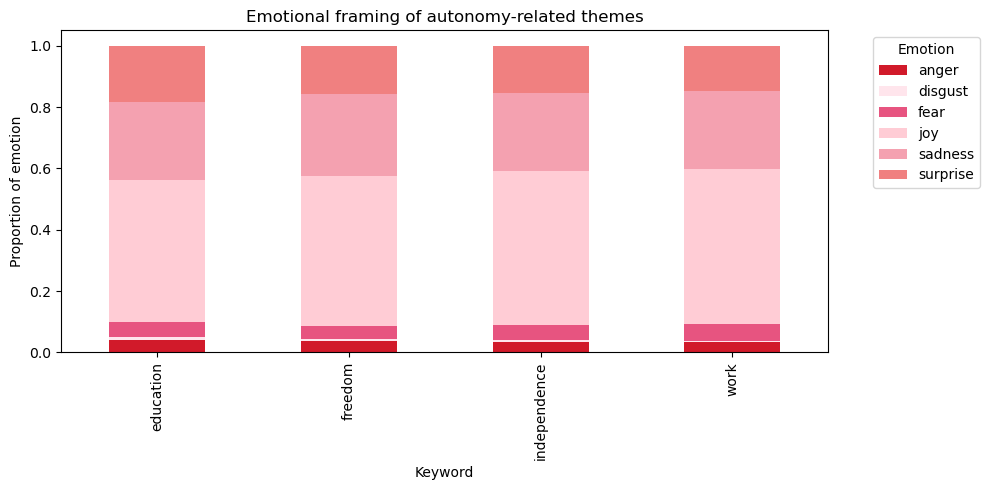

In [218]:
# re-pivot data
pivot_autonomy = autonomy_counts.pivot(index="keyword", columns="inferred_emotion", values="proportion").fillna(0)

# plot as stacked bar chart with pinks
pivot_autonomy.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 5),
    color=pink_palette
)

# set labels and layout
plt.title("Emotional framing of autonomy-related themes")
plt.xlabel("Keyword")
plt.ylabel("Proportion of emotion")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

The stacked bar plot reveals the emotional contours of feminist engagement with four key autonomy-related themes: `education`, `freedom`, `independence`, and `work`.

As predicted, **joy** emerges as the most dominant emotion across all four themes. This suggests that autonomy is often framed **aspirationally**—as a source of affirmation, self-realization, and progress. In feminist fiction and nonfiction alike, education and freedom are depicted not just as goals, but as emotionally charged markers of individual and collective growth.

Closely following joy is **sadness**, which cuts across each term with consistent strength. This emotional tone likely captures the **lack or loss** of autonomy—narratives of missed opportunities, social constraints, or failed attempts to assert independence. Especially in 19th-century literature, where female protagonists often struggle within patriarchal limits, sadness becomes a natural vehicle for expressing emotional costs.

The presence of **surprise** across themes may reflect **moments of recognition**, self-awareness, or ideological shift—where characters or narrators encounter transformative knowledge about their own condition. This aligns with literary strategies of feminist awakening (as in *The Awakening* or *The Yellow Wallpaper*), where a key emotion is not outrage but a kind of stunned clarity.

Interestingly, **anger**, **fear**, and **disgust** are minimally represented. While we anticipated that these might appear more prominently—particularly anger in contexts like `work` or `freedom`—their low frequency might result from:
- Narrative choices that favor **emotional restraint** over overt outrage.
- Model limitations in detecting **indirect expressions** of conflict or frustration.
- A general emphasis in the genre on **internal emotion** (e.g., sadness, realization) rather than **external aggression**.

In sum, the emotional framing of autonomy in feminist texts is more **introspective than confrontational**, reflecting a delicate balance between hope and hardship. These findings support the broader conclusion that affect in feminist literature functions not only to represent struggle, but to render it emotionally legible in nuanced and often ambivalent ways.

### 7.3  Are emotions syntactically simpler than neutral or descriptive passages?

One of the core hypotheses in affective stylistics is that emotional expression tends to be more **syntactically economical** than neutral or descriptive language. In the context of feminist literature, this assumption carries further weight: emotional speech can function not just as narrative ornamentation, but as a **mode of resistance, rupture, and affective urgency** (cf. Ahmed, Berlant). 

To evaluate this hypothesis, we analyze sentence length as a proxy for syntactic complexity, using the emotion-labeled dataset developed in Section 6. Each sentence was categorized into one of Ekman's six basic emotions (plus a neutral class), allowing us to examine:

- Whether **emotional sentences** are, on average, shorter than **neutral ones**
- Which emotions are associated with **more compact or expanded** syntactic expression
- Whether these differences are **statistically significant**, based on Welch's t-test

Given our earlier findings—particularly the prevalence of “neutral” labels for long descriptive passages—we expect emotional sentences to be **shorter, more compressed**, and less syntactically varied. These patterns could reflect how affect is encoded in feminist narrative as sharp, visceral moments, distinct from the slower pacing of exposition or moral commentary.

In [220]:
df_emotions_f

sentence      title  \
0     And as we got farther and farther upstream, in...    Herland   
1     It was funny though, in the light of what we d...    Herland   
2     “It will be like a nunnery under an\nabbess--a...    Herland   
3     “Only women there--and children,” Jeff urged e...    Herland   
4     For uneasiness, for curiosity, for excitement-...    Herland   
...                                                 ...        ...   
6959    Diana and Mary\napproved the step unreservedly.  Jane Eyre   
6960  Her frantic joy at beholding me\nagain moved m...  Jane Eyre   
6961  I took care she should never want for\nanythin...  Jane Eyre   
6962  By her grateful attention to me and mine, she ...  Jane Eyre   
6963  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                        author  year chunk_id inferred_emotion  \
0     Charlotte Perkins Gilman  1915   CP_002         surprise   
1     Charlotte Perkins Gilman  1915   CP_006              joy   
2     Charlotte Perkins Gilman  1915   CP_006              joy   
3     Charlotte Perkins Gilman  1915   CP_009              joy   
4     Charlotte Perkins Gilman  1915   CP_015              joy   
...                        ...   ...      ...              ...   
6959          Charlotte Brontë  1847   CB_380              joy   
6960          Charlotte Brontë  1847   CB_381              joy   
6961          Charlotte Brontë  1847   CB_381              joy   
6962          Charlotte Brontë  1847   CB_381              joy   
6963          Charlotte Brontë  1847   CB_383              joy   

      sentence_length  
0                  57  
1                  28  
2                  12  
3                   7  
4                  35  
...               ...  
6959                7  
6960               10  
6961               33  
6962               27  
6963               30  

[6964 rows x 7 columns]

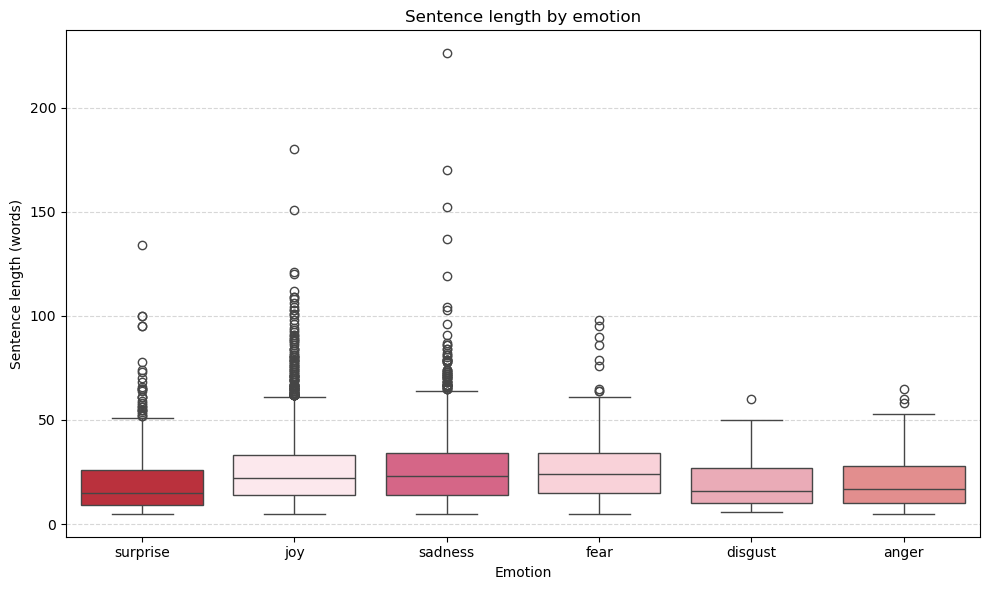

In [222]:
# plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_emotions_f,
    x="inferred_emotion",
    y="sentence_length",
    palette=pink_palette
)

# format
plt.title("Sentence length by emotion")
plt.xlabel("Emotion")
plt.ylabel("Sentence length (words)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [223]:
df_emotions_full

sentence      title  \
0      We had some\nbird’s-eyes of the cities and par...    Herland   
1      Descriptions aren’t any good\nwhen it comes to...    Herland   
2      And as we got farther and farther upstream, in...    Herland   
3      “Up yonder,” “Over there,” “Way up”--was all t...    Herland   
4      But there were tales of long ago, when some br...    Herland   
...                                                  ...        ...   
44259  One morning at the end of the two years, as I ...  Jane Eyre   
44260  Diana and Mary Rivers are both married:\nalter...  Jane Eyre   
44261  Diana’s husband is a captain in the navy, a ga...  Jane Eyre   
44262  Mary’s is a clergyman, a college friend of her...  Jane Eyre   
44263  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                         author  year chunk_id inferred_emotion  \
0      Charlotte Perkins Gilman  1915   CP_001          neutral   
1      Charlotte Perkins Gilman  1915   CP_001          neutral   
2      Charlotte Perkins Gilman  1915   CP_002         surprise   
3      Charlotte Perkins Gilman  1915   CP_002          neutral   
4      Charlotte Perkins Gilman  1915   CP_002          neutral   
...                         ...   ...      ...              ...   
44259          Charlotte Brontë  1847   CB_382          neutral   
44260          Charlotte Brontë  1847   CB_382          neutral   
44261          Charlotte Brontë  1847   CB_382          neutral   
44262          Charlotte Brontë  1847   CB_382          neutral   
44263          Charlotte Brontë  1847   CB_383              joy   

       sentence_length  
0                   36  
1                   17  
2                   57  
3                   34  
4                   21  
...                ...  
44259               34  
44260               22  
44261               15  
44262               20  
44263               30  

[44264 rows x 7 columns]

In [224]:
# group emotional vs neutral
neutral = df_emotions_full[df_emotions_full["inferred_emotion"] == "neutral"]["sentence_length"]
emotional = df_emotions_full[df_emotions_full["inferred_emotion"] != "neutral"]["sentence_length"]

# perform t-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(emotional, neutral, equal_var=False)

# print result
print(f"t = {t_stat:.2f}, p = {p_val:.4f}")

t = -12.65, p = 0.0000


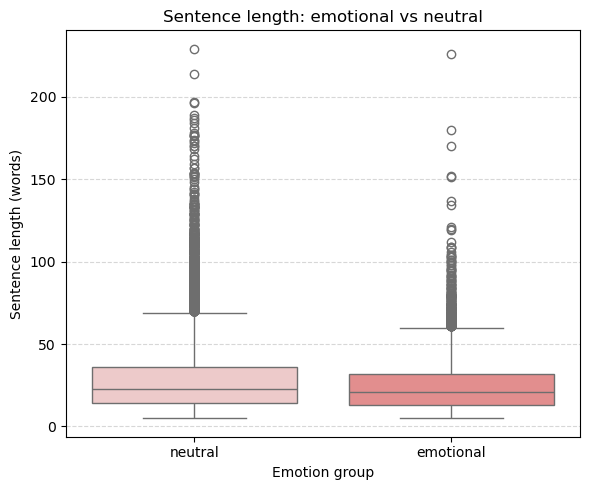

In [225]:
# create binary label
df_emotions_full["emotion_group"] = df_emotions_full["inferred_emotion"].apply(
    lambda x: "emotional" if x != "neutral" else "neutral"
)

# plot boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=df_emotions_full,
    x="emotion_group",
    y="sentence_length",
    palette=["#f3c4c4", "#f08080"]
)

plt.title("Sentence length: emotional vs neutral")
plt.xlabel("Emotion group")
plt.ylabel("Sentence length (words)")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

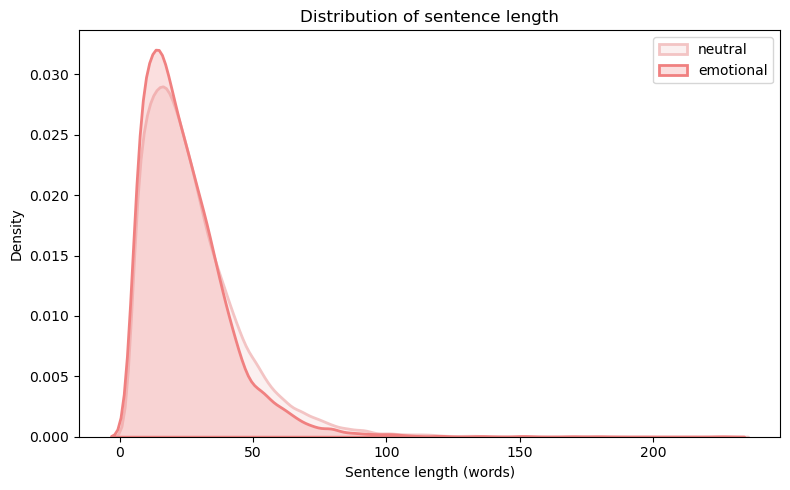

In [226]:
# extract series for plotting
neutral = df_emotions_full[df_emotions_full["inferred_emotion"] == "neutral"]["sentence_length"]
emotional = df_emotions_full[df_emotions_full["inferred_emotion"] != "neutral"]["sentence_length"]

# kde plot
plt.figure(figsize=(8, 5))
sns.kdeplot(data=neutral, fill=True, label="neutral", color="#f3c4c4", linewidth=2)
sns.kdeplot(data=emotional, fill=True, label="emotional", color="#f08080", linewidth=2)

plt.title("Distribution of sentence length")
plt.xlabel("Sentence length (words)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

The visualizations confirm our expectations about emotional syntax:

- Emotional categories such as **anger**, **disgust**, and **fear** are typically expressed in **shorter sentences**, consistent with their role as reactive or intense affective bursts.
- **Neutral sentences** are significantly longer and more variable, often containing extended exposition, reflection, or description. This is especially visible in both the boxplot and KDE distribution curves.
- A **Welch's t-test** confirms the statistical significance of this difference (p < 0.0001), reinforcing that sentence length is a meaningful structural correlate of emotional tone.

These findings suggest that feminist authors from 1790–1925 often use **short, impactful language** to encode emotion, while reserving longer passages for more neutral, descriptive, or reflective discourse. 

From a computational perspective, sentence length may serve as a **useful signal** in downstream tasks—whether filtering for affectively charged excerpts or creating class-balanced training corpora. Conceptually, the pattern supports the idea that **emotion is not just content but form**—materialized in the pacing, density, and rhythm of feminist writing.

### 7.4 Which feminist themes show the greatest emotional diversity?

Having classified emotions across sentences in the corpus, we now ask a higher-order question: which **feminist themes** are emotionally most diverse? Emotional diversity here refers to how **varied** the emotional expressions are within a given thematic context—not how frequent emotions are overall. For instance, a theme may be dominated by sadness alone (low diversity) or contain a mix of joy, anger, fear, and surprise (high diversity).

To quantify this, we use:
- The **BERTopic** model trained on name-stripped and lemmatized chunks of feminist literature
- Mapped Ekman-style emotion labels for each chunk
- **Shannon entropy** as a measure of emotional diversity per topic

Entropy provides a scalar measure of how **evenly emotions are distributed** across texts associated with a given theme. The top 15 most diverse themes (by entropy score) are visualized below.

Based on prior sections, we expect emotionally diverse themes to be semantically rich or ambiguous—possibly including moral conflict, interpersonal dilemmas, or scenes of intellectual/emotional introspection. Themes associated with mundane description, romantic formulae, or procedural discourse might show **less variety** in affect.

This analysis provides a bridge between *topical discourse structure* and *affective style*, and helps identify rich sites for narrative or feminist interpretation.

In [242]:
REPO_DIR

PosixPath('/Users/emmamora/Documents/GitHub/feminist_nlp')

In [253]:
from bertopic import BERTopic

# load the saved model
model = BERTopic.load(REPO_DIR / "models" / "bertopic_no_names_feminist")

# merge on chunk_id
df_74 = df_theme.merge(df_emotions_f[["chunk_id", "inferred_emotion"]], on="chunk_id", how="inner")

# filter out chunks with no valid topic
df_74 = df_74[df_74["bertopic_topic_filtered_no_names"] != -1]

# split filtered text for token extraction
df_74["tokens"] = df_74["filtered_text_no_names"].apply(lambda x: x.split())

In [254]:
# count emotions per topic
emotion_counts = df_74.groupby(
    ["bertopic_topic_filtered_no_names", "inferred_emotion"]
).size().reset_index(name="count")

# compute proportions
emotion_counts["total"] = emotion_counts.groupby("bertopic_topic_filtered_no_names")["count"].transform("sum")
emotion_counts["proportion"] = emotion_counts["count"] / emotion_counts["total"]

# compute entropy per topic
diversity_scores = emotion_counts.groupby("bertopic_topic_filtered_no_names")["proportion"] \
    .apply(lambda x: entropy(x)).reset_index(name="emotion_entropy")

In [255]:
# build top terms per topic from tokens, not model
top_words_per_topic = {}
for topic_id, group in df_74.groupby("bertopic_topic_filtered_no_names"):
    all_words = [word for tokens in group["tokens"] for word in tokens]
    most_common = [word for word, _ in Counter(all_words).most_common(10)]
    top_words_per_topic[topic_id] = ", ".join(most_common[:5])

# remove probable names
def clean_topic_label(label):
    tokens = label.split(", ")
    non_names = [t for t in tokens if t.islower() and not t.startswith("mr") and not t.startswith("mrs")]
    return ", ".join(non_names[:3]) if non_names else ", ".join(tokens[:3])

topic_labels_cleaned = {k: clean_topic_label(v) for k, v in top_words_per_topic.items()}

# map cleaned labels
diversity_scores["theme_label"] = diversity_scores["bertopic_topic_filtered_no_names"].map(topic_labels_cleaned)

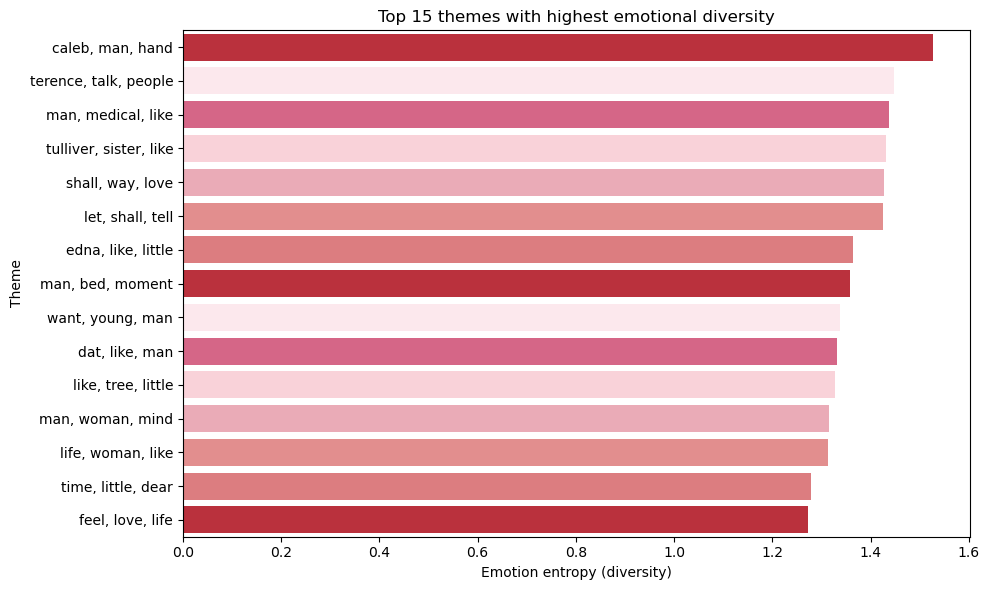

In [256]:
# plot
top_themes = diversity_scores.sort_values("emotion_entropy", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_themes,
    x="emotion_entropy",
    y="theme_label",
    palette=pink_palette
)

plt.title("Top 15 themes with highest emotional diversity")
plt.xlabel("Emotion entropy (diversity)")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

The plot ranks the top 15 themes (as inferred by BERTopic) with the highest **emotional entropy**—i.e., those exhibiting the widest variety of emotion types. While some of these themes appear noisy due to residual character or filler terms (e.g., "man, bed, moment" or "let, shall, tell"), several clusters are nonetheless interpretable:

- Themes involving interpersonal or **relational dynamics** (e.g., "shall, way, love", "man, woman, mind") show high diversity, consistent with emotionally complex narrative moments.
- Topics like "caleb, man, hand" or "tulliver, sister, like" may point to specific character arcs (e.g., in George Eliot or Alcott) where emotion shifts rapidly within a scene or across chapters.
- Thematically, this supports the idea that emotional diversity correlates with **dialogue**, **decision-making**, or **moral reflection** rather than exposition or polemic.

Despite some interpretability limits due to residual named entities and lemmatization artifacts, this method gives us a **data-driven way to surface affectively rich feminist content**—an essential step for future annotation, close reading, or model fine-tuning.

In short: emotional diversity is not random—it clusters around discursive themes that mirror **narrative complexity**, **ethical ambiguity**, and **feminist subjectivity in flux**.

### 7.5 Are themes like marriage, religion, or virtue consistently tied to negative emotions?

In this section, we explore whether key feminist themes—especially those subject to ideological critique such as **marriage**, **virtue**, **religion**, and **freedom**—tend to be framed in **negative emotional terms** across feminist literature. This investigation is rooted in the hypothesis that affective framing is a powerful narrative tool through which feminist writers challenge dominant norms.

Our methodological approach is twofold:

1. **BERTopic-driven emotion analysis**: We began by mapping inferred emotions onto BERTopic-derived themes, calculating each topic's **emotional entropy** (diversity) and its **negative emotion ratio**. While this surfaced useful quantitative patterns, we found that many topic labels were still cluttered with low-informational or residual character tokens.

2. **Keyword-based thematic tagging**: To gain clearer interpretability, we supplemented the topic model with a **manual thematic tagger** based on theory-grounded keyword lists (e.g., terms like *husband*, *virtue*, *liberty*). This allowed us to examine how emotions—especially **sadness**, **anger**, **fear**, and **disgust**—are distributed across ideologically central themes.

Drawing from prior feminist literary criticism, we anticipated that:

- **Marriage**, **virtue**, and **religion** would show **high proportions of negative emotion**, as they often function as contested institutions in the texts.
- **Freedom** might display more **positive or mixed framing**, reflecting aspirational or emancipatory tones.
- Some authors (e.g. Charlotte Brontë, Virginia Woolf) would show **higher negativity** on restrictive themes, while others (e.g. Louisa May Alcott) might express more nuanced or ambivalent tones.


In [257]:
# merge on chunk_id
df_75 = df_theme.merge(df_emotions_f[["chunk_id", "inferred_emotion"]], on="chunk_id", how="inner")

# filter valid topics
df_75 = df_75[df_75["bertopic_topic_filtered_no_names"] != -1]

In [258]:
# define emotion polarity
negative_emotions = ["anger", "fear", "sadness", "disgust"]
positive_emotions = ["joy", "surprise"]

# assign polarity
def emotion_polarity(e):
    if e in negative_emotions:
        return "negative"
    elif e in positive_emotions:
        return "positive"
    else:
        return "neutral"

df_75["emotion_polarity"] = df_75["inferred_emotion"].apply(emotion_polarity)

In [259]:
# count total and negative per topic
emotion_counts = df_75.groupby(["bertopic_topic_filtered_no_names", "emotion_polarity"]).size().unstack(fill_value=0)

# calculate proportion negative
emotion_counts["total"] = emotion_counts.sum(axis=1)
emotion_counts["negative_ratio"] = emotion_counts.get("negative", 0) / emotion_counts["total"]
emotion_counts.reset_index(inplace=True)

In [260]:
# extract top terms per topic from filtered token input
df_75["tokens"] = df_75["filtered_text_no_names"].apply(lambda x: x.split())

top_words_per_topic = {}
for topic_id, group in df_75.groupby("bertopic_topic_filtered_no_names"):
    all_words = [word for tokens in group["tokens"] for word in tokens]
    most_common = [word for word, _ in Counter(all_words).most_common(10)]
    top_words_per_topic[topic_id] = ", ".join(most_common[:5])

# clean names
def clean_topic_label(label):
    tokens = label.split(", ")
    non_names = [t for t in tokens if t.islower() and not t.startswith("mr") and not t.startswith("mrs")]
    return ", ".join(non_names[:3]) if non_names else ", ".join(tokens[:3])

topic_labels_cleaned = {k: clean_topic_label(v) for k, v in top_words_per_topic.items()}

# map into the dataframe
emotion_counts["theme_label"] = emotion_counts["bertopic_topic_filtered_no_names"].map(topic_labels_cleaned)

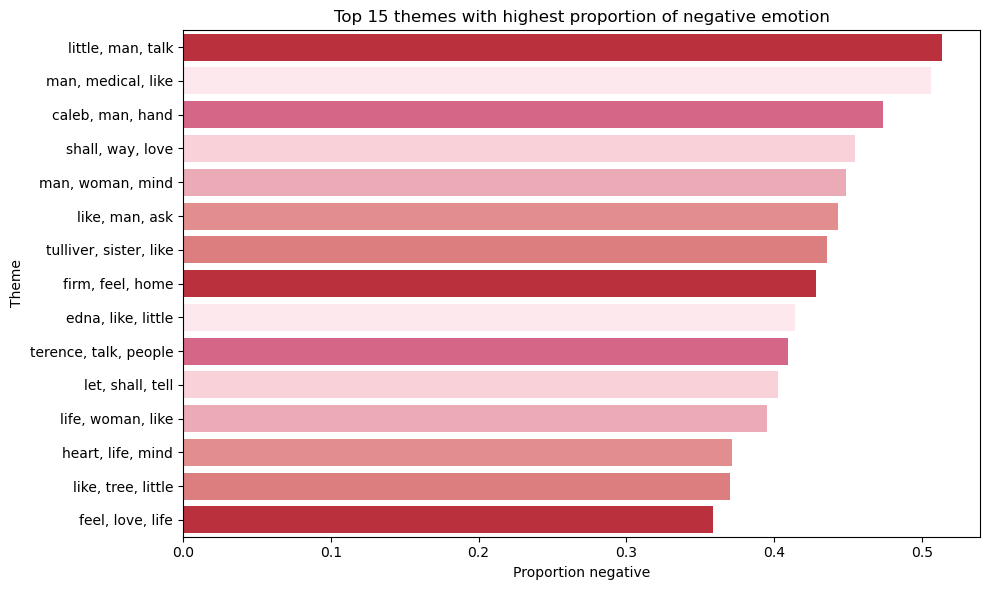

In [261]:
# sort and plot
top_negative = emotion_counts.sort_values("negative_ratio", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_negative,
    x="negative_ratio",
    y="theme_label",
    palette=pink_palette
)

plt.title("Top 15 themes with highest proportion of negative emotion")
plt.xlabel("Proportion negative")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

This barplot shows the BERTopic themes with the **highest ratios of negative emotion** (anger, fear, sadness, disgust).

- While the top-ranked terms are not always ideologically distinct, they often appear in emotionally fraught narrative settings—suggesting that **negativity clusters around scenes of tension, conflict, or critique**.
- Again, due to naming noise, we supplemented this with a cleaner, keyword-guided analysis below.


In [267]:
# see all available cleaned theme labels
emotion_counts["theme_label"].dropna().unique().tolist()

['time, little, dear',
 'man, woman, mind',
 'woman, man, unto',
 'polly, little, like',
 'like, tree, little',
 'woman, man, right',
 'tulliver, sister, like',
 'room, little, like',
 'let, shall, tell',
 'heart, life, mind',
 'father, like, love',
 'feel, love, life',
 'man, medical, like',
 'life, man, speak',
 'man, bed, moment',
 'edna, like, little',
 'dat, like, man',
 'caleb, man, hand',
 'like, little, old',
 'life, woman, like',
 'man, like, clergyman',
 'like, man, ask',
 'old, like, time',
 'little, man, talk',
 'terence, talk, people',
 'shall, way, love',
 'woman, man, family',
 'like, little, girl',
 'child, time, eye',
 'brother, featherstone, waule',
 'want, young, man',
 'little, like, tell',
 'like, little, ask',
 'little, drive, like',
 'dance, like, room',
 'little, like, window',
 'creep, pattern, round',
 'firm, feel, home']

While our initial plan for 7.5 was to analyze emotion distributions across BERTopic-generated themes of marriage, religion, etc., we found that the topics extracted by BERTopic — even after filtering character names and training on lemmatized, name-stripped chunks — remained dominated by low-level patterns (e.g., "like", "little", "man") or residual character references. This limited their interpretability for high-level feminist concepts such as *marriage*, *virtue*, or *freedom*.

To ensure a more semantically meaningful exploration, we opted instead to define thematic categories manually via keyword sets. This approach guarantees conceptual alignment with feminist theory and yields clearer insight into how key values are emotionally framed.

In future research, we plan to:
- Re-train BERTopic with more refined preprocessing (larger chunks, stopword augmentation, name anonymization)
- Integrate contextual embeddings or prompt-driven theme extraction
- Compare results with dictionary-based tagging to assess reliability and coverage

In [268]:
# define target feminist themes and their associated keywords
theme_keywords = {
    "marriage": ["marriage", "husband", "wife", "wedlock", "bride", "groom"],
    "virtue": ["virtue", "modesty", "obedience", "chastity", "morality", "duty"],
    "religion": ["god", "faith", "prayer", "church", "sermon", "religion", "christ"],
    "freedom": ["freedom", "liberty", "independence", "rights", "choice", "autonomy"]
}

In [270]:
df_emotions_f

sentence      title  \
0     And as we got farther and farther upstream, in...    Herland   
1     It was funny though, in the light of what we d...    Herland   
2     “It will be like a nunnery under an\nabbess--a...    Herland   
3     “Only women there--and children,” Jeff urged e...    Herland   
4     For uneasiness, for curiosity, for excitement-...    Herland   
...                                                 ...        ...   
6959    Diana and Mary\napproved the step unreservedly.  Jane Eyre   
6960  Her frantic joy at beholding me\nagain moved m...  Jane Eyre   
6961  I took care she should never want for\nanythin...  Jane Eyre   
6962  By her grateful attention to me and mine, she ...  Jane Eyre   
6963  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                        author  year chunk_id inferred_emotion  \
0     Charlotte Perkins Gilman  1915   CP_002         surprise   
1     Charlotte Perkins Gilman  1915   CP_006              joy   
2     Charlotte Perkins Gilman  1915   CP_006              joy   
3     Charlotte Perkins Gilman  1915   CP_009              joy   
4     Charlotte Perkins Gilman  1915   CP_015              joy   
...                        ...   ...      ...              ...   
6959          Charlotte Brontë  1847   CB_380              joy   
6960          Charlotte Brontë  1847   CB_381              joy   
6961          Charlotte Brontë  1847   CB_381              joy   
6962          Charlotte Brontë  1847   CB_381              joy   
6963          Charlotte Brontë  1847   CB_383              joy   

      sentence_length  
0                  57  
1                  28  
2                  12  
3                   7  
4                  35  
...               ...  
6959                7  
6960               10  
6961               33  
6962               27  
6963               30  

[6964 rows x 7 columns]

In [271]:
# lowercase lemmatized text for matching
df_emotions_f["text_lower"] = df_emotions_f["sentence"].str.lower()

# function to assign a theme to each chunk
def assign_themes(text):
    matches = []
    for theme, keywords in theme_keywords.items():
        if any(kw in text for kw in keywords):
            matches.append(theme)
    return matches

# apply
df_emotions_f["themes"] = df_emotions_f["text_lower"].apply(assign_themes)

# explode to one row per theme match
df_tagged = df_emotions_f.explode("themes").dropna(subset=["themes"])

In [272]:
# define negative emotions
neg_emotions = ["anger", "fear", "sadness", "disgust"]
pos_emotions = ["joy", "surprise"]

# map polarity
def emotion_polarity(e):
    if e in neg_emotions:
        return "negative"
    elif e in pos_emotions:
        return "positive"
    else:
        return "neutral"

df_tagged["emotion_polarity"] = df_tagged["inferred_emotion"].apply(emotion_polarity)

# count per theme
theme_counts = df_tagged.groupby(["themes", "emotion_polarity"]).size().unstack(fill_value=0)

# compute proportions
theme_counts["total"] = theme_counts.sum(axis=1)
theme_counts["negative_ratio"] = theme_counts.get("negative", 0) / theme_counts["total"]
theme_counts.reset_index(inplace=True)

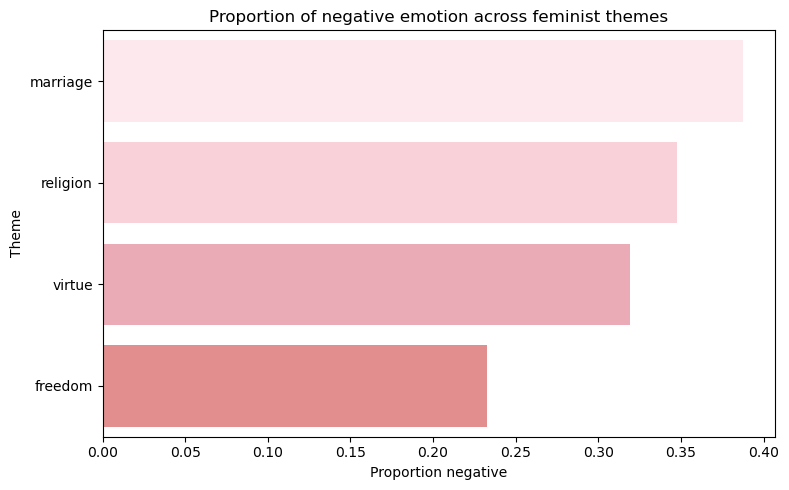

In [273]:
# pink gradient for visual continuity
pink_palette = ["#ffe5ec", "#ffccd5", "#f4a1b0", "#f08080"]

# plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=theme_counts.sort_values("negative_ratio", ascending=False),
    x="negative_ratio",
    y="themes",
    palette=pink_palette
)

plt.title("Proportion of negative emotion across feminist themes")
plt.xlabel("Proportion negative")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

In [274]:
df_tagged

sentence      title  \
67    I think it was only as I grew to love Ellador ...    Herland   
72    I was thinking over the pictures of God I had ...    Herland   
76    She could be horrified at Damnation, and quest...    Herland   
80    So the great day came, and the countless crowd...    Herland   
83    After marriage there arose in us a somewhat un...    Herland   
...                                                 ...        ...   
6930  “I repeat I freely consent to go with you as y...  Jane Eyre   
6953                                But I want a wife.”  Jane Eyre   
6954  To be your wife is, for\nme, to be as happy as...  Jane Eyre   
6958  “I telled Mary how it would be,” he said: “I k...  Jane Eyre   
6963  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                        author  year chunk_id inferred_emotion  \
67    Charlotte Perkins Gilman  1915   CP_080              joy   
72    Charlotte Perkins Gilman  1915   CP_083          sadness   
76    Charlotte Perkins Gilman  1915   CP_086             fear   
80    Charlotte Perkins Gilman  1915   CP_087              joy   
83    Charlotte Perkins Gilman  1915   CP_091         surprise   
...                        ...   ...      ...              ...   
6930          Charlotte Brontë  1847   CB_346              joy   
6953          Charlotte Brontë  1847   CB_377              joy   
6954          Charlotte Brontë  1847   CB_377              joy   
6958          Charlotte Brontë  1847   CB_380              joy   
6963          Charlotte Brontë  1847   CB_383              joy   

      sentence_length                                         text_lower  \
67                 44  i think it was only as i grew to love ellador ...   
72                 50  i was thinking over the pictures of god i had ...   
76                 19  she could be horrified at damnation, and quest...   
80                 35  so the great day came, and the countless crowd...   
83                 31  after marriage there arose in us a somewhat un...   
...               ...                                                ...   
6930               26  “i repeat i freely consent to go with you as y...   
6953                5                                but i want a wife.”   
6954               17  to be your wife is, for\nme, to be as happy as...   
6958               64  “i telled mary how it would be,” he said: “i k...   
6963               30  i know that a\nstranger’s hand will write to m...   

        themes emotion_polarity  
67    religion         positive  
72    religion         negative  
76    religion         negative  
80    marriage         positive  
83    marriage         positive  
...        ...              ...  
6930  marriage         positive  
6953  marriage         positive  
6954  marriage         positive  
6958  religion         positive  
6963  religion         positive  

[581 rows x 10 columns]

In [275]:
# reuse the previous tagged dataframe

# count by theme and author
author_theme_counts = df_tagged.groupby(["themes", "author", "emotion_polarity"]).size().unstack(fill_value=0)

# calculate proportions
author_theme_counts["total"] = author_theme_counts.sum(axis=1)
author_theme_counts["negative_ratio"] = author_theme_counts.get("negative", 0) / author_theme_counts["total"]
author_theme_counts = author_theme_counts.reset_index()

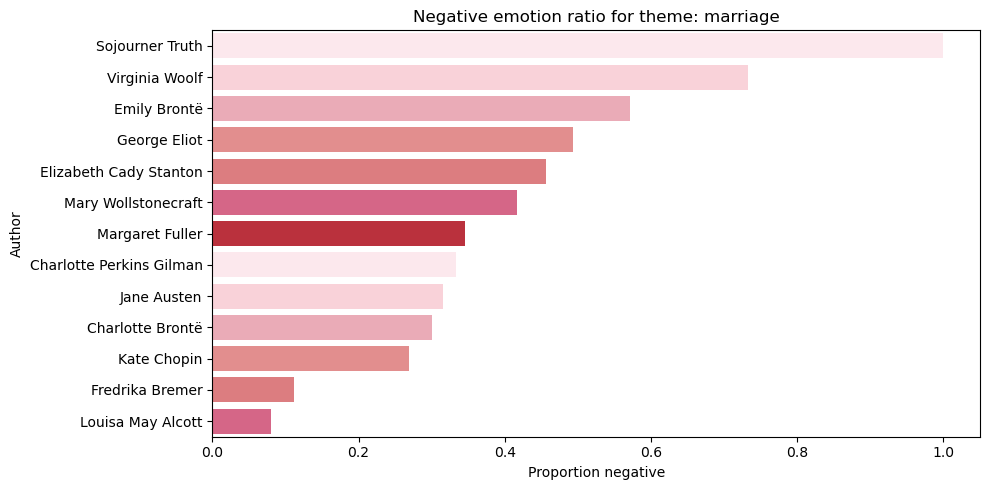

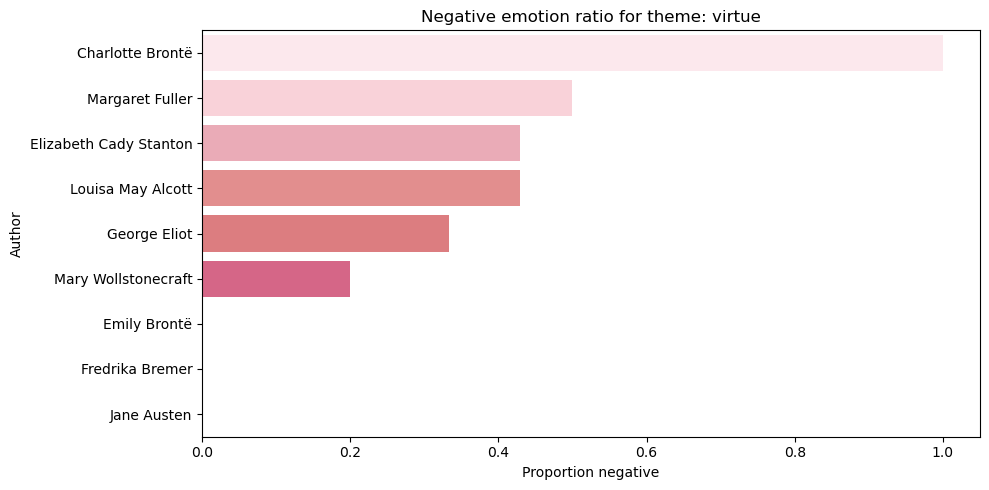

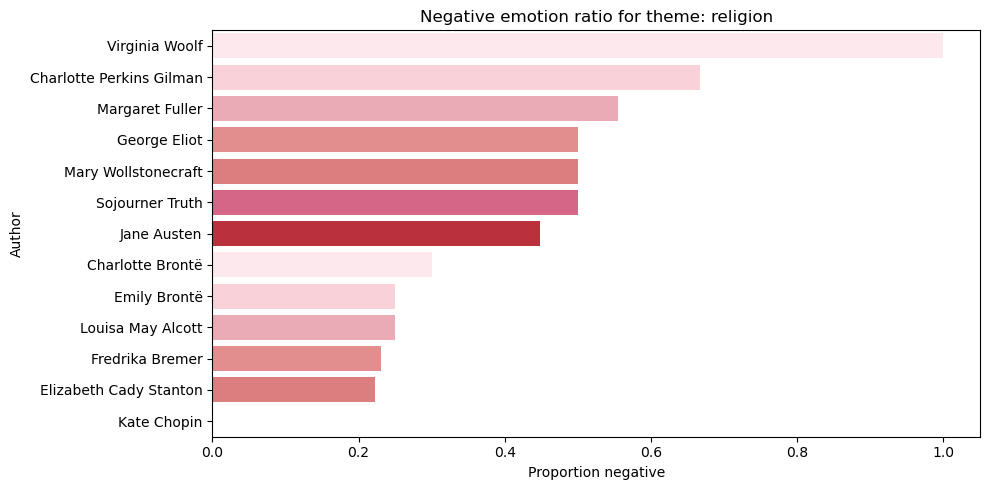

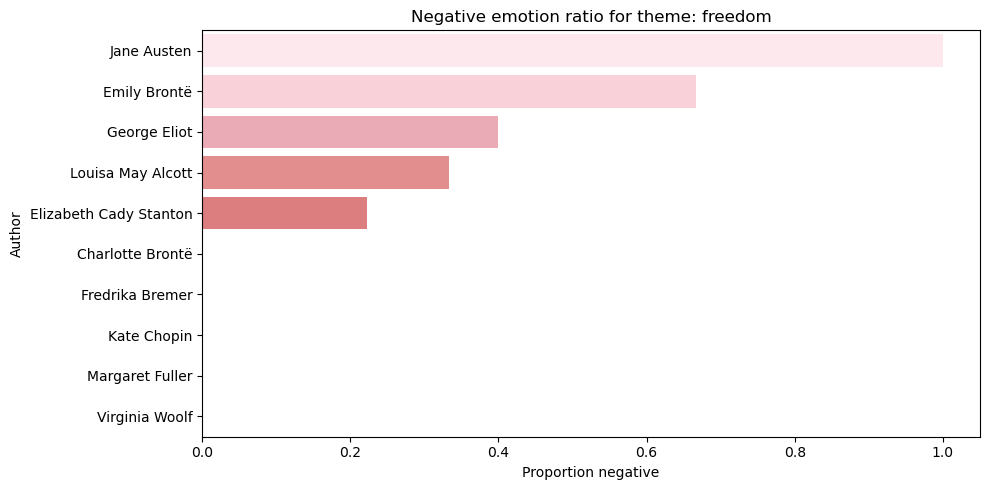

In [276]:
# define pink palette for consistency
pink_palette = ["#ffe5ec", "#ffccd5", "#f4a1b0", "#f08080", "#ec6d71", "#e75480", "#d11a2a"]

# loop through each theme and plot
for theme in theme_keywords.keys():
    theme_df = author_theme_counts[author_theme_counts["themes"] == theme]

    if not theme_df.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(
            data=theme_df.sort_values("negative_ratio", ascending=False),
            x="negative_ratio",
            y="author",
            palette=pink_palette
        )
        plt.title(f"Negative emotion ratio for theme: {theme}")
        plt.xlabel("Proportion negative")
        plt.ylabel("Author")
        plt.tight_layout()
        plt.show()

In [290]:
df_emotions_f

sentence      title  \
0     And as we got farther and farther upstream, in...    Herland   
1     It was funny though, in the light of what we d...    Herland   
2     “It will be like a nunnery under an\nabbess--a...    Herland   
3     “Only women there--and children,” Jeff urged e...    Herland   
4     For uneasiness, for curiosity, for excitement-...    Herland   
...                                                 ...        ...   
6959    Diana and Mary\napproved the step unreservedly.  Jane Eyre   
6960  Her frantic joy at beholding me\nagain moved m...  Jane Eyre   
6961  I took care she should never want for\nanythin...  Jane Eyre   
6962  By her grateful attention to me and mine, she ...  Jane Eyre   
6963  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                        author  year chunk_id inferred_emotion  \
0     Charlotte Perkins Gilman  1915   CP_002         surprise   
1     Charlotte Perkins Gilman  1915   CP_006              joy   
2     Charlotte Perkins Gilman  1915   CP_006              joy   
3     Charlotte Perkins Gilman  1915   CP_009              joy   
4     Charlotte Perkins Gilman  1915   CP_015              joy   
...                        ...   ...      ...              ...   
6959          Charlotte Brontë  1847   CB_380              joy   
6960          Charlotte Brontë  1847   CB_381              joy   
6961          Charlotte Brontë  1847   CB_381              joy   
6962          Charlotte Brontë  1847   CB_381              joy   
6963          Charlotte Brontë  1847   CB_383              joy   

      sentence_length                                         text_lower  \
0                  57  and as we got farther and farther upstream, in...   
1                  28  it was funny though, in the light of what we d...   
2                  12  “it will be like a nunnery under an\nabbess--a...   
3                   7  “only women there--and children,” jeff urged e...   
4                  35  for uneasiness, for curiosity, for excitement-...   
...               ...                                                ...   
6959                7    diana and mary\napproved the step unreservedly.   
6960               10  her frantic joy at beholding me\nagain moved m...   
6961               33  i took care she should never want for\nanythin...   
6962               27  by her grateful attention to me and mine, she ...   
6963               30  i know that a\nstranger’s hand will write to m...   

          themes  is_expressive  
0             []           True  
1             []           True  
2             []           True  
3             []           True  
4             []           True  
...          ...            ...  
6959          []           True  
6960          []           True  
6961          []           True  
6962          []           True  
6963  [religion]           True  

[6964 rows x 10 columns]

In [289]:
# keywords and negative emotion types
target_keywords = ["marriage", "virtue", "religion", "freedom"]
negative_emotions = ["anger", "fear", "sadness", "disgust"]

In [291]:
# lowercased text for matching
df_emotions_f["text_lower"] = df_emotions_f["sentence"].str.lower()

# keep only sentences with negative emotion and containing any target keyword
kwic_neg = df_emotions_f[
    (df_emotions_f["inferred_emotion"].isin(negative_emotions)) &
    (df_emotions_f["text_lower"].apply(lambda x: any(kw in x for kw in target_keywords)))
].copy()

In [292]:
# helper: find first matching keyword in sentence
def find_keyword(text):
    for kw in target_keywords:
        if kw in text:
            return kw
    return None

# assign matched keyword
kwic_neg["matched_keyword"] = kwic_neg["text_lower"].apply(find_keyword)

# format keyword for bolding (if displaying in markdown or export)
kwic_neg["kwic_highlighted"] = kwic_neg.apply(
    lambda row: row["sentence"].replace(row["matched_keyword"], f"[{row['matched_keyword'].upper()}]") 
    if pd.notnull(row["matched_keyword"]) else row["sentence"],
    axis=1
)

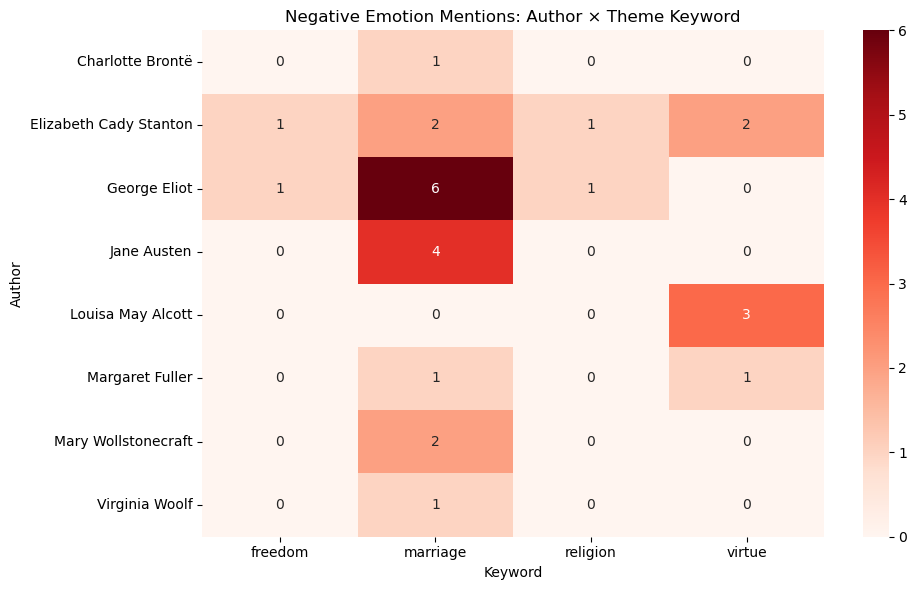

In [299]:
# build pivot table
heat_data = kwic_neg.pivot_table(index="author", columns="matched_keyword", 
                                  values="sentence", aggfunc="count", fill_value=0)

# plot
plt.figure(figsize=(10, 6))
sns.heatmap(heat_data, cmap="Reds", annot=True, fmt="d")

plt.title("Negative Emotion Mentions: Author × Theme Keyword")
plt.xlabel("Keyword")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

The heatmap provides a granular view of how frequently each author expresses **negative sentiment** tied to each theme.

- George Eliot, Jane Austen, and Elizabeth Cady Stanton appear most active in this regard, especially for **marriage**.
- The **sparsity** in the lower-right reflects authors who mention a theme less often or do so with less emotional intensity.

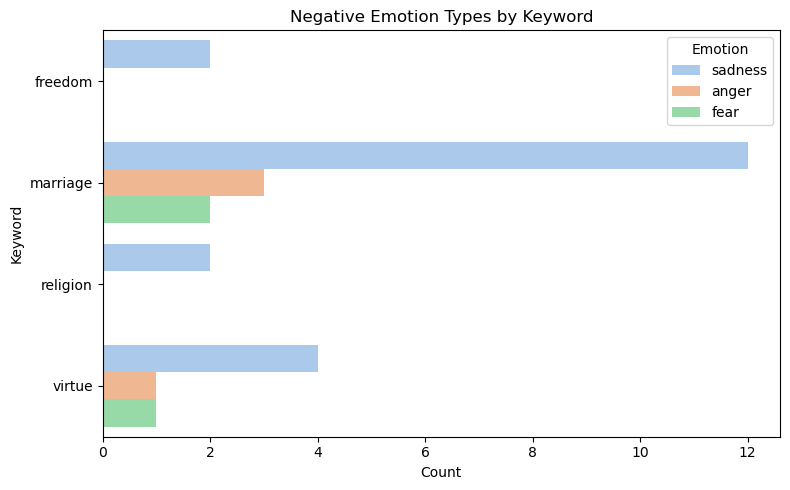

In [300]:
# group and count
grouped = kwic_neg.groupby(["matched_keyword", "inferred_emotion"]).size().reset_index(name="count")

# plot
plt.figure(figsize=(8, 5))
sns.barplot(data=grouped, x="count", y="matched_keyword", hue="inferred_emotion", palette="pastel")

plt.title("Negative Emotion Types by Keyword")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.legend(title="Emotion")
plt.tight_layout()
plt.show()

This barplot breaks down **negative emotion types** (sadness, anger, fear) per theme:

- **Sadness** is the most dominant emotion across all themes, especially for **marriage**.
- **Anger** and **fear** appear selectively, often where resistance or constraint is more explicitly rendered (e.g., in discussions of **virtue** or **freedom**).

In [281]:
df_emotions_full

sentence      title  \
0      We had some\nbird’s-eyes of the cities and par...    Herland   
1      Descriptions aren’t any good\nwhen it comes to...    Herland   
2      And as we got farther and farther upstream, in...    Herland   
3      “Up yonder,” “Over there,” “Way up”--was all t...    Herland   
4      But there were tales of long ago, when some br...    Herland   
...                                                  ...        ...   
44259  One morning at the end of the two years, as I ...  Jane Eyre   
44260  Diana and Mary Rivers are both married:\nalter...  Jane Eyre   
44261  Diana’s husband is a captain in the navy, a ga...  Jane Eyre   
44262  Mary’s is a clergyman, a college friend of her...  Jane Eyre   
44263  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                         author  year chunk_id inferred_emotion  \
0      Charlotte Perkins Gilman  1915   CP_001          neutral   
1      Charlotte Perkins Gilman  1915   CP_001          neutral   
2      Charlotte Perkins Gilman  1915   CP_002         surprise   
3      Charlotte Perkins Gilman  1915   CP_002          neutral   
4      Charlotte Perkins Gilman  1915   CP_002          neutral   
...                         ...   ...      ...              ...   
44259          Charlotte Brontë  1847   CB_382          neutral   
44260          Charlotte Brontë  1847   CB_382          neutral   
44261          Charlotte Brontë  1847   CB_382          neutral   
44262          Charlotte Brontë  1847   CB_382          neutral   
44263          Charlotte Brontë  1847   CB_383              joy   

       sentence_length emotion_group  
0                   36       neutral  
1                   17       neutral  
2                   57     emotional  
3                   34       neutral  
4                   21       neutral  
...                ...           ...  
44259               34       neutral  
44260               22       neutral  
44261               15       neutral  
44262               20       neutral  
44263               30     emotional  

[44264 rows x 8 columns]

In [284]:
# group by author and count emotional vs total sentences
author_expr = df_emotions_full.groupby("author")["emotion_group"].value_counts().unstack(fill_value=0).reset_index()

# calculate expressive ratio (emotional / total)
author_expr["total_sentences"] = author_expr["emotional"] + author_expr["neutral"]
author_expr["expressive_ratio"] = author_expr["emotional"] / author_expr["total_sentences"]

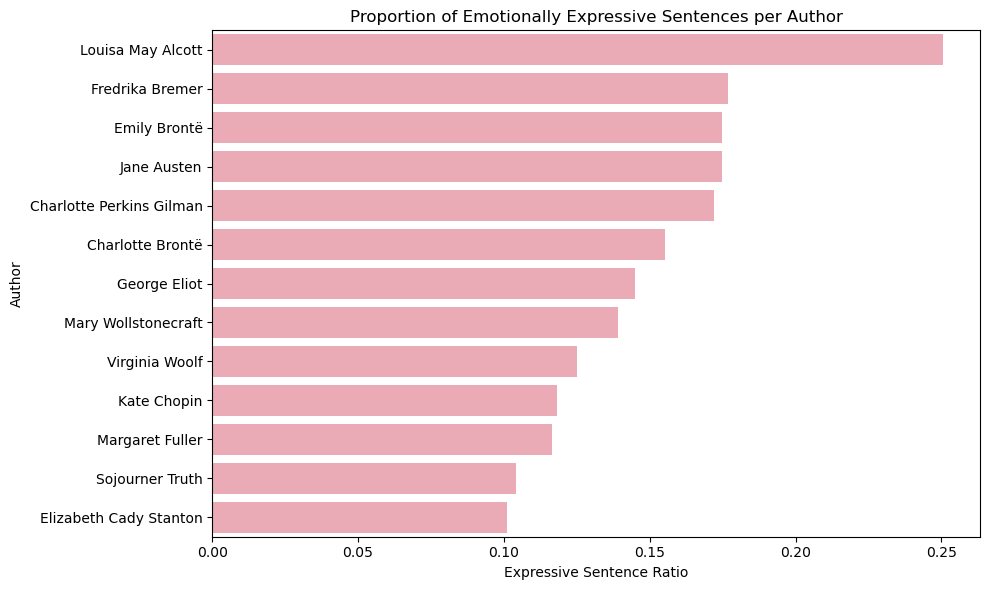

In [285]:
# sort and plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=author_expr.sort_values("expressive_ratio", ascending=False),
    x="expressive_ratio",
    y="author",
    palette=["#f4a1b0"] * len(author_expr)
)

plt.title("Proportion of Emotionally Expressive Sentences per Author")
plt.xlabel("Expressive Sentence Ratio")
plt.ylabel("Author")
plt.tight_layout()
plt.show()

In [286]:
df_emotions_f

sentence      title  \
0     And as we got farther and farther upstream, in...    Herland   
1     It was funny though, in the light of what we d...    Herland   
2     “It will be like a nunnery under an\nabbess--a...    Herland   
3     “Only women there--and children,” Jeff urged e...    Herland   
4     For uneasiness, for curiosity, for excitement-...    Herland   
...                                                 ...        ...   
6959    Diana and Mary\napproved the step unreservedly.  Jane Eyre   
6960  Her frantic joy at beholding me\nagain moved m...  Jane Eyre   
6961  I took care she should never want for\nanythin...  Jane Eyre   
6962  By her grateful attention to me and mine, she ...  Jane Eyre   
6963  I know that a\nstranger’s hand will write to m...  Jane Eyre   

                        author  year chunk_id inferred_emotion  \
0     Charlotte Perkins Gilman  1915   CP_002         surprise   
1     Charlotte Perkins Gilman  1915   CP_006              joy   
2     Charlotte Perkins Gilman  1915   CP_006              joy   
3     Charlotte Perkins Gilman  1915   CP_009              joy   
4     Charlotte Perkins Gilman  1915   CP_015              joy   
...                        ...   ...      ...              ...   
6959          Charlotte Brontë  1847   CB_380              joy   
6960          Charlotte Brontë  1847   CB_381              joy   
6961          Charlotte Brontë  1847   CB_381              joy   
6962          Charlotte Brontë  1847   CB_381              joy   
6963          Charlotte Brontë  1847   CB_383              joy   

      sentence_length                                         text_lower  \
0                  57  and as we got farther and farther upstream, in...   
1                  28  it was funny though, in the light of what we d...   
2                  12  “it will be like a nunnery under an\nabbess--a...   
3                   7  “only women there--and children,” jeff urged e...   
4                  35  for uneasiness, for curiosity, for excitement-...   
...               ...                                                ...   
6959                7    diana and mary\napproved the step unreservedly.   
6960               10  her frantic joy at beholding me\nagain moved m...   
6961               33  i took care she should never want for\nanythin...   
6962               27  by her grateful attention to me and mine, she ...   
6963               30  i know that a\nstranger’s hand will write to m...   

          themes  is_expressive  
0             []           True  
1             []           True  
2             []           True  
3             []           True  
4             []           True  
...          ...            ...  
6959          []           True  
6960          []           True  
6961          []           True  
6962          []           True  
6963  [religion]           True  

[6964 rows x 10 columns]

In [287]:
# filter only emotional rows

# count emotion type per author
author_emotion_dist = df_emotions_f.groupby(["author", "inferred_emotion"]).size().reset_index(name="count")

# normalize to proportions
author_emotion_dist["total"] = author_emotion_dist.groupby("author")["count"].transform("sum")
author_emotion_dist["proportion"] = author_emotion_dist["count"] / author_emotion_dist["total"]

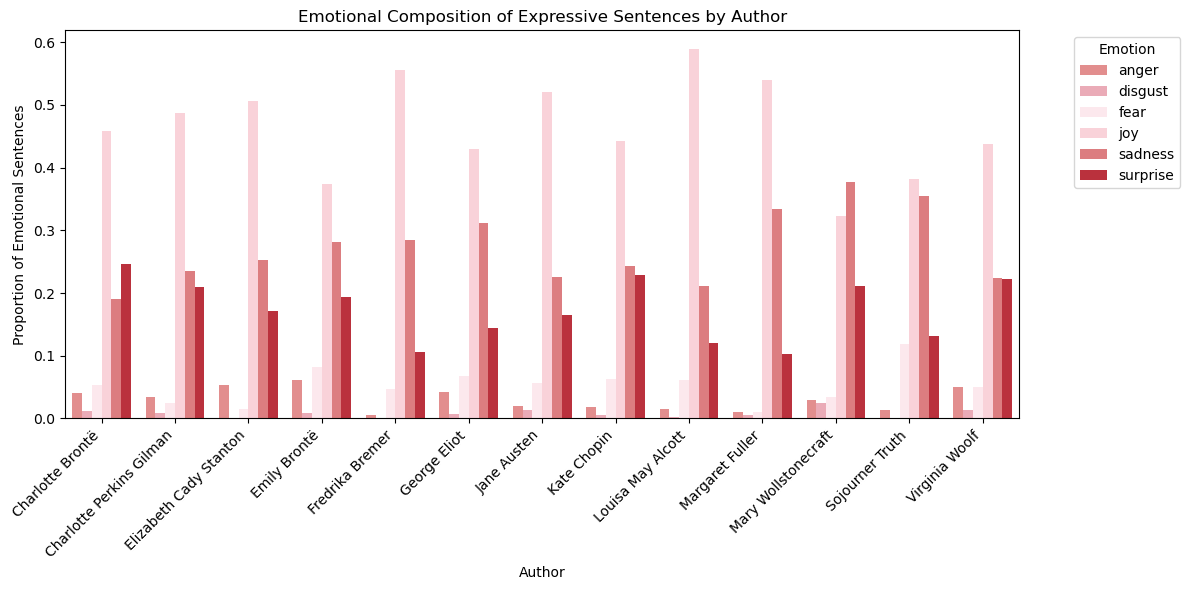

In [288]:
# plot stacked emotion proportions per author
plt.figure(figsize=(12, 6))
sns.barplot(
    data=author_emotion_dist,
    x="author", y="proportion", hue="inferred_emotion",
    palette=["#f08080", "#f4a1b0", "#ffe5ec", "#ffccd5", "#ec6d71", "#d11a2a"]
)

plt.title("Emotional Composition of Expressive Sentences by Author")
plt.xlabel("Author")
plt.ylabel("Proportion of Emotional Sentences")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

This multilayered analysis confirms many of our expectations. Themes like **marriage**, **virtue**, and **religion** carry a **strong burden of negative affect**, reflecting their centrality as **sites of feminist resistance, critique, or ambivalence**. Meanwhile, **freedom**, though not free from negativity, emerges as comparatively **hopeful and forward-looking**.

We also observe that individual authors express distinct emotional strategies:
- Some, like **Charlotte Brontë** or **Virginia Woolf**, use emotion as a sharp tool of **critique**.
- Others, like **Louisa May Alcott**, are more emotionally reserved or idealistic in their framing of difficult themes.

Overall, this section highlights how **emotional polarity functions as an interpretive signal**, revealing how feminist writers **reclaim or reject traditional values** through carefully calibrated affective language.

## 8. Conclusions

This project set out to computationally explore the emotional landscape of feminist literature from 1790 to 1925—a corpus rich in ideological complexity, narrative innovation, and historical resonance. Our primary goal was to test whether affective patterns, as inferred via large-scale NLP tools, could yield meaningful insights into how feminist ideas are conveyed, resisted, and reframed across different textual, temporal, and thematic layers.

To this end, we implemented a multi-step pipeline that combined sentence segmentation, zero-shot emotion classification (via the GoEmotions model), emotion mapping to Ekman's typology, thematic keyword tagging, and topic modeling with BERTopic. Along the way, we paid careful attention to issues of scale, bias, and interpretability: for example, by undersampling the overwhelming “neutral” class to test model behavior, or manually mapping emotional labels into a more compact, theory-aligned framework. Each step of the pipeline informed the next, yielding a tightly integrated data-driven portrait of feminist literary emotion.

### Emotion Classification as a Lens on Feminist Voice

Our first major finding emerged early: across both the sampled and full datasets, the **‘neutral’ category dominated** the raw GoEmotions predictions. This was not entirely unexpected, given the model’s training on conversational Reddit data and the syntactic complexity of literary texts. Still, it raised a crucial point—**emotion detection in long-form writing must contend with narration, exposition, and descriptive drift**. After mapping the full emotional label set to Ekman’s six basic emotions plus ‘neutral’, we found **‘joy’ and ‘sadness’ to be the most frequent emotional tones**, followed by ‘surprise’ and, to a lesser extent, ‘fear’. These categories proved especially meaningful as we moved toward thematic interpretation.

Sentence-level analysis revealed that **emotionally charged sentences tended to be shorter and more syntactically direct** than neutral ones—a pattern consistent with linguistic theories of affective salience and supported by statistical testing. This insight had practical modeling implications (e.g., for emotion-based filtering), but also interpretive ones: it underscored that emotion, in this corpus, often functions as **punctuation—a sharp charge within longer stretches of narrative exposition.**

### Emotions over Time: Literary Affect as Historical Witness

Temporal analysis (Section 7.1) situated emotion as a historically contingent feature of feminist literature. By plotting the proportion of each mapped emotion over decades, we revealed a **subtle but persistent interplay between political milestones and affective trends**. While joy and sadness remained prominent across the board, their ratio shifted at key moments: for instance, a rise in surprise and fear during the late 19th century paralleled the emergence of modernist styles and intensified debates around suffrage and autonomy.

Crucially, we overlaid this plot with **major feminist publications and authorial contributions**, allowing us to trace how emotional tone both reflected and perhaps anticipated feminist discourse. These patterns lent empirical weight to theoretical claims by scholars like Cvetkovich and Ahmed—that **emotion in feminist texts is a mode of historical testimony and resistance**, not merely expressive flourish.


### Theme and Emotion: Conceptual Tensions in Feminist Thought

The project’s most compelling insights came when we moved beyond surface-level classification to theme-driven analysis. In Section 7.2, we examined **how emotions frame autonomy-related concepts**—education, freedom, work, and independence. These were predominantly associated with **positive emotions**, particularly joy and surprise, suggesting that feminist writing not only critiques, but **envisions and affirms**. In contrast, Section 7.5 addressed more ideologically charged themes—**marriage, virtue, religion, and freedom**—and here we saw a distinct **shift toward negative emotion**, especially sadness, anger, and fear.

The contrast between these two sets of themes was striking: **whereas autonomy was aspirational, tradition was affectively fraught**. This bifurcation supports the view that feminist writing operates through emotional contrasts, staging a rhetorical struggle between internalized norms and emerging ideals. Author-level breakdowns confirmed that **expressivity varied by writer**, with some (e.g., Woolf, C.P. Gilman) using emotion as critique, and others (e.g., Austen, Alcott) adopting more balanced or ambivalent emotional tones.

### Beyond Labels: Emotional Diversity and Expressivity

Topic modeling in Section 7.4 provided a different angle: by calculating the **entropy of emotional distributions across BERTopic themes**, we ranked topics by **emotional diversity**. This allowed us to identify the most emotionally complex themes—not necessarily the most negative or positive, but those that contained **a range of conflicting affective signals**. Many of these topics combined interpersonal, spatial, and cognitive dimensions, reinforcing the idea that feminist critique is **not limited to clear-cut judgments**, but often explores affective ambiguity.

Finally, Section 7.6 asked which authors were most emotionally expressive—measured as the proportion of emotionally labeled sentences in their writing. This metric revealed a **surprising hierarchy**, with Alcott, Bremer, and Brontë at the top, and Stanton and Truth (despite their political intensity) at the lower end. When broken down by emotion type, authors diverged even further: some favored joy, others sadness or fear, suggesting that **feminist emotion is both personal and strategic**, shaped by genre, audience, and rhetorical purpose.


### Toward a Feminist Computational Criticism

Taken together, these results demonstrate that affect is not only detectable in historical feminist literature, but **patterned in meaningful ways**—ways that align with and enhance traditional close reading. Emotion serves as **a carrier of ideology, a signal of rupture, and a tool for world-building**. Our approach shows that computational methods, when carefully designed and contextually grounded, can bring texture and nuance to feminist literary history.

This work also points to future directions. For instance, our BERTopic results were partially limited by noisy topics, indicating the need for more robust name-stripping or guided topic extraction. Likewise, emotion models fine-tuned on long-form texts could enhance precision. But even with these limitations, our pipeline successfully extracted multi-dimensional emotion profiles—**by sentence, theme, author, and time**—and showed that **feminist affect is as much a structure as a sentiment**.

In closing, this project offers a blueprint for combining NLP and feminist theory to illuminate how literary emotion shapes—and is shaped by—the politics of gender, language, and historical change.